![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
!pip install lightgbm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación librerías
%matplotlib inline
import pandas as pd
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

In [4]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [5]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [6]:
import datetime
time_now = datetime.datetime.now()
dataTraining['Year'] = dataTraining['Year'].apply(lambda x : time_now.year - x)
dataTesting['Year'] = dataTesting['Year'].apply(lambda x : time_now.year - x)

In [7]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,6,9913,FL,Jeep,Wrangler
1,37895,8,20578,OH,Chevrolet,Tahoe4WD
2,18430,11,83716,TX,BMW,X5AWD
3,24681,9,28729,OH,Cadillac,SRXLuxury
4,26998,10,64032,CO,Jeep,Wrangler


In [8]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,9,31909,MD,Nissan,MuranoAWD
1,6,5362,FL,Jeep,Wrangler
2,9,50300,OH,Ford,FlexLimited
3,19,132160,WA,BMW,5
4,8,25226,MA,Jeep,Grand


In [9]:
dataTraining['Make'] = dataTraining['Make'].astype('category')
dataTraining['Model'] = dataTraining['Model'].astype('category')
dataTraining['State'] = dataTraining['State'].astype('category')
dataTraining.dtypes

Price         int64
Year          int64
Mileage       int64
State      category
Make       category
Model      category
dtype: object

In [10]:
dataTraining.isnull().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

In [11]:
dataTraining.shape

(400000, 6)

In [12]:
dataTraining['State'].unique()

[' FL', ' OH', ' TX', ' CO', ' ME', ..., ' DE', ' ID', ' RI', ' WY', ' DC']
Length: 51
Categories (51, object): [' AK', ' AL', ' AR', ' AZ', ..., ' WA', ' WI', ' WV', ' WY']

In [13]:
dataTraining['Make'].unique()

['Jeep', 'Chevrolet', 'BMW', 'Cadillac', 'Mercedes-Benz', ..., 'Pontiac', 'Jaguar', 'Bentley', 'Suzuki', 'Freightliner']
Length: 38
Categories (38, object): ['Acura', 'Audi', 'BMW', 'Bentley', ..., 'Tesla', 'Toyota', 'Volkswagen', 'Volvo']

In [14]:
dataTraining['Model'].unique()

['Wrangler', 'Tahoe4WD', 'X5AWD', 'SRXLuxury', '3', ..., 'PriusOne', 'Element2WD', 'Excursion137"', 'WRXPremium', 'RX-84dr']
Length: 525
Categories (525, object): ['1', '15002WD', '15004WD', '1500Laramie', ..., 'Yukon4dr', 'tC2dr', 'xB5dr', 'xD5dr']

In [15]:
# Eliminar duplicados
duplicados = dataTraining.duplicated()
print("Número total de duplicados en el DataFrame: ", duplicados.sum())

Número total de duplicados en el DataFrame:  169


In [16]:
dataTraining = dataTraining.drop_duplicates()

In [17]:
dataTraining.describe()

,Price,Year,Mileage
count,399831.000000,399831.000000,3.998310e+05
mean,21143.998537,9.803409,5.509327e+04
std,10751.954687,3.292060,4.087644e+04
min,5001.000000,5.000000,5.000000e+00
25%,13499.000000,7.000000,2.586450e+04
50%,18449.000000,9.000000,4.297000e+04
75%,26999.000000,11.000000,7.745400e+04
max,79999.000000,26.000000,2.457832e+06


Podemos observar que el valor máximo que toma la variable "Mileage" es de 2'457.832 millas, lo cual es un valor atípico. Para este caso, se tomará la convención de que un automóvil en promedio recorre 15.000 millas por año y por lo tanto se eliminarán los registros que presenten un kilometraje superior a 275.000 millas (que corresponden a los 22 años que hay entre 1997 y 2018 en nuestro dataset).

In [18]:
dataTraining = dataTraining.drop(dataTraining[dataTraining['Mileage'] > 275000].index)

In [19]:
dataTraining.describe()

,Price,Year,Mileage
count,399576.000000,399576.000000,399576.000000
mean,21149.448563,9.798784,54896.695560
std,10751.584858,3.286116,39831.623165
min,5001.000000,5.000000,5.000000
25%,13500.000000,7.000000,25851.000000
50%,18455.000000,9.000000,42946.000000
75%,26999.000000,11.000000,77362.000000
max,79999.000000,26.000000,274893.000000


In [20]:
dataTraining.shape

(399576, 6)

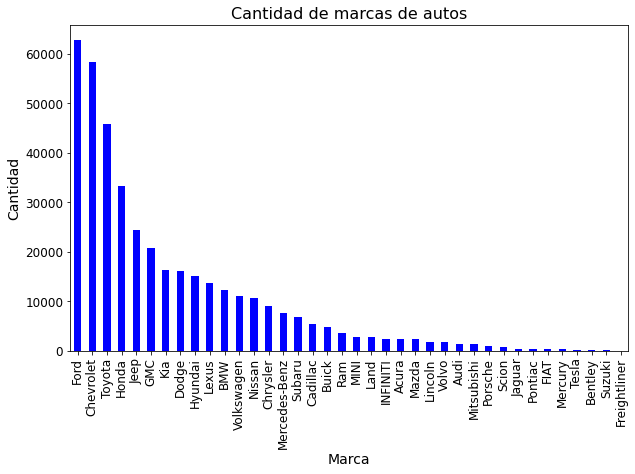

In [21]:
conteo_make = dataTraining['Make'].value_counts()
conteo_make.plot.bar(figsize=(10,6), fontsize=12, color='blue')
plt.title('Cantidad de marcas de autos', fontsize=16)
plt.xlabel('Marca', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.show()

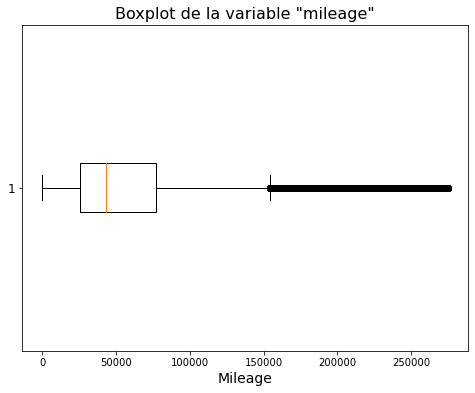

In [22]:
plt.figure(figsize=(8, 6))
plt.boxplot(dataTraining['Mileage'], vert=False)
plt.title('Boxplot de la variable "mileage"', fontsize=16)
plt.xlabel('Mileage', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

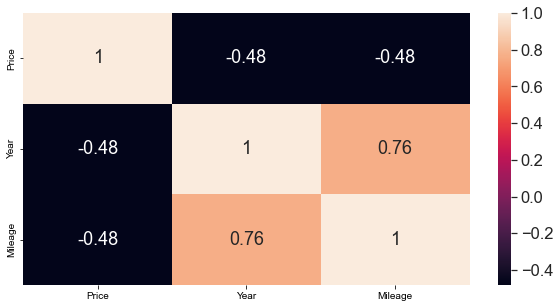

In [23]:
MatrixCorrelacion = dataTraining.corr()

fig, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.5)  

sns.heatmap(MatrixCorrelacion, annot=True, ax=ax)
plt.show()

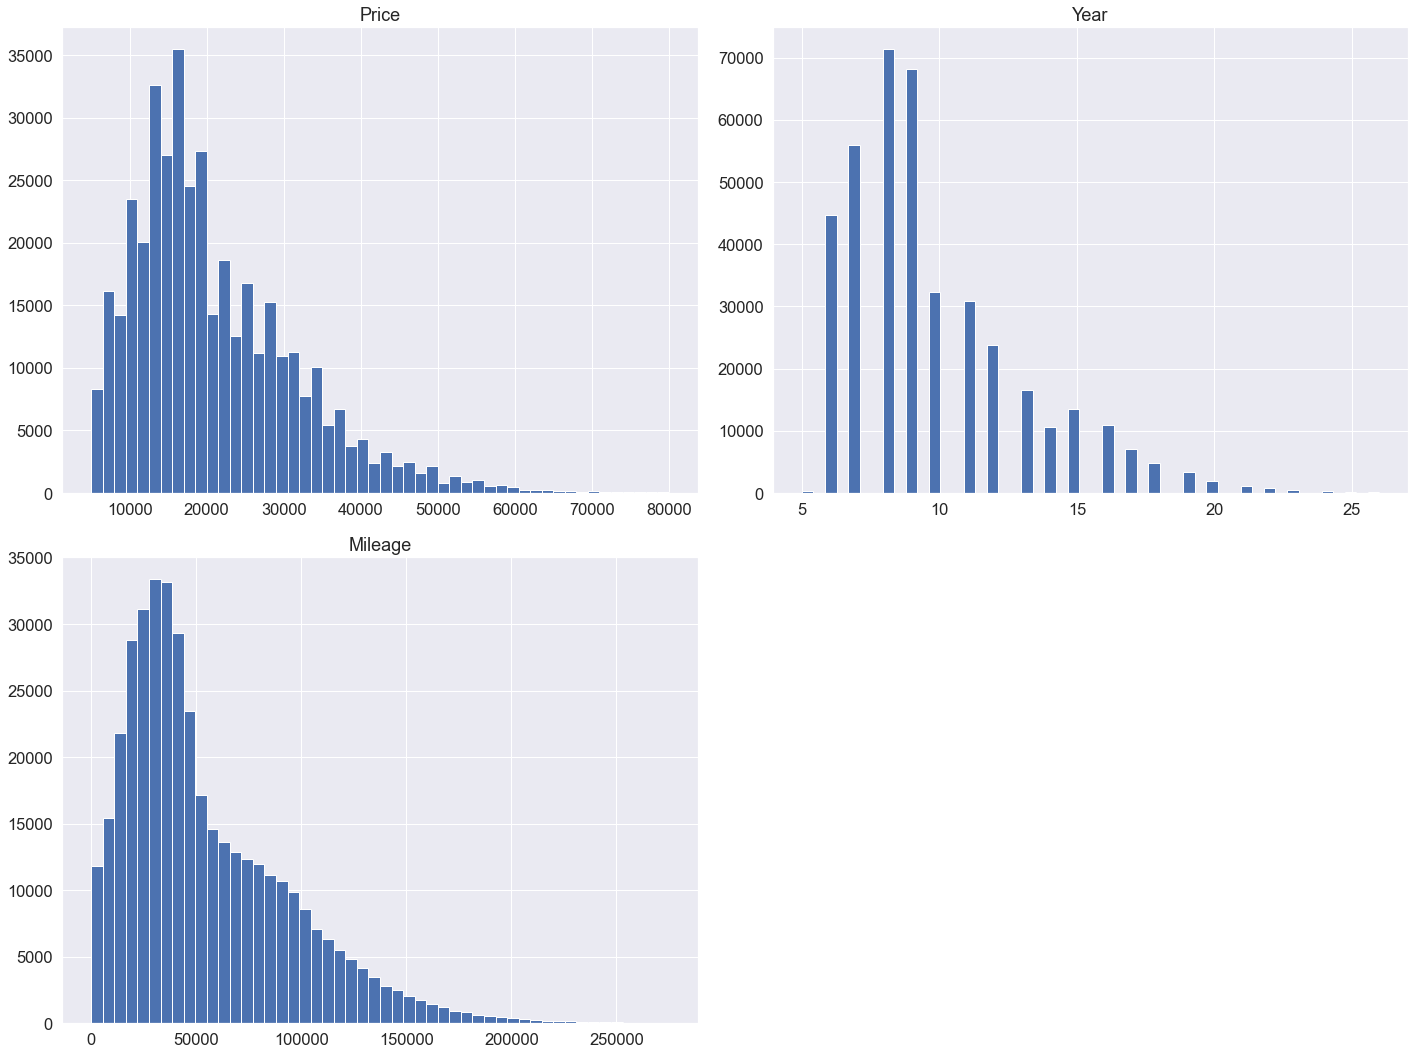

In [24]:
#Histograma para todas las variables numéricas incluyendo la variable de respuesta
dataTraining.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

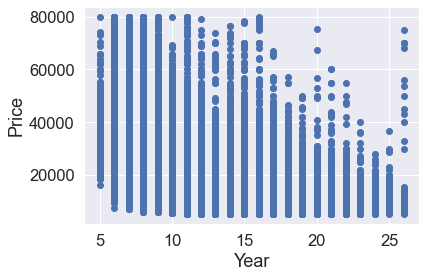

In [25]:
plt.scatter(dataTraining.Year,dataTraining.Price)
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

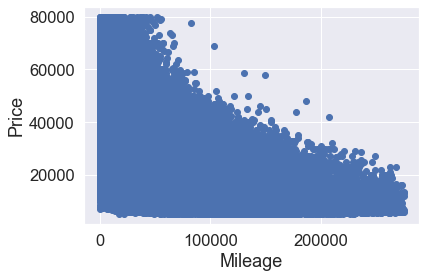

In [26]:
plt.scatter(dataTraining.Mileage,dataTraining.Price)
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.show()

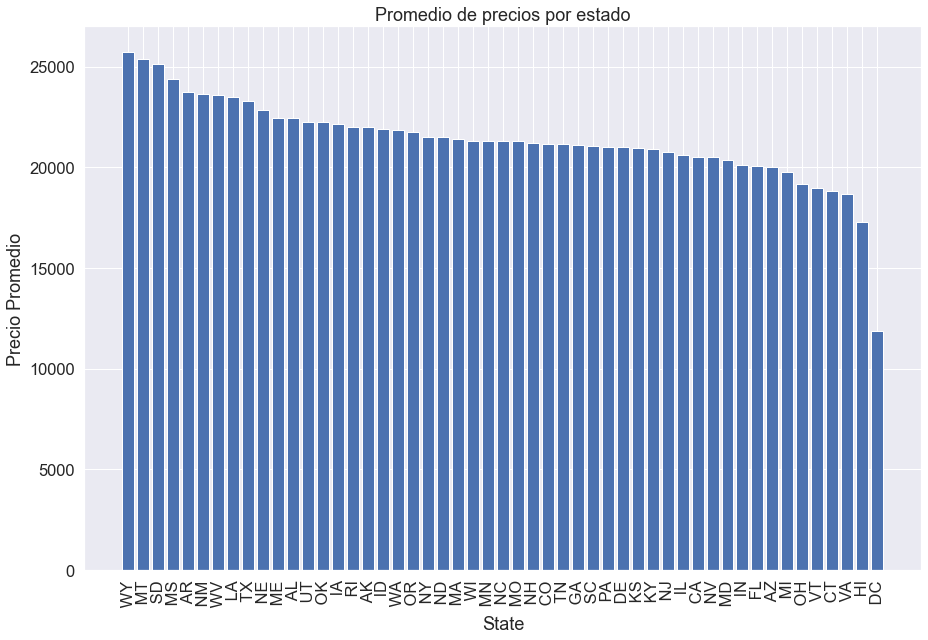

In [27]:
# agrupamos por Estado y calculamos el promedio de los precios
data = dataTraining.groupby('State')['Price'].mean()

# ordenamos los valores de mayor a menor
data = data.sort_values(ascending=False)

# creamos la gráfica de barras
plt.figure(figsize=(15,10))
plt.bar(data.index, data.values)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Precio Promedio')
plt.title('Promedio de precios por estado')
plt.show()

<AxesSubplot:xlabel='Price', ylabel='Density'>

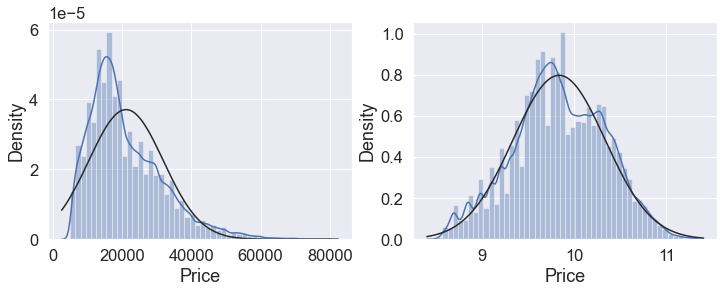

In [28]:
from scipy.stats import norm
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(dataTraining['Price'], ax=ax[0], fit=norm)
sns.distplot(np.log(dataTraining[('Price')]+1), ax=ax[1], fit= norm)

In [29]:
dataTraining.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

In [30]:
# Fit transform

scaler = StandardScaler()
scaler.fit(dataTraining[['Mileage']])
dataTraining[['Mileage']] = scaler.transform(dataTraining[['Mileage']])
dataTesting[['Mileage']] = scaler.transform(dataTesting[['Mileage']])

In [31]:
k=104

############################## Dummies para Marca ####################################
dummies = pd.get_dummies(dataTraining['Make'], prefix='Make')
dummies=dummies.drop('Make_Freightliner', axis=1)
dataTraining = pd.concat([dataTraining, dummies], axis=1)   

######################## Dummies para los modelos ##########################

# Crear un diccionario vacío para almacenar los resultados
promedios_por_marca = {}

# Recorrer los valores distintos de la columna "Make"
for marca in dataTraining["Model"].unique():
    # Obtener el promedio de la columna "Price" para los registros donde "Make" es igual a la marca actual
    promedio = dataTraining.loc[dataTraining["Model"] == marca, "Price"].mean()
    # Agregar la marca y su promedio al diccionario
    promedios_por_marca[marca] = promedio
diccionario_ordenado = dict(sorted(promedios_por_marca.items(), key=lambda x: x[1], reverse=True))

In [32]:
column_names = []
for i in range(0, 60000, int(60000/k)):
    name = f"{i}-{i+int(60000/k)}"
    column_names.append(name)

# Creamos las columnas con el nombre de la partición en el dataframe
for i in range(len(column_names)):
    dataTraining[column_names[i]]=0

# Creamos diccionario con el rango de precios como llaves y los modelos que se encuentran en ese rango como valores
rango_precios = {}

for column in column_names:
    start, end = column.split("-")
    start, end = int(start), int(end)
    rango_precios[column] = [key for key, value in diccionario_ordenado.items() if start <= value <= end]

# Validar si el valor de la columna Model está en el diccionario rango_precios
for i, row in dataTraining.iterrows():
    model = row['Model']
    for key, value in rango_precios.items():
        if model in value:
            dataTraining.at[i, key] = 1

############################## Dummies para State ####################################
dummies = pd.get_dummies(dataTraining['State'], prefix='State')
dataTraining = pd.concat([dataTraining, dummies], axis=1)

dataTraining = dataTraining.drop(['State', 'Make', 'Model'], axis=1)
# ---------------------------------------------------------------------------------------------------

# Separación de variables predictoras (X) y variable de interés (y)
y = dataTraining['Price']
X = dataTraining.drop(['Price'], axis=1)

# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
y_train

337913    36800
138476    28900
121265    35233
112111     5900
79435     29500
          ...  
259423     5995
366226    18793
132030    19995
146977     9998
122048    74999
Name: Price, Length: 267715, dtype: int64

In [34]:
y_test

237806     7320
40291     13853
105338    31890
379199    33000
10772     11900
          ...  
395934     9776
33439      6900
48716     16400
305162    21995
197941    26900
Name: Price, Length: 131861, dtype: int64

In [35]:
y_train = np.log1p(y_train)
#y_test = np.log1p(y_test)

In [36]:
y_train

337913    10.513280
138476    10.271631
121265    10.469767
112111     8.682877
79435     10.292179
            ...    
259423     8.698848
366226     9.841293
132030     9.903288
146977     9.210240
122048    11.225243
Name: Price, Length: 267715, dtype: float64

### Desarrollo del modelo XGBoost, iterando sobre particiones en el precio (nmin y n)

In [37]:
RMSE=[]
MAE=[]
particiones=[]

xgb = XGBRegressor(random_state=1)
xgb.fit(X_train, y_train)

#Impresión de desempeño del modelo
y_pred3 = xgb.predict(X_test)

In [38]:
y_pred3

array([ 9.165095,  9.592156, 10.407469, ...,  9.703789,  9.902559,
       10.267666], dtype=float32)

In [39]:
y_test

237806     7320
40291     13853
105338    31890
379199    33000
10772     11900
          ...  
395934     9776
33439      6900
48716     16400
305162    21995
197941    26900
Name: Price, Length: 131861, dtype: int64

In [40]:
y_pred = np.expm1(y_pred3)
y_pred

array([ 9556.633, 14648.426, 33104.965, ..., 16378.548, 19980.443,
       28785.617], dtype=float32)

In [41]:
# RMSE
xgb_RMSE = mean_squared_error(y_test, y_pred, squared=False)
#print("RMSE: %.3f" %xgb_RMSE )
# MAE
xgb_MAE = mean_absolute_error(y_test, y_pred)
#print("MAE: %.3f" %xgb_MAE )

RMSE.append(xgb_RMSE)
MAE.append(xgb_MAE)
particiones.append(k)

print(RMSE)
print(MAE)
print(particiones)

[3910.1041788297534]
[2532.4616255691953]
[104]


Text(0, 0.5, 'MAE')

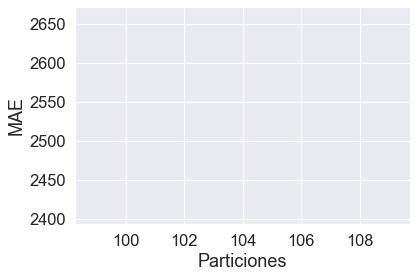

In [42]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(particiones, MAE)
plt.xlabel('Particiones')
plt.ylabel('MAE')

In [43]:
nParticiones = particiones[MAE.index(min(MAE))]
nParticiones

104

### Desarrollo del modelo LightGBM

In [44]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [45]:
lgbm = lgb.LGBMRegressor(**hyper_params)

In [46]:
y_test = np.log1p(y_test)

In [47]:
lgbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.9, col

[137]	valid_0's l1: 0.296943	valid_0's l2: 0.137666
[138]	valid_0's l1: 0.296485	valid_0's l2: 0.137197
[139]	valid_0's l1: 0.295941	valid_0's l2: 0.136728
[140]	valid_0's l1: 0.295512	valid_0's l2: 0.136286
[141]	valid_0's l1: 0.295057	valid_0's l2: 0.135825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's l1: 0.294778	valid_0's l2: 0.13558
[143]	valid_0's l1: 0.294254	valid_0's l2: 0.135123
[144]	valid_0's l1: 0.293819	valid_0's l2: 0.134689
[145]	valid_0's l1: 0.293296	valid_0's l2: 0.134246
[146]	valid_0's l1: 0.292766	valid_0's l2: 0.133794
[147]	valid_0's l1: 0.29228	valid_0's l2: 0.133348
[148]	valid_0's l1: 0.29183	valid_0's l2: 0.132929
[149]	valid_0's l1: 0.291316	valid_0's l2: 0.132492
[150]	valid_0's l1: 0.290808	valid_0's l2: 0.132054
[151]	valid_0's l1: 0.29031	valid_0's l2: 0.131632
[152]	valid_0's l1: 0.289805	valid_0's l2: 0.13121
[153]	valid_0's l1: 0.289334	valid_0's l2: 0.130797
[154]	valid_0's l1: 0.288907	valid_0's l2: 0.1

[297]	valid_0's l1: 0.240172	valid_0's l2: 0.0914109
[298]	valid_0's l1: 0.239937	valid_0's l2: 0.0912388
[299]	valid_0's l1: 0.239681	valid_0's l2: 0.0910665
[300]	valid_0's l1: 0.239461	valid_0's l2: 0.0909006
[301]	valid_0's l1: 0.239222	valid_0's l2: 0.0907265
[302]	valid_0's l1: 0.238998	valid_0's l2: 0.0905568
[303]	valid_0's l1: 0.238732	valid_0's l2: 0.0903842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[304]	valid_0's l1: 0.238471	valid_0's l2: 0.0902146
[305]	valid_0's l1: 0.238242	valid_0's l2: 0.0900495
[306]	valid_0's l1: 0.237996	valid_0's l2: 0.089872
[307]	valid_0's l1: 0.237764	valid_0's l2: 0.0897023
[308]	valid_0's l1: 0.237544	valid_0's l2: 0.0895349
[309]	valid_0's l1: 0.237316	valid_0's l2: 0.0893771
[310]	valid_0's l1: 0.237105	valid_0's l2: 0.0892145
[311]	valid_0's l1: 0.236865	valid_0's l2: 0.0890519
[312]	valid_0's l1: 0.236606	valid_0's l2: 0.0888826
[313]	valid_0's l1: 0.236331	valid_0's l2: 0.0887134
[314]	valid_0's l1: 0.236

[441]	valid_0's l1: 0.213003	valid_0's l2: 0.0730251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's l1: 0.212876	valid_0's l2: 0.0729394
[443]	valid_0's l1: 0.212729	valid_0's l2: 0.0728489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[444]	valid_0's l1: 0.212611	valid_0's l2: 0.072763
[445]	valid_0's l1: 0.21247	valid_0's l2: 0.0726743
[446]	valid_0's l1: 0.212327	valid_0's l2: 0.0725853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[447]	valid_0's l1: 0.212194	valid_0's l2: 0.0725016
[448]	valid_0's l1: 0.212045	valid_0's l2: 0.0724089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[449]	valid_0's l1: 0.2119	valid_0's l2: 0.0723239
[450]	valid_0's l1: 0.211735	valid_0's l2: 0.0722329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[451]	valid_0's l1: 0.211573	valid_0's l2: 0.0721369
[LightGBM] [Warning] No further splits with po

[536]	valid_0's l1: 0.20062	valid_0's l2: 0.0655968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	valid_0's l1: 0.200513	valid_0's l2: 0.0655297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	valid_0's l1: 0.200408	valid_0's l2: 0.065461
[539]	valid_0's l1: 0.200295	valid_0's l2: 0.0653929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	valid_0's l1: 0.200192	valid_0's l2: 0.0653272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	valid_0's l1: 0.200073	valid_0's l2: 0.0652631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's l1: 0.19997	valid_0's l2: 0.0651995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's l1: 0.19987	valid_0's l2: 0.0651414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	valid_0's l1: 0.199757	valid_0's l2: 0.0650754
[L

[613]	valid_0's l1: 0.192413	valid_0's l2: 0.0609245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[614]	valid_0's l1: 0.192302	valid_0's l2: 0.0608711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[615]	valid_0's l1: 0.192198	valid_0's l2: 0.0608159
[616]	valid_0's l1: 0.192084	valid_0's l2: 0.0607554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[617]	valid_0's l1: 0.192009	valid_0's l2: 0.060707
[618]	valid_0's l1: 0.191894	valid_0's l2: 0.0606469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[619]	valid_0's l1: 0.191803	valid_0's l2: 0.0605978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[620]	valid_0's l1: 0.191709	valid_0's l2: 0.0605459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[621]	valid_0's l1: 0.191609	valid_0's l2: 0.0604896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	valid_0's l1: 0.186037	valid_0's l2: 0.0573933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	valid_0's l1: 0.185961	valid_0's l2: 0.0573521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	valid_0's l1: 0.185884	valid_0's l2: 0.0573117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[687]	valid_0's l1: 0.185814	valid_0's l2: 0.0572726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[688]	valid_0's l1: 0.185725	valid_0's l2: 0.0572247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	valid_0's l1: 0.185643	valid_0's l2: 0.0571851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[690]	valid_0's l1: 0.185562	valid_0's l2: 0.0571429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[691]	valid_0's l1: 0.185501	

[760]	valid_0's l1: 0.180312	valid_0's l2: 0.0542691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[761]	valid_0's l1: 0.180236	valid_0's l2: 0.0542317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[762]	valid_0's l1: 0.180169	valid_0's l2: 0.0541957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[763]	valid_0's l1: 0.180105	valid_0's l2: 0.0541627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[764]	valid_0's l1: 0.180032	valid_0's l2: 0.054128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[765]	valid_0's l1: 0.179962	valid_0's l2: 0.0540917
[766]	valid_0's l1: 0.179872	valid_0's l2: 0.0540475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[767]	valid_0's l1: 0.179801	valid_0's l2: 0.0540128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[768]	valid_0's l1: 0.179716	valid_0's l2: 0.0539702

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[833]	valid_0's l1: 0.17557	valid_0's l2: 0.0517564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[834]	valid_0's l1: 0.175507	valid_0's l2: 0.0517235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[835]	valid_0's l1: 0.175452	valid_0's l2: 0.0516959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[836]	valid_0's l1: 0.175387	valid_0's l2: 0.0516616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[837]	valid_0's l1: 0.175334	valid_0's l2: 0.0516345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[838]	valid_0's l1: 0.175264	valid_0's l2: 0.0515994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[839]	valid_0's l1: 0.175216	valid_0's l2: 0.0515742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[840]	valid_0's l1: 0.175176	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[898]	valid_0's l1: 0.171956	valid_0's l2: 0.0497947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[899]	valid_0's l1: 0.171901	valid_0's l2: 0.0497658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's l1: 0.171828	valid_0's l2: 0.0497295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[901]	valid_0's l1: 0.171777	valid_0's l2: 0.0496996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[902]	valid_0's l1: 0.171724	valid_0's l2: 0.0496727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[903]	valid_0's l1: 0.171648	valid_0's l2: 0.049634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[904]	valid_0's l1: 0.171605	valid_0's l2: 0.0496113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[905]	valid_0's l1: 0.171553	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[968]	valid_0's l1: 0.168211	valid_0's l2: 0.0478676
[969]	valid_0's l1: 0.168154	valid_0's l2: 0.0478367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[970]	valid_0's l1: 0.168113	valid_0's l2: 0.0478154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[971]	valid_0's l1: 0.16808	valid_0's l2: 0.0477944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[972]	valid_0's l1: 0.168045	valid_0's l2: 0.0477741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[973]	valid_0's l1: 0.168007	valid_0's l2: 0.0477535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[974]	valid_0's l1: 0.167968	valid_0's l2: 0.0477335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	valid_0's l1: 0.167927	valid_0's l2: 0.047709
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1046]	valid_0's l1: 0.164382	valid_0's l2: 0.0459063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1047]	valid_0's l1: 0.164345	valid_0's l2: 0.0458879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1048]	valid_0's l1: 0.164298	valid_0's l2: 0.045865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1049]	valid_0's l1: 0.164261	valid_0's l2: 0.0458469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1050]	valid_0's l1: 0.164217	valid_0's l2: 0.0458246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1051]	valid_0's l1: 0.164178	valid_0's l2: 0.0458041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1052]	valid_0's l1: 0.164138	valid_0's l2: 0.0457795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1053]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1116]	valid_0's l1: 0.161441	valid_0's l2: 0.0444393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1117]	valid_0's l1: 0.1614	valid_0's l2: 0.0444168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1118]	valid_0's l1: 0.161348	valid_0's l2: 0.0443949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1119]	valid_0's l1: 0.161299	valid_0's l2: 0.0443734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1120]	valid_0's l1: 0.161256	valid_0's l2: 0.0443547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1121]	valid_0's l1: 0.161222	valid_0's l2: 0.0443356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1122]	valid_0's l1: 0.161171	valid_0's l2: 0.0443152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1123]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1186]	valid_0's l1: 0.15868	valid_0's l2: 0.0430868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1187]	valid_0's l1: 0.158654	valid_0's l2: 0.0430727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1188]	valid_0's l1: 0.15861	valid_0's l2: 0.0430517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1189]	valid_0's l1: 0.158581	valid_0's l2: 0.0430377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1190]	valid_0's l1: 0.158555	valid_0's l2: 0.0430247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1191]	valid_0's l1: 0.158522	valid_0's l2: 0.0430074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1192]	valid_0's l1: 0.158493	valid_0's l2: 0.0429915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1193]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1255]	valid_0's l1: 0.156241	valid_0's l2: 0.041902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1256]	valid_0's l1: 0.156204	valid_0's l2: 0.0418853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1257]	valid_0's l1: 0.156168	valid_0's l2: 0.0418685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1258]	valid_0's l1: 0.156133	valid_0's l2: 0.0418507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1259]	valid_0's l1: 0.156084	valid_0's l2: 0.041829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1260]	valid_0's l1: 0.15605	valid_0's l2: 0.0418132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1261]	valid_0's l1: 0.156022	valid_0's l2: 0.041796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1262]	valid_0's l1: 0.155

[1326]	valid_0's l1: 0.153832	valid_0's l2: 0.0407394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1327]	valid_0's l1: 0.153803	valid_0's l2: 0.0407272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1328]	valid_0's l1: 0.153769	valid_0's l2: 0.0407119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1329]	valid_0's l1: 0.15373	valid_0's l2: 0.0406934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1330]	valid_0's l1: 0.153694	valid_0's l2: 0.0406754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1331]	valid_0's l1: 0.153671	valid_0's l2: 0.040663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1332]	valid_0's l1: 0.153651	valid_0's l2: 0.0406506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1333]	valid_0's l1: 0.153624	valid_0's l2: 0.0406385
[LightGBM] [Warning] No further splits with p

[1398]	valid_0's l1: 0.151748	valid_0's l2: 0.0397537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1399]	valid_0's l1: 0.151722	valid_0's l2: 0.0397401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1400]	valid_0's l1: 0.151664	valid_0's l2: 0.0397132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1401]	valid_0's l1: 0.151639	valid_0's l2: 0.0397011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1402]	valid_0's l1: 0.151613	valid_0's l2: 0.0396896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1403]	valid_0's l1: 0.15159	valid_0's l2: 0.0396785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1404]	valid_0's l1: 0.151546	valid_0's l2: 0.0396603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1405]	valid_0's l1: 0.151523	valid_0's l2: 0.0396483
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1469]	valid_0's l1: 0.149894	valid_0's l2: 0.0388861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1470]	valid_0's l1: 0.149864	valid_0's l2: 0.0388723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1471]	valid_0's l1: 0.149843	valid_0's l2: 0.0388617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1472]	valid_0's l1: 0.149812	valid_0's l2: 0.0388484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1473]	valid_0's l1: 0.149794	valid_0's l2: 0.0388385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1474]	valid_0's l1: 0.149755	valid_0's l2: 0.0388219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1475]	valid_0's l1: 0.149734	valid_0's l2: 0.038813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1476]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1539]	valid_0's l1: 0.148156	valid_0's l2: 0.0380672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1540]	valid_0's l1: 0.148123	valid_0's l2: 0.0380526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1541]	valid_0's l1: 0.148102	valid_0's l2: 0.0380432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1542]	valid_0's l1: 0.148081	valid_0's l2: 0.0380339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1543]	valid_0's l1: 0.148062	valid_0's l2: 0.0380252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1544]	valid_0's l1: 0.148043	valid_0's l2: 0.0380166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1545]	valid_0's l1: 0.148027	valid_0's l2: 0.0380078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1546]	valid_0's l1: 0

[1608]	valid_0's l1: 0.146481	valid_0's l2: 0.0373026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1609]	valid_0's l1: 0.146461	valid_0's l2: 0.0372926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1610]	valid_0's l1: 0.146445	valid_0's l2: 0.0372847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1611]	valid_0's l1: 0.146417	valid_0's l2: 0.0372724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1612]	valid_0's l1: 0.146392	valid_0's l2: 0.0372614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1613]	valid_0's l1: 0.146365	valid_0's l2: 0.03725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1614]	valid_0's l1: 0.146341	valid_0's l2: 0.0372388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1615]	valid_0's l1: 0.146314	valid_0's l2: 0.0372274
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1678]	valid_0's l1: 0.144938	valid_0's l2: 0.0366003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1679]	valid_0's l1: 0.144914	valid_0's l2: 0.0365894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1680]	valid_0's l1: 0.144891	valid_0's l2: 0.0365795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1681]	valid_0's l1: 0.144872	valid_0's l2: 0.03657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1682]	valid_0's l1: 0.144851	valid_0's l2: 0.0365604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1683]	valid_0's l1: 0.144832	valid_0's l2: 0.0365515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1684]	valid_0's l1: 0.144815	valid_0's l2: 0.0365428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1685]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1745]	valid_0's l1: 0.143548	valid_0's l2: 0.0359761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1746]	valid_0's l1: 0.143528	valid_0's l2: 0.0359674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1747]	valid_0's l1: 0.143511	valid_0's l2: 0.0359605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1748]	valid_0's l1: 0.143497	valid_0's l2: 0.0359539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1749]	valid_0's l1: 0.143474	valid_0's l2: 0.0359438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1750]	valid_0's l1: 0.143452	valid_0's l2: 0.0359339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1751]	valid_0's l1: 0.143433	valid_0's l2: 0.0359258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1752]	valid_0's l1: 0

[1810]	valid_0's l1: 0.142275	valid_0's l2: 0.0354183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1811]	valid_0's l1: 0.14225	valid_0's l2: 0.0354073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1812]	valid_0's l1: 0.142215	valid_0's l2: 0.035392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1813]	valid_0's l1: 0.142189	valid_0's l2: 0.035381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1814]	valid_0's l1: 0.142155	valid_0's l2: 0.0353659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1815]	valid_0's l1: 0.142135	valid_0's l2: 0.0353575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1816]	valid_0's l1: 0.14211	valid_0's l2: 0.0353477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1817]	valid_0's l1: 0.142078	valid_0's l2: 0.0353338
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1878]	valid_0's l1: 0.140836	valid_0's l2: 0.0347997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1879]	valid_0's l1: 0.140813	valid_0's l2: 0.0347893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1880]	valid_0's l1: 0.140791	valid_0's l2: 0.0347799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1881]	valid_0's l1: 0.140781	valid_0's l2: 0.0347739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1882]	valid_0's l1: 0.14077	valid_0's l2: 0.0347678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1883]	valid_0's l1: 0.14076	valid_0's l2: 0.0347627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1884]	valid_0's l1: 0.140743	valid_0's l2: 0.0347553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1885]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1947]	valid_0's l1: 0.139647	valid_0's l2: 0.0342748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1948]	valid_0's l1: 0.139626	valid_0's l2: 0.0342667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1949]	valid_0's l1: 0.139615	valid_0's l2: 0.0342614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1950]	valid_0's l1: 0.139598	valid_0's l2: 0.0342541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1951]	valid_0's l1: 0.139586	valid_0's l2: 0.0342477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1952]	valid_0's l1: 0.139577	valid_0's l2: 0.0342419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1953]	valid_0's l1: 0.139563	valid_0's l2: 0.0342355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1954]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2019]	valid_0's l1: 0.138471	valid_0's l2: 0.0337664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2020]	valid_0's l1: 0.138448	valid_0's l2: 0.0337569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2021]	valid_0's l1: 0.138437	valid_0's l2: 0.0337517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2022]	valid_0's l1: 0.138421	valid_0's l2: 0.0337452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2023]	valid_0's l1: 0.138408	valid_0's l2: 0.0337399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2024]	valid_0's l1: 0.138396	valid_0's l2: 0.0337346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2025]	valid_0's l1: 0.138384	valid_0's l2: 0.0337298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2026]	valid_0's l1: 0

[2089]	valid_0's l1: 0.137185	valid_0's l2: 0.0332181
[2090]	valid_0's l1: 0.137147	valid_0's l2: 0.0332024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2091]	valid_0's l1: 0.137114	valid_0's l2: 0.0331903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2092]	valid_0's l1: 0.137098	valid_0's l2: 0.0331847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2093]	valid_0's l1: 0.137069	valid_0's l2: 0.033174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2094]	valid_0's l1: 0.137046	valid_0's l2: 0.0331649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2095]	valid_0's l1: 0.137031	valid_0's l2: 0.0331585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2096]	valid_0's l1: 0.137015	valid_0's l2: 0.0331516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2097]	valid_0's l1: 0.136999	valid_0's l2: 

[2159]	valid_0's l1: 0.135996	valid_0's l2: 0.0327235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2160]	valid_0's l1: 0.13598	valid_0's l2: 0.032717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2161]	valid_0's l1: 0.135969	valid_0's l2: 0.032712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2162]	valid_0's l1: 0.13596	valid_0's l2: 0.0327078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2163]	valid_0's l1: 0.135952	valid_0's l2: 0.0327037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2164]	valid_0's l1: 0.135942	valid_0's l2: 0.0326996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2165]	valid_0's l1: 0.135934	valid_0's l2: 0.0326954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2166]	valid_0's l1: 0.135925	valid_0's l2: 0.0326916
[LightGBM] [Warning] No further splits with pos

[2233]	valid_0's l1: 0.135047	valid_0's l2: 0.0323217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2234]	valid_0's l1: 0.135039	valid_0's l2: 0.0323182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2235]	valid_0's l1: 0.135031	valid_0's l2: 0.0323146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2236]	valid_0's l1: 0.135022	valid_0's l2: 0.0323108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2237]	valid_0's l1: 0.135014	valid_0's l2: 0.0323071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2238]	valid_0's l1: 0.135006	valid_0's l2: 0.0323037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2239]	valid_0's l1: 0.134997	valid_0's l2: 0.0322999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2240]	valid_0's l1: 0.134989	valid_0's l2: 0.0322966
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2302]	valid_0's l1: 0.134112	valid_0's l2: 0.0319374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2303]	valid_0's l1: 0.134094	valid_0's l2: 0.0319296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2304]	valid_0's l1: 0.134084	valid_0's l2: 0.0319248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2305]	valid_0's l1: 0.134067	valid_0's l2: 0.0319177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2306]	valid_0's l1: 0.134052	valid_0's l2: 0.031911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2307]	valid_0's l1: 0.134041	valid_0's l2: 0.0319059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2308]	valid_0's l1: 0.134027	valid_0's l2: 0.0318997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2309]	valid_0's l1: 0.

[2373]	valid_0's l1: 0.133246	valid_0's l2: 0.0315877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2374]	valid_0's l1: 0.133241	valid_0's l2: 0.031585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2375]	valid_0's l1: 0.133234	valid_0's l2: 0.0315819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2376]	valid_0's l1: 0.133222	valid_0's l2: 0.0315769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2377]	valid_0's l1: 0.133211	valid_0's l2: 0.0315721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2378]	valid_0's l1: 0.133205	valid_0's l2: 0.0315694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2379]	valid_0's l1: 0.133192	valid_0's l2: 0.0315632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2380]	valid_0's l1: 0.133187	valid_0's l2: 0.0315606
[LightGBM] [Warning] No further splits with 

[2443]	valid_0's l1: 0.132302	valid_0's l2: 0.0312078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2444]	valid_0's l1: 0.132295	valid_0's l2: 0.0312044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2445]	valid_0's l1: 0.132283	valid_0's l2: 0.0311996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2446]	valid_0's l1: 0.132272	valid_0's l2: 0.0311945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2447]	valid_0's l1: 0.132263	valid_0's l2: 0.0311913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2448]	valid_0's l1: 0.132254	valid_0's l2: 0.0311871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2449]	valid_0's l1: 0.132247	valid_0's l2: 0.0311839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2450]	valid_0's l1: 0.13224	valid_0's l2: 0.0311803
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2514]	valid_0's l1: 0.13154	valid_0's l2: 0.0309017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2515]	valid_0's l1: 0.13153	valid_0's l2: 0.0308976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2516]	valid_0's l1: 0.131523	valid_0's l2: 0.0308945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2517]	valid_0's l1: 0.131515	valid_0's l2: 0.030891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2518]	valid_0's l1: 0.131505	valid_0's l2: 0.0308869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2519]	valid_0's l1: 0.131494	valid_0's l2: 0.0308826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2520]	valid_0's l1: 0.131484	valid_0's l2: 0.0308791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2521]	valid_0's l1: 0.13

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2581]	valid_0's l1: 0.130789	valid_0's l2: 0.030602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2582]	valid_0's l1: 0.130779	valid_0's l2: 0.0305982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2583]	valid_0's l1: 0.130769	valid_0's l2: 0.0305947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2584]	valid_0's l1: 0.13076	valid_0's l2: 0.0305911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2585]	valid_0's l1: 0.130748	valid_0's l2: 0.030587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2586]	valid_0's l1: 0.13074	valid_0's l2: 0.0305837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2587]	valid_0's l1: 0.130732	valid_0's l2: 0.0305804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2588]	valid_0's l1: 0.130

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2646]	valid_0's l1: 0.130068	valid_0's l2: 0.0303194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2647]	valid_0's l1: 0.130062	valid_0's l2: 0.0303165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2648]	valid_0's l1: 0.130055	valid_0's l2: 0.0303142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2649]	valid_0's l1: 0.130048	valid_0's l2: 0.030312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2650]	valid_0's l1: 0.130036	valid_0's l2: 0.0303075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2651]	valid_0's l1: 0.130027	valid_0's l2: 0.0303034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2652]	valid_0's l1: 0.130019	valid_0's l2: 0.0302998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2653]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2715]	valid_0's l1: 0.129399	valid_0's l2: 0.0300562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2716]	valid_0's l1: 0.12938	valid_0's l2: 0.0300491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2717]	valid_0's l1: 0.129361	valid_0's l2: 0.0300409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2718]	valid_0's l1: 0.129341	valid_0's l2: 0.030033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2719]	valid_0's l1: 0.12932	valid_0's l2: 0.0300247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2720]	valid_0's l1: 0.129302	valid_0's l2: 0.0300176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2721]	valid_0's l1: 0.129295	valid_0's l2: 0.0300148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2722]	valid_0's l1: 0.12

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2789]	valid_0's l1: 0.128744	valid_0's l2: 0.0298038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2790]	valid_0's l1: 0.128736	valid_0's l2: 0.0298004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2791]	valid_0's l1: 0.128724	valid_0's l2: 0.0297963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2792]	valid_0's l1: 0.128712	valid_0's l2: 0.0297922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2793]	valid_0's l1: 0.128698	valid_0's l2: 0.0297865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2794]	valid_0's l1: 0.128688	valid_0's l2: 0.0297829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2795]	valid_0's l1: 0.128675	valid_0's l2: 0.0297779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2796]	valid_0's l1: 0

[2860]	valid_0's l1: 0.128168	valid_0's l2: 0.0295793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2861]	valid_0's l1: 0.128159	valid_0's l2: 0.0295761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2862]	valid_0's l1: 0.128154	valid_0's l2: 0.0295739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2863]	valid_0's l1: 0.12815	valid_0's l2: 0.0295716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2864]	valid_0's l1: 0.128145	valid_0's l2: 0.0295696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2865]	valid_0's l1: 0.12814	valid_0's l2: 0.0295677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2866]	valid_0's l1: 0.128127	valid_0's l2: 0.0295631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2867]	valid_0's l1: 0.128118	valid_0's l2: 0.0295597
[LightGBM] [Warning] No further splits with p

[2928]	valid_0's l1: 0.127592	valid_0's l2: 0.0293612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2929]	valid_0's l1: 0.12758	valid_0's l2: 0.0293567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2930]	valid_0's l1: 0.12757	valid_0's l2: 0.0293533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2931]	valid_0's l1: 0.127556	valid_0's l2: 0.0293481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2932]	valid_0's l1: 0.127551	valid_0's l2: 0.029346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2933]	valid_0's l1: 0.127546	valid_0's l2: 0.029344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2934]	valid_0's l1: 0.127541	valid_0's l2: 0.029342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2935]	valid_0's l1: 0.127536	valid_0's l2: 0.0293403
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2996]	valid_0's l1: 0.127018	valid_0's l2: 0.0291484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2997]	valid_0's l1: 0.127014	valid_0's l2: 0.0291465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2998]	valid_0's l1: 0.127005	valid_0's l2: 0.029143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2999]	valid_0's l1: 0.126994	valid_0's l2: 0.0291396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's l1: 0.126977	valid_0's l2: 0.0291332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3001]	valid_0's l1: 0.126956	valid_0's l2: 0.0291255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3002]	valid_0's l1: 0.126935	valid_0's l2: 0.0291178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3003]	valid_0's l1: 0.

[3060]	valid_0's l1: 0.126446	valid_0's l2: 0.0289346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3061]	valid_0's l1: 0.126441	valid_0's l2: 0.0289331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3062]	valid_0's l1: 0.126437	valid_0's l2: 0.0289316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3063]	valid_0's l1: 0.126433	valid_0's l2: 0.0289299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3064]	valid_0's l1: 0.126428	valid_0's l2: 0.0289282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3065]	valid_0's l1: 0.126425	valid_0's l2: 0.0289267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3066]	valid_0's l1: 0.126421	valid_0's l2: 0.0289251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3067]	valid_0's l1: 0.126416	valid_0's l2: 0.0289234
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3134]	valid_0's l1: 0.125913	valid_0's l2: 0.0287317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3135]	valid_0's l1: 0.125909	valid_0's l2: 0.0287303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3136]	valid_0's l1: 0.125904	valid_0's l2: 0.0287282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3137]	valid_0's l1: 0.125898	valid_0's l2: 0.0287258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3138]	valid_0's l1: 0.125894	valid_0's l2: 0.0287244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3139]	valid_0's l1: 0.125889	valid_0's l2: 0.0287224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3140]	valid_0's l1: 0.125884	valid_0's l2: 0.0287202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3141]	valid_0's l1: 0

[3203]	valid_0's l1: 0.125437	valid_0's l2: 0.0285596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3204]	valid_0's l1: 0.125434	valid_0's l2: 0.0285584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3205]	valid_0's l1: 0.125431	valid_0's l2: 0.028557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3206]	valid_0's l1: 0.125428	valid_0's l2: 0.0285556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3207]	valid_0's l1: 0.125424	valid_0's l2: 0.028554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3208]	valid_0's l1: 0.125421	valid_0's l2: 0.0285526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3209]	valid_0's l1: 0.125417	valid_0's l2: 0.0285511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3210]	valid_0's l1: 0.125408	valid_0's l2: 0.0285481
[LightGBM] [Warning] No further splits with p

[3280]	valid_0's l1: 0.124903	valid_0's l2: 0.0283626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3281]	valid_0's l1: 0.124888	valid_0's l2: 0.0283575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3282]	valid_0's l1: 0.124883	valid_0's l2: 0.0283558
[3283]	valid_0's l1: 0.124861	valid_0's l2: 0.0283481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3284]	valid_0's l1: 0.124842	valid_0's l2: 0.028341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3285]	valid_0's l1: 0.124835	valid_0's l2: 0.0283383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3286]	valid_0's l1: 0.124818	valid_0's l2: 0.0283321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3287]	valid_0's l1: 0.124802	valid_0's l2: 0.0283266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3288]	valid_0's l1: 0.124797	valid_0's l2: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3352]	valid_0's l1: 0.124352	valid_0's l2: 0.0281548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3353]	valid_0's l1: 0.124349	valid_0's l2: 0.0281535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3354]	valid_0's l1: 0.124344	valid_0's l2: 0.0281523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3355]	valid_0's l1: 0.12434	valid_0's l2: 0.028151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3356]	valid_0's l1: 0.124336	valid_0's l2: 0.0281498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3357]	valid_0's l1: 0.124332	valid_0's l2: 0.0281481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3358]	valid_0's l1: 0.124328	valid_0's l2: 0.0281467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3359]	valid_0's l1: 0.1

[3419]	valid_0's l1: 0.123947	valid_0's l2: 0.0280053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3420]	valid_0's l1: 0.123942	valid_0's l2: 0.0280035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3421]	valid_0's l1: 0.123936	valid_0's l2: 0.0280008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3422]	valid_0's l1: 0.123932	valid_0's l2: 0.0279991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3423]	valid_0's l1: 0.123927	valid_0's l2: 0.0279974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3424]	valid_0's l1: 0.123916	valid_0's l2: 0.0279931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3425]	valid_0's l1: 0.123911	valid_0's l2: 0.0279915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3426]	valid_0's l1: 0.123908	valid_0's l2: 0.02799
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3492]	valid_0's l1: 0.12351	valid_0's l2: 0.0278426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3493]	valid_0's l1: 0.123507	valid_0's l2: 0.0278415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3494]	valid_0's l1: 0.123504	valid_0's l2: 0.0278404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3495]	valid_0's l1: 0.1235	valid_0's l2: 0.0278389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3496]	valid_0's l1: 0.123494	valid_0's l2: 0.027837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3497]	valid_0's l1: 0.123492	valid_0's l2: 0.0278359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3498]	valid_0's l1: 0.123488	valid_0's l2: 0.0278347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3499]	valid_0's l1: 0.123

[3559]	valid_0's l1: 0.123211	valid_0's l2: 0.0277395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3560]	valid_0's l1: 0.123207	valid_0's l2: 0.0277384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3561]	valid_0's l1: 0.123204	valid_0's l2: 0.0277374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3562]	valid_0's l1: 0.123201	valid_0's l2: 0.0277365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3563]	valid_0's l1: 0.123198	valid_0's l2: 0.0277352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3564]	valid_0's l1: 0.123195	valid_0's l2: 0.027734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3565]	valid_0's l1: 0.123192	valid_0's l2: 0.027733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3566]	valid_0's l1: 0.123189	valid_0's l2: 0.0277319
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3627]	valid_0's l1: 0.122716	valid_0's l2: 0.0275604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3628]	valid_0's l1: 0.122708	valid_0's l2: 0.0275571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3629]	valid_0's l1: 0.122703	valid_0's l2: 0.0275555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3630]	valid_0's l1: 0.122701	valid_0's l2: 0.0275544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3631]	valid_0's l1: 0.122694	valid_0's l2: 0.0275521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3632]	valid_0's l1: 0.12269	valid_0's l2: 0.0275508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3633]	valid_0's l1: 0.122686	valid_0's l2: 0.0275496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3634]	valid_0's l1: 0.

[3697]	valid_0's l1: 0.122392	valid_0's l2: 0.0274462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3698]	valid_0's l1: 0.122386	valid_0's l2: 0.0274445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3699]	valid_0's l1: 0.122379	valid_0's l2: 0.0274422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3700]	valid_0's l1: 0.122374	valid_0's l2: 0.0274407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3701]	valid_0's l1: 0.12237	valid_0's l2: 0.0274395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3702]	valid_0's l1: 0.122367	valid_0's l2: 0.0274385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3703]	valid_0's l1: 0.122364	valid_0's l2: 0.0274375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3704]	valid_0's l1: 0.122362	valid_0's l2: 0.0274365
[LightGBM] [Warning] No further splits with 

[3767]	valid_0's l1: 0.122068	valid_0's l2: 0.0273316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3768]	valid_0's l1: 0.122065	valid_0's l2: 0.0273305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3769]	valid_0's l1: 0.122062	valid_0's l2: 0.0273293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3770]	valid_0's l1: 0.122058	valid_0's l2: 0.0273279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3771]	valid_0's l1: 0.12205	valid_0's l2: 0.0273252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3772]	valid_0's l1: 0.122039	valid_0's l2: 0.0273214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3773]	valid_0's l1: 0.122028	valid_0's l2: 0.0273177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3774]	valid_0's l1: 0.122022	valid_0's l2: 0.0273155
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3835]	valid_0's l1: 0.121695	valid_0's l2: 0.0271941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3836]	valid_0's l1: 0.121693	valid_0's l2: 0.027193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3837]	valid_0's l1: 0.121689	valid_0's l2: 0.0271915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3838]	valid_0's l1: 0.121686	valid_0's l2: 0.0271904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3839]	valid_0's l1: 0.121683	valid_0's l2: 0.027189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3840]	valid_0's l1: 0.12168	valid_0's l2: 0.0271881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3841]	valid_0's l1: 0.121673	valid_0's l2: 0.0271855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3842]	valid_0's l1: 0.12

[3908]	valid_0's l1: 0.121372	valid_0's l2: 0.0270794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3909]	valid_0's l1: 0.121368	valid_0's l2: 0.027078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3910]	valid_0's l1: 0.121366	valid_0's l2: 0.0270772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3911]	valid_0's l1: 0.121359	valid_0's l2: 0.0270745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3912]	valid_0's l1: 0.12135	valid_0's l2: 0.0270716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3913]	valid_0's l1: 0.12134	valid_0's l2: 0.0270678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3914]	valid_0's l1: 0.121332	valid_0's l2: 0.027065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3915]	valid_0's l1: 0.121324	valid_0's l2: 0.0270623
[LightGBM] [Warning] No further splits with pos

[3978]	valid_0's l1: 0.121028	valid_0's l2: 0.0269603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3979]	valid_0's l1: 0.121023	valid_0's l2: 0.0269586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3980]	valid_0's l1: 0.121021	valid_0's l2: 0.0269577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3981]	valid_0's l1: 0.121016	valid_0's l2: 0.026956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3982]	valid_0's l1: 0.12101	valid_0's l2: 0.0269539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3983]	valid_0's l1: 0.121001	valid_0's l2: 0.0269506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3984]	valid_0's l1: 0.120995	valid_0's l2: 0.0269483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3985]	valid_0's l1: 0.120991	valid_0's l2: 0.0269466
[LightGBM] [Warning] No further splits with p

[4048]	valid_0's l1: 0.120719	valid_0's l2: 0.0268488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4049]	valid_0's l1: 0.120716	valid_0's l2: 0.0268478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4050]	valid_0's l1: 0.120709	valid_0's l2: 0.0268454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4051]	valid_0's l1: 0.120707	valid_0's l2: 0.0268445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4052]	valid_0's l1: 0.120705	valid_0's l2: 0.0268435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4053]	valid_0's l1: 0.120703	valid_0's l2: 0.0268428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4054]	valid_0's l1: 0.120701	valid_0's l2: 0.026842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4055]	valid_0's l1: 0.120699	valid_0's l2: 0.0268411
[LightGBM] [Warning] No further splits with 

[4115]	valid_0's l1: 0.120434	valid_0's l2: 0.0267496
[4116]	valid_0's l1: 0.120428	valid_0's l2: 0.0267476
[4117]	valid_0's l1: 0.120423	valid_0's l2: 0.0267455
[4118]	valid_0's l1: 0.120413	valid_0's l2: 0.0267416
[4119]	valid_0's l1: 0.120405	valid_0's l2: 0.0267381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4120]	valid_0's l1: 0.120402	valid_0's l2: 0.0267372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4121]	valid_0's l1: 0.120399	valid_0's l2: 0.0267363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4122]	valid_0's l1: 0.120395	valid_0's l2: 0.026735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4123]	valid_0's l1: 0.120392	valid_0's l2: 0.026734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4124]	valid_0's l1: 0.120389	valid_0's l2: 0.0267331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4125]	valid

[4189]	valid_0's l1: 0.120088	valid_0's l2: 0.0266244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4190]	valid_0's l1: 0.120086	valid_0's l2: 0.0266235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4191]	valid_0's l1: 0.120082	valid_0's l2: 0.0266224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4192]	valid_0's l1: 0.120078	valid_0's l2: 0.0266211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4193]	valid_0's l1: 0.120074	valid_0's l2: 0.0266199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4194]	valid_0's l1: 0.12007	valid_0's l2: 0.0266185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4195]	valid_0's l1: 0.120066	valid_0's l2: 0.0266173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4196]	valid_0's l1: 0.120063	valid_0's l2: 0.0266163
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4256]	valid_0's l1: 0.119775	valid_0's l2: 0.0265121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4257]	valid_0's l1: 0.119772	valid_0's l2: 0.0265111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4258]	valid_0's l1: 0.119769	valid_0's l2: 0.0265101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4259]	valid_0's l1: 0.119765	valid_0's l2: 0.0265084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4260]	valid_0's l1: 0.119762	valid_0's l2: 0.0265073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4261]	valid_0's l1: 0.119758	valid_0's l2: 0.0265061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4262]	valid_0's l1: 0.119753	valid_0's l2: 0.0265044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4263]	valid_0's l1: 0

[4323]	valid_0's l1: 0.119549	valid_0's l2: 0.0264364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4324]	valid_0's l1: 0.119541	valid_0's l2: 0.026434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4325]	valid_0's l1: 0.119531	valid_0's l2: 0.0264306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4326]	valid_0's l1: 0.119524	valid_0's l2: 0.0264281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4327]	valid_0's l1: 0.119517	valid_0's l2: 0.0264262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4328]	valid_0's l1: 0.119512	valid_0's l2: 0.0264246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4329]	valid_0's l1: 0.119501	valid_0's l2: 0.026421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4330]	valid_0's l1: 0.119497	valid_0's l2: 0.0264199
[LightGBM] [Warning] No further splits with p

[4391]	valid_0's l1: 0.119265	valid_0's l2: 0.0263363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4392]	valid_0's l1: 0.119264	valid_0's l2: 0.026336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4393]	valid_0's l1: 0.119261	valid_0's l2: 0.0263348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4394]	valid_0's l1: 0.119252	valid_0's l2: 0.0263318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4395]	valid_0's l1: 0.119249	valid_0's l2: 0.0263307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4396]	valid_0's l1: 0.119245	valid_0's l2: 0.0263293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4397]	valid_0's l1: 0.119241	valid_0's l2: 0.0263279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4398]	valid_0's l1: 0.119237	valid_0's l2: 0.0263266
[LightGBM] [Warning] No further splits with 

[4465]	valid_0's l1: 0.118951	valid_0's l2: 0.0262277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4466]	valid_0's l1: 0.118949	valid_0's l2: 0.0262269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4467]	valid_0's l1: 0.118947	valid_0's l2: 0.0262259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4468]	valid_0's l1: 0.118943	valid_0's l2: 0.0262244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4469]	valid_0's l1: 0.11894	valid_0's l2: 0.0262234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4470]	valid_0's l1: 0.118937	valid_0's l2: 0.0262224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4471]	valid_0's l1: 0.118935	valid_0's l2: 0.0262216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4472]	valid_0's l1: 0.118932	valid_0's l2: 0.0262208
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4531]	valid_0's l1: 0.118691	valid_0's l2: 0.0261349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4532]	valid_0's l1: 0.118687	valid_0's l2: 0.0261334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4533]	valid_0's l1: 0.118681	valid_0's l2: 0.0261318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4534]	valid_0's l1: 0.118676	valid_0's l2: 0.0261302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4535]	valid_0's l1: 0.11867	valid_0's l2: 0.0261282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4536]	valid_0's l1: 0.118668	valid_0's l2: 0.0261276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4537]	valid_0's l1: 0.118667	valid_0's l2: 0.026127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4538]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4598]	valid_0's l1: 0.118426	valid_0's l2: 0.02604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4599]	valid_0's l1: 0.118417	valid_0's l2: 0.0260364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4600]	valid_0's l1: 0.118412	valid_0's l2: 0.0260349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4601]	valid_0's l1: 0.118409	valid_0's l2: 0.0260337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4602]	valid_0's l1: 0.118406	valid_0's l2: 0.0260324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4603]	valid_0's l1: 0.118404	valid_0's l2: 0.0260317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4604]	valid_0's l1: 0.118399	valid_0's l2: 0.0260294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4605]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4668]	valid_0's l1: 0.118213	valid_0's l2: 0.0259638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4669]	valid_0's l1: 0.11821	valid_0's l2: 0.0259626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4670]	valid_0's l1: 0.118207	valid_0's l2: 0.0259615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4671]	valid_0's l1: 0.118205	valid_0's l2: 0.0259611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4672]	valid_0's l1: 0.118204	valid_0's l2: 0.0259605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4673]	valid_0's l1: 0.118202	valid_0's l2: 0.0259601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4674]	valid_0's l1: 0.1182	valid_0's l2: 0.0259596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4675]	valid_0's l1: 0.11

[4734]	valid_0's l1: 0.117909	valid_0's l2: 0.0258554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4735]	valid_0's l1: 0.117905	valid_0's l2: 0.0258543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4736]	valid_0's l1: 0.117903	valid_0's l2: 0.0258535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4737]	valid_0's l1: 0.1179	valid_0's l2: 0.0258524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4738]	valid_0's l1: 0.117897	valid_0's l2: 0.0258516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4739]	valid_0's l1: 0.117891	valid_0's l2: 0.0258498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4740]	valid_0's l1: 0.117888	valid_0's l2: 0.025849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4741]	valid_0's l1: 0.117879	valid_0's l2: 0.0258454
[LightGBM] [Warning] No further splits with po

[4798]	valid_0's l1: 0.117688	valid_0's l2: 0.0257763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4799]	valid_0's l1: 0.117684	valid_0's l2: 0.025775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4800]	valid_0's l1: 0.117682	valid_0's l2: 0.0257743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4801]	valid_0's l1: 0.117681	valid_0's l2: 0.025774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4802]	valid_0's l1: 0.11768	valid_0's l2: 0.0257735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4803]	valid_0's l1: 0.117676	valid_0's l2: 0.0257722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4804]	valid_0's l1: 0.117675	valid_0's l2: 0.0257718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4805]	valid_0's l1: 0.117674	valid_0's l2: 0.0257714
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4867]	valid_0's l1: 0.117538	valid_0's l2: 0.0257245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4868]	valid_0's l1: 0.117535	valid_0's l2: 0.0257238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4869]	valid_0's l1: 0.117533	valid_0's l2: 0.0257231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4870]	valid_0's l1: 0.11753	valid_0's l2: 0.0257221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4871]	valid_0's l1: 0.117525	valid_0's l2: 0.0257202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4872]	valid_0's l1: 0.117517	valid_0's l2: 0.0257172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4873]	valid_0's l1: 0.117512	valid_0's l2: 0.025715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4874]	valid_0's l1: 0.1

[4942]	valid_0's l1: 0.117239	valid_0's l2: 0.0256171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4943]	valid_0's l1: 0.117236	valid_0's l2: 0.0256161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4944]	valid_0's l1: 0.117227	valid_0's l2: 0.0256124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4945]	valid_0's l1: 0.117221	valid_0's l2: 0.0256101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4946]	valid_0's l1: 0.117213	valid_0's l2: 0.0256076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4947]	valid_0's l1: 0.117204	valid_0's l2: 0.025604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4948]	valid_0's l1: 0.117196	valid_0's l2: 0.0256006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4949]	valid_0's l1: 0.117188	valid_0's l2: 0.025598
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5007]	valid_0's l1: 0.117027	valid_0's l2: 0.0255437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5008]	valid_0's l1: 0.117023	valid_0's l2: 0.0255424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5009]	valid_0's l1: 0.11702	valid_0's l2: 0.0255414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5010]	valid_0's l1: 0.117018	valid_0's l2: 0.0255406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5011]	valid_0's l1: 0.117011	valid_0's l2: 0.0255377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5012]	valid_0's l1: 0.117003	valid_0's l2: 0.0255349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5013]	valid_0's l1: 0.116998	valid_0's l2: 0.0255327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5014]	valid_0's l1: 0.

[5081]	valid_0's l1: 0.116737	valid_0's l2: 0.0254369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5082]	valid_0's l1: 0.116736	valid_0's l2: 0.0254365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5083]	valid_0's l1: 0.116734	valid_0's l2: 0.0254361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5084]	valid_0's l1: 0.116732	valid_0's l2: 0.0254355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5085]	valid_0's l1: 0.116731	valid_0's l2: 0.025435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5086]	valid_0's l1: 0.116729	valid_0's l2: 0.0254347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5087]	valid_0's l1: 0.116728	valid_0's l2: 0.0254343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5088]	valid_0's l1: 0.116727	valid_0's l2: 0.0254339
[LightGBM] [Warning] No further splits with 

[5151]	valid_0's l1: 0.11657	valid_0's l2: 0.0253808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5152]	valid_0's l1: 0.116567	valid_0's l2: 0.0253799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5153]	valid_0's l1: 0.116564	valid_0's l2: 0.0253792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5154]	valid_0's l1: 0.116563	valid_0's l2: 0.0253786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5155]	valid_0's l1: 0.11656	valid_0's l2: 0.0253779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5156]	valid_0's l1: 0.116558	valid_0's l2: 0.0253771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5157]	valid_0's l1: 0.116556	valid_0's l2: 0.0253764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5158]	valid_0's l1: 0.116552	valid_0's l2: 0.0253752
[LightGBM] [Warning] No further splits with p

[5215]	valid_0's l1: 0.116396	valid_0's l2: 0.0253205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5216]	valid_0's l1: 0.116394	valid_0's l2: 0.02532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5217]	valid_0's l1: 0.116393	valid_0's l2: 0.0253196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5218]	valid_0's l1: 0.116392	valid_0's l2: 0.0253193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5219]	valid_0's l1: 0.11639	valid_0's l2: 0.0253182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5220]	valid_0's l1: 0.116388	valid_0's l2: 0.0253178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5221]	valid_0's l1: 0.116383	valid_0's l2: 0.0253158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5222]	valid_0's l1: 0.116381	valid_0's l2: 0.0253153
[LightGBM] [Warning] No further splits with po

[5284]	valid_0's l1: 0.11625	valid_0's l2: 0.0252718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5285]	valid_0's l1: 0.116248	valid_0's l2: 0.025271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5286]	valid_0's l1: 0.116246	valid_0's l2: 0.0252703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5287]	valid_0's l1: 0.11624	valid_0's l2: 0.025268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5288]	valid_0's l1: 0.116238	valid_0's l2: 0.0252672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5289]	valid_0's l1: 0.116232	valid_0's l2: 0.0252651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5290]	valid_0's l1: 0.116229	valid_0's l2: 0.0252642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5291]	valid_0's l1: 0.116228	valid_0's l2: 0.0252639
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5357]	valid_0's l1: 0.11605	valid_0's l2: 0.0251997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5358]	valid_0's l1: 0.116049	valid_0's l2: 0.0251993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5359]	valid_0's l1: 0.116048	valid_0's l2: 0.0251989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5360]	valid_0's l1: 0.116047	valid_0's l2: 0.0251986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5361]	valid_0's l1: 0.116041	valid_0's l2: 0.0251963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5362]	valid_0's l1: 0.116034	valid_0's l2: 0.0251937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5363]	valid_0's l1: 0.11603	valid_0's l2: 0.0251925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5364]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5422]	valid_0's l1: 0.115863	valid_0's l2: 0.0251352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5423]	valid_0's l1: 0.115862	valid_0's l2: 0.0251345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5424]	valid_0's l1: 0.115861	valid_0's l2: 0.0251342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5425]	valid_0's l1: 0.115856	valid_0's l2: 0.0251329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5426]	valid_0's l1: 0.115851	valid_0's l2: 0.0251315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5427]	valid_0's l1: 0.115849	valid_0's l2: 0.0251307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5428]	valid_0's l1: 0.115847	valid_0's l2: 0.02513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5429]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5493]	valid_0's l1: 0.115645	valid_0's l2: 0.0250597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5494]	valid_0's l1: 0.115644	valid_0's l2: 0.0250593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5495]	valid_0's l1: 0.115643	valid_0's l2: 0.025059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5496]	valid_0's l1: 0.115642	valid_0's l2: 0.0250587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5497]	valid_0's l1: 0.115641	valid_0's l2: 0.0250583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5498]	valid_0's l1: 0.115639	valid_0's l2: 0.0250579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5499]	valid_0's l1: 0.115637	valid_0's l2: 0.0250573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5500]	valid_0's l1: 0.

[5558]	valid_0's l1: 0.115527	valid_0's l2: 0.0250215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5559]	valid_0's l1: 0.115525	valid_0's l2: 0.0250209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5560]	valid_0's l1: 0.115524	valid_0's l2: 0.0250204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5561]	valid_0's l1: 0.115517	valid_0's l2: 0.0250173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5562]	valid_0's l1: 0.115509	valid_0's l2: 0.0250142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5563]	valid_0's l1: 0.115505	valid_0's l2: 0.0250125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5564]	valid_0's l1: 0.115499	valid_0's l2: 0.0250103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5565]	valid_0's l1: 0.115497	valid_0's l2: 0.0250097
[LightGBM] [Warning] No further splits with

[5624]	valid_0's l1: 0.115379	valid_0's l2: 0.0249705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5625]	valid_0's l1: 0.115378	valid_0's l2: 0.0249701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5626]	valid_0's l1: 0.115377	valid_0's l2: 0.0249697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5627]	valid_0's l1: 0.115374	valid_0's l2: 0.0249688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5628]	valid_0's l1: 0.115373	valid_0's l2: 0.0249683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5629]	valid_0's l1: 0.115371	valid_0's l2: 0.0249678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5630]	valid_0's l1: 0.11537	valid_0's l2: 0.0249674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5631]	valid_0's l1: 0.115365	valid_0's l2: 0.0249657
[LightGBM] [Warning] No further splits with 

[5692]	valid_0's l1: 0.115212	valid_0's l2: 0.0249162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5693]	valid_0's l1: 0.115209	valid_0's l2: 0.0249155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5694]	valid_0's l1: 0.115206	valid_0's l2: 0.0249143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5695]	valid_0's l1: 0.115204	valid_0's l2: 0.0249137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5696]	valid_0's l1: 0.115203	valid_0's l2: 0.0249134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5697]	valid_0's l1: 0.115201	valid_0's l2: 0.0249127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5698]	valid_0's l1: 0.115197	valid_0's l2: 0.0249113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5699]	valid_0's l1: 0.115196	valid_0's l2: 0.024911
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5759]	valid_0's l1: 0.115016	valid_0's l2: 0.0248497
[5760]	valid_0's l1: 0.115009	valid_0's l2: 0.0248469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5761]	valid_0's l1: 0.115008	valid_0's l2: 0.0248465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5762]	valid_0's l1: 0.115006	valid_0's l2: 0.0248458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5763]	valid_0's l1: 0.115004	valid_0's l2: 0.0248453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5764]	valid_0's l1: 0.115003	valid_0's l2: 0.0248446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5765]	valid_0's l1: 0.114999	valid_0's l2: 0.0248434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5766]	valid_0's l1: 0.114998	valid_0's l2: 0.0248427
[LightGBM] [Warning] No further splits with

[5826]	valid_0's l1: 0.114892	valid_0's l2: 0.0248079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5827]	valid_0's l1: 0.114891	valid_0's l2: 0.0248073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5828]	valid_0's l1: 0.114889	valid_0's l2: 0.0248069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5829]	valid_0's l1: 0.114888	valid_0's l2: 0.0248065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5830]	valid_0's l1: 0.114887	valid_0's l2: 0.024806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5831]	valid_0's l1: 0.114886	valid_0's l2: 0.0248057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5832]	valid_0's l1: 0.114885	valid_0's l2: 0.0248054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5833]	valid_0's l1: 0.114883	valid_0's l2: 0.0248048
[LightGBM] [Warning] No further splits with 

[5899]	valid_0's l1: 0.114779	valid_0's l2: 0.024772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5900]	valid_0's l1: 0.114776	valid_0's l2: 0.0247712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5901]	valid_0's l1: 0.114772	valid_0's l2: 0.02477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5902]	valid_0's l1: 0.114771	valid_0's l2: 0.0247695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5903]	valid_0's l1: 0.114767	valid_0's l2: 0.0247683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5904]	valid_0's l1: 0.114763	valid_0's l2: 0.0247672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5905]	valid_0's l1: 0.11476	valid_0's l2: 0.0247663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5906]	valid_0's l1: 0.114759	valid_0's l2: 0.0247658
[LightGBM] [Warning] No further splits with pos

[5965]	valid_0's l1: 0.114626	valid_0's l2: 0.0247222
[5966]	valid_0's l1: 0.11462	valid_0's l2: 0.0247198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5967]	valid_0's l1: 0.114612	valid_0's l2: 0.0247173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5968]	valid_0's l1: 0.11461	valid_0's l2: 0.0247165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5969]	valid_0's l1: 0.114605	valid_0's l2: 0.0247149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5970]	valid_0's l1: 0.114602	valid_0's l2: 0.0247141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5971]	valid_0's l1: 0.1146	valid_0's l2: 0.0247134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5972]	valid_0's l1: 0.114598	valid_0's l2: 0.0247129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5973]	valid_0's l1: 0.114595	valid_0's l2: 0.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6034]	valid_0's l1: 0.114464	valid_0's l2: 0.024668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6035]	valid_0's l1: 0.114462	valid_0's l2: 0.0246673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6036]	valid_0's l1: 0.11446	valid_0's l2: 0.0246665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6037]	valid_0's l1: 0.114459	valid_0's l2: 0.0246661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6038]	valid_0's l1: 0.114457	valid_0's l2: 0.0246655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6039]	valid_0's l1: 0.114456	valid_0's l2: 0.0246651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6040]	valid_0's l1: 0.114455	valid_0's l2: 0.0246646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6041]	valid_0's l1: 0.1

[6099]	valid_0's l1: 0.114321	valid_0's l2: 0.0246226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6100]	valid_0's l1: 0.11432	valid_0's l2: 0.0246224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6101]	valid_0's l1: 0.114319	valid_0's l2: 0.024622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6102]	valid_0's l1: 0.114317	valid_0's l2: 0.0246213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6103]	valid_0's l1: 0.114316	valid_0's l2: 0.024621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6104]	valid_0's l1: 0.114315	valid_0's l2: 0.0246206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6105]	valid_0's l1: 0.114314	valid_0's l2: 0.0246203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6106]	valid_0's l1: 0.114313	valid_0's l2: 0.02462
[LightGBM] [Warning] No further splits with posi

[6163]	valid_0's l1: 0.114181	valid_0's l2: 0.0245789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6164]	valid_0's l1: 0.114179	valid_0's l2: 0.0245786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6165]	valid_0's l1: 0.114178	valid_0's l2: 0.0245781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6166]	valid_0's l1: 0.114177	valid_0's l2: 0.0245779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6167]	valid_0's l1: 0.114176	valid_0's l2: 0.0245775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6168]	valid_0's l1: 0.114175	valid_0's l2: 0.0245771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6169]	valid_0's l1: 0.114174	valid_0's l2: 0.0245767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6170]	valid_0's l1: 0.114173	valid_0's l2: 0.0245763
[LightGBM] [Warning] No further splits with

[6228]	valid_0's l1: 0.114037	valid_0's l2: 0.0245298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6229]	valid_0's l1: 0.114036	valid_0's l2: 0.0245292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6230]	valid_0's l1: 0.114035	valid_0's l2: 0.0245288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6231]	valid_0's l1: 0.114033	valid_0's l2: 0.0245283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6232]	valid_0's l1: 0.11403	valid_0's l2: 0.024527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6233]	valid_0's l1: 0.114025	valid_0's l2: 0.0245252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6234]	valid_0's l1: 0.114023	valid_0's l2: 0.0245247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6235]	valid_0's l1: 0.114021	valid_0's l2: 0.0245239
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6302]	valid_0's l1: 0.113827	valid_0's l2: 0.0244597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6303]	valid_0's l1: 0.113826	valid_0's l2: 0.0244594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6304]	valid_0's l1: 0.113825	valid_0's l2: 0.0244592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6305]	valid_0's l1: 0.113824	valid_0's l2: 0.0244589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6306]	valid_0's l1: 0.113822	valid_0's l2: 0.0244583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6307]	valid_0's l1: 0.113821	valid_0's l2: 0.024458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6308]	valid_0's l1: 0.113819	valid_0's l2: 0.0244572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6309]	valid_0's l1: 0.

[6366]	valid_0's l1: 0.113665	valid_0's l2: 0.0244039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6367]	valid_0's l1: 0.113663	valid_0's l2: 0.0244031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6368]	valid_0's l1: 0.113655	valid_0's l2: 0.0244007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6369]	valid_0's l1: 0.113653	valid_0's l2: 0.0244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6370]	valid_0's l1: 0.113651	valid_0's l2: 0.0243993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6371]	valid_0's l1: 0.113649	valid_0's l2: 0.0243988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6372]	valid_0's l1: 0.113645	valid_0's l2: 0.0243976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6373]	valid_0's l1: 0.113642	valid_0's l2: 0.0243965
[LightGBM] [Warning] No further splits with po

[6432]	valid_0's l1: 0.113542	valid_0's l2: 0.0243637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6433]	valid_0's l1: 0.113538	valid_0's l2: 0.0243624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6434]	valid_0's l1: 0.113535	valid_0's l2: 0.0243615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6435]	valid_0's l1: 0.113532	valid_0's l2: 0.0243606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6436]	valid_0's l1: 0.113529	valid_0's l2: 0.0243596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6437]	valid_0's l1: 0.113526	valid_0's l2: 0.0243587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6438]	valid_0's l1: 0.113525	valid_0's l2: 0.0243583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6439]	valid_0's l1: 0.113523	valid_0's l2: 0.0243578
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6499]	valid_0's l1: 0.113405	valid_0's l2: 0.0243188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6500]	valid_0's l1: 0.113404	valid_0's l2: 0.0243186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6501]	valid_0's l1: 0.113403	valid_0's l2: 0.0243183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6502]	valid_0's l1: 0.1134	valid_0's l2: 0.0243171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6503]	valid_0's l1: 0.113398	valid_0's l2: 0.0243166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6504]	valid_0's l1: 0.113394	valid_0's l2: 0.0243152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6505]	valid_0's l1: 0.113392	valid_0's l2: 0.0243144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6506]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6565]	valid_0's l1: 0.113239	valid_0's l2: 0.0242622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6566]	valid_0's l1: 0.113237	valid_0's l2: 0.0242618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6567]	valid_0's l1: 0.113236	valid_0's l2: 0.0242615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6568]	valid_0's l1: 0.113235	valid_0's l2: 0.0242612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6569]	valid_0's l1: 0.113234	valid_0's l2: 0.024261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6570]	valid_0's l1: 0.113233	valid_0's l2: 0.0242603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6571]	valid_0's l1: 0.11323	valid_0's l2: 0.0242594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6572]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6635]	valid_0's l1: 0.113106	valid_0's l2: 0.0242198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6636]	valid_0's l1: 0.113105	valid_0's l2: 0.0242193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6637]	valid_0's l1: 0.113103	valid_0's l2: 0.0242189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6638]	valid_0's l1: 0.113102	valid_0's l2: 0.0242183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6639]	valid_0's l1: 0.1131	valid_0's l2: 0.0242178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6640]	valid_0's l1: 0.113099	valid_0's l2: 0.0242174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6641]	valid_0's l1: 0.113097	valid_0's l2: 0.024217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6642]	valid_0's l1: 0.11

[6706]	valid_0's l1: 0.113	valid_0's l2: 0.0241877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6707]	valid_0's l1: 0.112998	valid_0's l2: 0.0241868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6708]	valid_0's l1: 0.112996	valid_0's l2: 0.0241861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6709]	valid_0's l1: 0.112994	valid_0's l2: 0.0241855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6710]	valid_0's l1: 0.112992	valid_0's l2: 0.024185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6711]	valid_0's l1: 0.112992	valid_0's l2: 0.0241848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6712]	valid_0's l1: 0.112991	valid_0's l2: 0.0241846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6713]	valid_0's l1: 0.11299	valid_0's l2: 0.0241844
[LightGBM] [Warning] No further splits with posi

[6782]	valid_0's l1: 0.11284	valid_0's l2: 0.0241323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6783]	valid_0's l1: 0.112839	valid_0's l2: 0.024132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6784]	valid_0's l1: 0.112838	valid_0's l2: 0.0241314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6785]	valid_0's l1: 0.112836	valid_0's l2: 0.0241309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6786]	valid_0's l1: 0.112835	valid_0's l2: 0.0241304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6787]	valid_0's l1: 0.112831	valid_0's l2: 0.0241285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6788]	valid_0's l1: 0.112829	valid_0's l2: 0.0241279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6789]	valid_0's l1: 0.112828	valid_0's l2: 0.0241276
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6848]	valid_0's l1: 0.112738	valid_0's l2: 0.0240989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6849]	valid_0's l1: 0.112737	valid_0's l2: 0.0240984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6850]	valid_0's l1: 0.112735	valid_0's l2: 0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6851]	valid_0's l1: 0.112733	valid_0's l2: 0.0240974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6852]	valid_0's l1: 0.112733	valid_0's l2: 0.0240973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6853]	valid_0's l1: 0.112732	valid_0's l2: 0.0240969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6854]	valid_0's l1: 0.112731	valid_0's l2: 0.0240968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6855]	valid_0's l1: 0.

[6912]	valid_0's l1: 0.112627	valid_0's l2: 0.0240606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6913]	valid_0's l1: 0.112625	valid_0's l2: 0.0240601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6914]	valid_0's l1: 0.112624	valid_0's l2: 0.0240598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6915]	valid_0's l1: 0.112622	valid_0's l2: 0.0240595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6916]	valid_0's l1: 0.112622	valid_0's l2: 0.0240593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6917]	valid_0's l1: 0.11262	valid_0's l2: 0.0240588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6918]	valid_0's l1: 0.112619	valid_0's l2: 0.0240585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6919]	valid_0's l1: 0.112619	valid_0's l2: 0.0240583
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6978]	valid_0's l1: 0.112485	valid_0's l2: 0.0240157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6979]	valid_0's l1: 0.112483	valid_0's l2: 0.0240152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6980]	valid_0's l1: 0.112481	valid_0's l2: 0.0240145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6981]	valid_0's l1: 0.112479	valid_0's l2: 0.0240138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6982]	valid_0's l1: 0.112479	valid_0's l2: 0.0240136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6983]	valid_0's l1: 0.112478	valid_0's l2: 0.024013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6984]	valid_0's l1: 0.112476	valid_0's l2: 0.0240125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6985]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7054]	valid_0's l1: 0.11236	valid_0's l2: 0.023974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7055]	valid_0's l1: 0.112359	valid_0's l2: 0.0239737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7056]	valid_0's l1: 0.112358	valid_0's l2: 0.0239735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7057]	valid_0's l1: 0.112357	valid_0's l2: 0.0239731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7058]	valid_0's l1: 0.112357	valid_0's l2: 0.0239729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7059]	valid_0's l1: 0.112356	valid_0's l2: 0.0239727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7060]	valid_0's l1: 0.112354	valid_0's l2: 0.023972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7061]	valid_0's l1: 0.11

[7129]	valid_0's l1: 0.112227	valid_0's l2: 0.023927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7130]	valid_0's l1: 0.112226	valid_0's l2: 0.0239266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7131]	valid_0's l1: 0.112224	valid_0's l2: 0.023926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7132]	valid_0's l1: 0.11222	valid_0's l2: 0.0239248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7133]	valid_0's l1: 0.112219	valid_0's l2: 0.0239245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7134]	valid_0's l1: 0.112216	valid_0's l2: 0.0239237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7135]	valid_0's l1: 0.112212	valid_0's l2: 0.0239225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7136]	valid_0's l1: 0.112208	valid_0's l2: 0.0239213
[LightGBM] [Warning] No further splits with po

[7194]	valid_0's l1: 0.112101	valid_0's l2: 0.0238835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7195]	valid_0's l1: 0.1121	valid_0's l2: 0.0238833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7196]	valid_0's l1: 0.112099	valid_0's l2: 0.023883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7197]	valid_0's l1: 0.112099	valid_0's l2: 0.0238828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7198]	valid_0's l1: 0.112098	valid_0's l2: 0.0238827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7199]	valid_0's l1: 0.112097	valid_0's l2: 0.0238825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7200]	valid_0's l1: 0.112097	valid_0's l2: 0.0238823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7201]	valid_0's l1: 0.112096	valid_0's l2: 0.0238822
[LightGBM] [Warning] No further splits with po

[7263]	valid_0's l1: 0.111987	valid_0's l2: 0.0238432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7264]	valid_0's l1: 0.111987	valid_0's l2: 0.023843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7265]	valid_0's l1: 0.111986	valid_0's l2: 0.0238429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7266]	valid_0's l1: 0.111985	valid_0's l2: 0.0238427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7267]	valid_0's l1: 0.111985	valid_0's l2: 0.0238426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7268]	valid_0's l1: 0.111984	valid_0's l2: 0.0238424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7269]	valid_0's l1: 0.111983	valid_0's l2: 0.0238423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7270]	valid_0's l1: 0.111983	valid_0's l2: 0.0238421
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7333]	valid_0's l1: 0.111899	valid_0's l2: 0.0238171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7334]	valid_0's l1: 0.111898	valid_0's l2: 0.0238169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7335]	valid_0's l1: 0.111898	valid_0's l2: 0.0238166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7336]	valid_0's l1: 0.111897	valid_0's l2: 0.0238164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7337]	valid_0's l1: 0.111897	valid_0's l2: 0.0238162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7338]	valid_0's l1: 0.111895	valid_0's l2: 0.0238159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7339]	valid_0's l1: 0.111895	valid_0's l2: 0.0238157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7340]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7408]	valid_0's l1: 0.111782	valid_0's l2: 0.0237787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7409]	valid_0's l1: 0.111781	valid_0's l2: 0.0237782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7410]	valid_0's l1: 0.111779	valid_0's l2: 0.0237778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7411]	valid_0's l1: 0.111779	valid_0's l2: 0.0237775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7412]	valid_0's l1: 0.111778	valid_0's l2: 0.0237772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7413]	valid_0's l1: 0.111777	valid_0's l2: 0.0237769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7414]	valid_0's l1: 0.111776	valid_0's l2: 0.0237768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7415]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7477]	valid_0's l1: 0.111704	valid_0's l2: 0.0237526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7478]	valid_0's l1: 0.111702	valid_0's l2: 0.0237518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7479]	valid_0's l1: 0.111702	valid_0's l2: 0.0237516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7480]	valid_0's l1: 0.111701	valid_0's l2: 0.0237513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7481]	valid_0's l1: 0.111699	valid_0's l2: 0.0237506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7482]	valid_0's l1: 0.111698	valid_0's l2: 0.0237501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7483]	valid_0's l1: 0.111697	valid_0's l2: 0.0237498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7484]	valid_0's l1: 0

[7542]	valid_0's l1: 0.111576	valid_0's l2: 0.023711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7543]	valid_0's l1: 0.111575	valid_0's l2: 0.0237107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7544]	valid_0's l1: 0.111575	valid_0's l2: 0.0237105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7545]	valid_0's l1: 0.111574	valid_0's l2: 0.0237102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7546]	valid_0's l1: 0.111573	valid_0's l2: 0.0237099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7547]	valid_0's l1: 0.111572	valid_0's l2: 0.0237096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7548]	valid_0's l1: 0.111572	valid_0's l2: 0.0237094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7549]	valid_0's l1: 0.111571	valid_0's l2: 0.023709
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7617]	valid_0's l1: 0.111481	valid_0's l2: 0.0236818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7618]	valid_0's l1: 0.111481	valid_0's l2: 0.0236817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7619]	valid_0's l1: 0.11148	valid_0's l2: 0.0236814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7620]	valid_0's l1: 0.111478	valid_0's l2: 0.023681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7621]	valid_0's l1: 0.111474	valid_0's l2: 0.0236794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7622]	valid_0's l1: 0.11147	valid_0's l2: 0.0236778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7623]	valid_0's l1: 0.111464	valid_0's l2: 0.023676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7624]	valid_0's l1: 0.111

[7691]	valid_0's l1: 0.111365	valid_0's l2: 0.0236416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7692]	valid_0's l1: 0.111364	valid_0's l2: 0.0236411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7693]	valid_0's l1: 0.111362	valid_0's l2: 0.0236406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7694]	valid_0's l1: 0.111361	valid_0's l2: 0.0236401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7695]	valid_0's l1: 0.111359	valid_0's l2: 0.0236396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7696]	valid_0's l1: 0.111358	valid_0's l2: 0.0236391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7697]	valid_0's l1: 0.111356	valid_0's l2: 0.0236386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7698]	valid_0's l1: 0.111356	valid_0's l2: 0.0236382
[LightGBM] [Warning] No further splits with

[7759]	valid_0's l1: 0.111304	valid_0's l2: 0.0236215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7760]	valid_0's l1: 0.111303	valid_0's l2: 0.0236209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7761]	valid_0's l1: 0.111302	valid_0's l2: 0.0236208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7762]	valid_0's l1: 0.111302	valid_0's l2: 0.0236207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7763]	valid_0's l1: 0.111302	valid_0's l2: 0.0236206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7764]	valid_0's l1: 0.111301	valid_0's l2: 0.0236205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7765]	valid_0's l1: 0.111301	valid_0's l2: 0.0236204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7766]	valid_0's l1: 0.111301	valid_0's l2: 0.0236203
[LightGBM] [Warning] No further splits with

[7828]	valid_0's l1: 0.11122	valid_0's l2: 0.0235939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7829]	valid_0's l1: 0.111218	valid_0's l2: 0.0235931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7830]	valid_0's l1: 0.111215	valid_0's l2: 0.0235923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7831]	valid_0's l1: 0.111211	valid_0's l2: 0.023591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7832]	valid_0's l1: 0.111207	valid_0's l2: 0.0235897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7833]	valid_0's l1: 0.111203	valid_0's l2: 0.0235883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7834]	valid_0's l1: 0.111199	valid_0's l2: 0.023587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7835]	valid_0's l1: 0.111197	valid_0's l2: 0.0235861
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7904]	valid_0's l1: 0.111071	valid_0's l2: 0.0235429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7905]	valid_0's l1: 0.11107	valid_0's l2: 0.0235427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7906]	valid_0's l1: 0.111069	valid_0's l2: 0.023542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7907]	valid_0's l1: 0.111066	valid_0's l2: 0.0235411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7908]	valid_0's l1: 0.111064	valid_0's l2: 0.0235404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7909]	valid_0's l1: 0.111064	valid_0's l2: 0.0235402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7910]	valid_0's l1: 0.111062	valid_0's l2: 0.0235395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7911]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7974]	valid_0's l1: 0.110972	valid_0's l2: 0.0235118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7975]	valid_0's l1: 0.110969	valid_0's l2: 0.0235109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7976]	valid_0's l1: 0.110966	valid_0's l2: 0.0235098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7977]	valid_0's l1: 0.110964	valid_0's l2: 0.0235089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7978]	valid_0's l1: 0.110961	valid_0's l2: 0.023508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7979]	valid_0's l1: 0.110959	valid_0's l2: 0.0235071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7980]	valid_0's l1: 0.110956	valid_0's l2: 0.0235063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7981]	valid_0's l1: 0.

[8040]	valid_0's l1: 0.110873	valid_0's l2: 0.0234789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8041]	valid_0's l1: 0.110872	valid_0's l2: 0.0234788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8042]	valid_0's l1: 0.11087	valid_0's l2: 0.0234781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8043]	valid_0's l1: 0.110868	valid_0's l2: 0.0234772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8044]	valid_0's l1: 0.110865	valid_0's l2: 0.0234763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8045]	valid_0's l1: 0.110864	valid_0's l2: 0.0234762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8046]	valid_0's l1: 0.110862	valid_0's l2: 0.0234755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8047]	valid_0's l1: 0.11086	valid_0's l2: 0.0234747
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8109]	valid_0's l1: 0.110804	valid_0's l2: 0.0234569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8110]	valid_0's l1: 0.110804	valid_0's l2: 0.0234568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8111]	valid_0's l1: 0.110803	valid_0's l2: 0.0234565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8112]	valid_0's l1: 0.110802	valid_0's l2: 0.0234562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8113]	valid_0's l1: 0.110802	valid_0's l2: 0.023456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8114]	valid_0's l1: 0.110801	valid_0's l2: 0.0234557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8115]	valid_0's l1: 0.110801	valid_0's l2: 0.0234555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8116]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8180]	valid_0's l1: 0.110734	valid_0's l2: 0.0234336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8181]	valid_0's l1: 0.110733	valid_0's l2: 0.0234333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8182]	valid_0's l1: 0.110732	valid_0's l2: 0.0234332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8183]	valid_0's l1: 0.110732	valid_0's l2: 0.0234329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8184]	valid_0's l1: 0.110731	valid_0's l2: 0.0234327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8185]	valid_0's l1: 0.11073	valid_0's l2: 0.0234325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8186]	valid_0's l1: 0.110729	valid_0's l2: 0.0234323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8187]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8249]	valid_0's l1: 0.110662	valid_0's l2: 0.0234098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8250]	valid_0's l1: 0.11066	valid_0's l2: 0.0234092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8251]	valid_0's l1: 0.110659	valid_0's l2: 0.0234089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8252]	valid_0's l1: 0.110659	valid_0's l2: 0.0234087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8253]	valid_0's l1: 0.110658	valid_0's l2: 0.0234086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8254]	valid_0's l1: 0.110657	valid_0's l2: 0.0234082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8255]	valid_0's l1: 0.110656	valid_0's l2: 0.0234076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8256]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8316]	valid_0's l1: 0.110567	valid_0's l2: 0.0233798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8317]	valid_0's l1: 0.110565	valid_0's l2: 0.0233794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8318]	valid_0's l1: 0.110563	valid_0's l2: 0.0233788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8319]	valid_0's l1: 0.110562	valid_0's l2: 0.0233781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8320]	valid_0's l1: 0.11056	valid_0's l2: 0.0233776
[8321]	valid_0's l1: 0.110558	valid_0's l2: 0.023377
[8322]	valid_0's l1: 0.110556	valid_0's l2: 0.0233764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8323]	valid_0's l1: 0.110554	valid_0's l2: 0.0233762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8324]	valid_0's l1: 0.110553	valid_0's l2: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8390]	valid_0's l1: 0.110473	valid_0's l2: 0.023351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8391]	valid_0's l1: 0.110472	valid_0's l2: 0.0233506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8392]	valid_0's l1: 0.110472	valid_0's l2: 0.0233505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8393]	valid_0's l1: 0.11047	valid_0's l2: 0.0233499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8394]	valid_0's l1: 0.110469	valid_0's l2: 0.0233496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8395]	valid_0's l1: 0.110468	valid_0's l2: 0.0233493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8396]	valid_0's l1: 0.110467	valid_0's l2: 0.023349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8397]	valid_0's l1: 0.11

[8458]	valid_0's l1: 0.110385	valid_0's l2: 0.0233238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8459]	valid_0's l1: 0.110384	valid_0's l2: 0.0233237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8460]	valid_0's l1: 0.110384	valid_0's l2: 0.0233236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8461]	valid_0's l1: 0.110384	valid_0's l2: 0.0233235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8462]	valid_0's l1: 0.110382	valid_0's l2: 0.023323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8463]	valid_0's l1: 0.110381	valid_0's l2: 0.0233225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8464]	valid_0's l1: 0.110379	valid_0's l2: 0.0233221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8465]	valid_0's l1: 0.110378	valid_0's l2: 0.0233216
[LightGBM] [Warning] No further splits with 

[8527]	valid_0's l1: 0.110301	valid_0's l2: 0.0232959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8528]	valid_0's l1: 0.1103	valid_0's l2: 0.0232958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8529]	valid_0's l1: 0.1103	valid_0's l2: 0.0232957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8530]	valid_0's l1: 0.1103	valid_0's l2: 0.0232955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8531]	valid_0's l1: 0.110298	valid_0's l2: 0.0232949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8532]	valid_0's l1: 0.110297	valid_0's l2: 0.0232943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8533]	valid_0's l1: 0.110296	valid_0's l2: 0.023294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8534]	valid_0's l1: 0.110295	valid_0's l2: 0.0232937
[LightGBM] [Warning] No further splits with positi

[8596]	valid_0's l1: 0.110223	valid_0's l2: 0.0232714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8597]	valid_0's l1: 0.110222	valid_0's l2: 0.0232709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8598]	valid_0's l1: 0.110221	valid_0's l2: 0.0232706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8599]	valid_0's l1: 0.110219	valid_0's l2: 0.0232702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8600]	valid_0's l1: 0.110218	valid_0's l2: 0.02327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8601]	valid_0's l1: 0.110218	valid_0's l2: 0.0232698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8602]	valid_0's l1: 0.110216	valid_0's l2: 0.0232693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8603]	valid_0's l1: 0.110216	valid_0's l2: 0.0232692
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8668]	valid_0's l1: 0.110124	valid_0's l2: 0.0232408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8669]	valid_0's l1: 0.110121	valid_0's l2: 0.0232399
[8670]	valid_0's l1: 0.110118	valid_0's l2: 0.0232392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8671]	valid_0's l1: 0.110118	valid_0's l2: 0.0232391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8672]	valid_0's l1: 0.110118	valid_0's l2: 0.023239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8673]	valid_0's l1: 0.110117	valid_0's l2: 0.0232389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8674]	valid_0's l1: 0.110117	valid_0's l2: 0.0232389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8675]	valid_0's l1: 0.110117	valid_0's l2: 0.0232388
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8742]	valid_0's l1: 0.110049	valid_0's l2: 0.0232155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8743]	valid_0's l1: 0.110047	valid_0's l2: 0.0232148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8744]	valid_0's l1: 0.110046	valid_0's l2: 0.0232142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8745]	valid_0's l1: 0.110044	valid_0's l2: 0.0232134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8746]	valid_0's l1: 0.110043	valid_0's l2: 0.0232129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8747]	valid_0's l1: 0.110041	valid_0's l2: 0.0232123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8748]	valid_0's l1: 0.11004	valid_0's l2: 0.023212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8749]	valid_0's l1: 0.1

[8816]	valid_0's l1: 0.109955	valid_0's l2: 0.0231864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8817]	valid_0's l1: 0.109954	valid_0's l2: 0.023186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8818]	valid_0's l1: 0.109953	valid_0's l2: 0.0231858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8819]	valid_0's l1: 0.109953	valid_0's l2: 0.0231855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8820]	valid_0's l1: 0.109952	valid_0's l2: 0.0231853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8821]	valid_0's l1: 0.109951	valid_0's l2: 0.0231851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8822]	valid_0's l1: 0.109951	valid_0's l2: 0.023185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8823]	valid_0's l1: 0.109951	valid_0's l2: 0.0231849
[LightGBM] [Warning] No further splits with p

[8951]	valid_0's l1: 0.109856	valid_0's l2: 0.023156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8952]	valid_0's l1: 0.109854	valid_0's l2: 0.0231554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8953]	valid_0's l1: 0.109853	valid_0's l2: 0.023155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8954]	valid_0's l1: 0.109852	valid_0's l2: 0.0231548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8955]	valid_0's l1: 0.109851	valid_0's l2: 0.0231544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8956]	valid_0's l1: 0.109849	valid_0's l2: 0.0231539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8957]	valid_0's l1: 0.109848	valid_0's l2: 0.0231534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8958]	valid_0's l1: 0.109847	valid_0's l2: 0.0231531
[LightGBM] [Warning] No further splits with p

[9018]	valid_0's l1: 0.109781	valid_0's l2: 0.0231307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9019]	valid_0's l1: 0.10978	valid_0's l2: 0.0231304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9020]	valid_0's l1: 0.10978	valid_0's l2: 0.0231302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9021]	valid_0's l1: 0.10978	valid_0's l2: 0.0231302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9022]	valid_0's l1: 0.10978	valid_0's l2: 0.0231301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9023]	valid_0's l1: 0.109779	valid_0's l2: 0.02313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9024]	valid_0's l1: 0.109779	valid_0's l2: 0.0231299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9025]	valid_0's l1: 0.109779	valid_0's l2: 0.0231298
[LightGBM] [Warning] No further splits with posit

[9086]	valid_0's l1: 0.109717	valid_0's l2: 0.0231111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9087]	valid_0's l1: 0.109716	valid_0's l2: 0.023111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9088]	valid_0's l1: 0.109715	valid_0's l2: 0.0231105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9089]	valid_0's l1: 0.109715	valid_0's l2: 0.0231104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9090]	valid_0's l1: 0.109714	valid_0's l2: 0.0231101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9091]	valid_0's l1: 0.109712	valid_0's l2: 0.0231096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9092]	valid_0's l1: 0.10971	valid_0's l2: 0.0231091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9093]	valid_0's l1: 0.109709	valid_0's l2: 0.0231086
[LightGBM] [Warning] No further splits with p

[9159]	valid_0's l1: 0.109663	valid_0's l2: 0.0230959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9160]	valid_0's l1: 0.109662	valid_0's l2: 0.0230956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9161]	valid_0's l1: 0.109661	valid_0's l2: 0.0230953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9162]	valid_0's l1: 0.109661	valid_0's l2: 0.0230952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9163]	valid_0's l1: 0.109661	valid_0's l2: 0.0230951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9164]	valid_0's l1: 0.10966	valid_0's l2: 0.0230949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9165]	valid_0's l1: 0.10966	valid_0's l2: 0.0230948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9166]	valid_0's l1: 0.10966	valid_0's l2: 0.0230947
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9228]	valid_0's l1: 0.109614	valid_0's l2: 0.0230828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9229]	valid_0's l1: 0.109614	valid_0's l2: 0.0230828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9230]	valid_0's l1: 0.109614	valid_0's l2: 0.0230827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9231]	valid_0's l1: 0.109613	valid_0's l2: 0.0230827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9232]	valid_0's l1: 0.109613	valid_0's l2: 0.0230825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9233]	valid_0's l1: 0.109613	valid_0's l2: 0.0230825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9234]	valid_0's l1: 0.109613	valid_0's l2: 0.0230824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9235]	valid_0's l1: 0

[9294]	valid_0's l1: 0.109585	valid_0's l2: 0.0230728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9295]	valid_0's l1: 0.109585	valid_0's l2: 0.0230727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9296]	valid_0's l1: 0.109585	valid_0's l2: 0.0230727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9297]	valid_0's l1: 0.109583	valid_0's l2: 0.0230722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9298]	valid_0's l1: 0.109582	valid_0's l2: 0.0230718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9299]	valid_0's l1: 0.109581	valid_0's l2: 0.0230716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9300]	valid_0's l1: 0.10958	valid_0's l2: 0.0230713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9301]	valid_0's l1: 0.109579	valid_0's l2: 0.023071
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9366]	valid_0's l1: 0.109504	valid_0's l2: 0.0230482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9367]	valid_0's l1: 0.109504	valid_0's l2: 0.0230482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9368]	valid_0's l1: 0.109504	valid_0's l2: 0.0230481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9369]	valid_0's l1: 0.109504	valid_0's l2: 0.0230481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9370]	valid_0's l1: 0.109504	valid_0's l2: 0.0230481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9371]	valid_0's l1: 0.109502	valid_0's l2: 0.0230476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9372]	valid_0's l1: 0.1095	valid_0's l2: 0.0230472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9373]	valid_0's l1: 0.1

[9441]	valid_0's l1: 0.109444	valid_0's l2: 0.023031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9442]	valid_0's l1: 0.109442	valid_0's l2: 0.0230305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9443]	valid_0's l1: 0.109441	valid_0's l2: 0.0230299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9444]	valid_0's l1: 0.109439	valid_0's l2: 0.0230293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9445]	valid_0's l1: 0.109438	valid_0's l2: 0.0230289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9446]	valid_0's l1: 0.109437	valid_0's l2: 0.0230284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9447]	valid_0's l1: 0.109435	valid_0's l2: 0.0230278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9448]	valid_0's l1: 0.109434	valid_0's l2: 0.0230271
[LightGBM] [Warning] No further splits with 

[9513]	valid_0's l1: 0.109368	valid_0's l2: 0.0230069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9514]	valid_0's l1: 0.109368	valid_0's l2: 0.0230069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9515]	valid_0's l1: 0.109368	valid_0's l2: 0.0230069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9516]	valid_0's l1: 0.109367	valid_0's l2: 0.0230068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9517]	valid_0's l1: 0.109367	valid_0's l2: 0.0230068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9518]	valid_0's l1: 0.109367	valid_0's l2: 0.0230068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9519]	valid_0's l1: 0.109367	valid_0's l2: 0.0230067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9520]	valid_0's l1: 0.109366	valid_0's l2: 0.0230067
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9586]	valid_0's l1: 0.109312	valid_0's l2: 0.0229892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9587]	valid_0's l1: 0.109311	valid_0's l2: 0.022989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9588]	valid_0's l1: 0.10931	valid_0's l2: 0.0229888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9589]	valid_0's l1: 0.10931	valid_0's l2: 0.0229888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9590]	valid_0's l1: 0.10931	valid_0's l2: 0.0229887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9591]	valid_0's l1: 0.109309	valid_0's l2: 0.0229886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9592]	valid_0's l1: 0.109309	valid_0's l2: 0.0229885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9593]	valid_0's l1: 0.109

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9659]	valid_0's l1: 0.10924	valid_0's l2: 0.022966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9660]	valid_0's l1: 0.109239	valid_0's l2: 0.0229655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9661]	valid_0's l1: 0.109237	valid_0's l2: 0.0229648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9662]	valid_0's l1: 0.109235	valid_0's l2: 0.022964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9663]	valid_0's l1: 0.109233	valid_0's l2: 0.0229633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9664]	valid_0's l1: 0.109231	valid_0's l2: 0.0229625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9665]	valid_0's l1: 0.109229	valid_0's l2: 0.0229617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9666]	valid_0's l1: 0.10

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9727]	valid_0's l1: 0.109184	valid_0's l2: 0.0229503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9728]	valid_0's l1: 0.109184	valid_0's l2: 0.0229503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9729]	valid_0's l1: 0.109184	valid_0's l2: 0.0229502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9730]	valid_0's l1: 0.109184	valid_0's l2: 0.0229502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9731]	valid_0's l1: 0.109182	valid_0's l2: 0.02295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9732]	valid_0's l1: 0.109182	valid_0's l2: 0.0229497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9733]	valid_0's l1: 0.109181	valid_0's l2: 0.0229494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9734]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9793]	valid_0's l1: 0.109136	valid_0's l2: 0.0229333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9794]	valid_0's l1: 0.109135	valid_0's l2: 0.022933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9795]	valid_0's l1: 0.109134	valid_0's l2: 0.0229328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9796]	valid_0's l1: 0.109133	valid_0's l2: 0.0229325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9797]	valid_0's l1: 0.109132	valid_0's l2: 0.0229322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9798]	valid_0's l1: 0.109131	valid_0's l2: 0.022932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9799]	valid_0's l1: 0.109131	valid_0's l2: 0.0229319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9800]	valid_0's l1: 0.1

[9862]	valid_0's l1: 0.109082	valid_0's l2: 0.0229155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9863]	valid_0's l1: 0.109082	valid_0's l2: 0.0229154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9864]	valid_0's l1: 0.109081	valid_0's l2: 0.0229153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9865]	valid_0's l1: 0.109081	valid_0's l2: 0.0229152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9866]	valid_0's l1: 0.109081	valid_0's l2: 0.0229151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9867]	valid_0's l1: 0.10908	valid_0's l2: 0.022915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9868]	valid_0's l1: 0.10908	valid_0's l2: 0.0229149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9869]	valid_0's l1: 0.10908	valid_0's l2: 0.0229148
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9928]	valid_0's l1: 0.109032	valid_0's l2: 0.0228994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9929]	valid_0's l1: 0.109031	valid_0's l2: 0.022899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9930]	valid_0's l1: 0.109031	valid_0's l2: 0.0228989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9931]	valid_0's l1: 0.10903	valid_0's l2: 0.0228987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9932]	valid_0's l1: 0.109029	valid_0's l2: 0.0228984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9933]	valid_0's l1: 0.109028	valid_0's l2: 0.0228982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9934]	valid_0's l1: 0.109028	valid_0's l2: 0.0228981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9935]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10002]	valid_0's l1: 0.108972	valid_0's l2: 0.0228796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10003]	valid_0's l1: 0.108972	valid_0's l2: 0.0228796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10004]	valid_0's l1: 0.108972	valid_0's l2: 0.0228795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10005]	valid_0's l1: 0.108971	valid_0's l2: 0.0228795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10006]	valid_0's l1: 0.108971	valid_0's l2: 0.0228794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10007]	valid_0's l1: 0.108971	valid_0's l2: 0.0228794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10008]	valid_0's l1: 0.108971	valid_0's l2: 0.0228794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10009]	valid_0

[10071]	valid_0's l1: 0.108928	valid_0's l2: 0.0228656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10072]	valid_0's l1: 0.108928	valid_0's l2: 0.0228655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10073]	valid_0's l1: 0.108928	valid_0's l2: 0.0228654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10074]	valid_0's l1: 0.108928	valid_0's l2: 0.0228653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10075]	valid_0's l1: 0.108927	valid_0's l2: 0.0228651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10076]	valid_0's l1: 0.108927	valid_0's l2: 0.022865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10077]	valid_0's l1: 0.108927	valid_0's l2: 0.0228649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10078]	valid_0's l1: 0.108927	valid_0's l2: 0.0228649
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10138]	valid_0's l1: 0.108887	valid_0's l2: 0.0228517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10139]	valid_0's l1: 0.108886	valid_0's l2: 0.0228515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10140]	valid_0's l1: 0.108886	valid_0's l2: 0.0228514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10141]	valid_0's l1: 0.108885	valid_0's l2: 0.0228511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10142]	valid_0's l1: 0.108885	valid_0's l2: 0.0228511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10143]	valid_0's l1: 0.108885	valid_0's l2: 0.0228511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10144]	valid_0's l1: 0.108885	valid_0's l2: 0.022851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10145]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10206]	valid_0's l1: 0.108857	valid_0's l2: 0.0228424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10207]	valid_0's l1: 0.108857	valid_0's l2: 0.0228423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10208]	valid_0's l1: 0.108857	valid_0's l2: 0.0228421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10209]	valid_0's l1: 0.108856	valid_0's l2: 0.022842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10210]	valid_0's l1: 0.108856	valid_0's l2: 0.0228419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10211]	valid_0's l1: 0.108856	valid_0's l2: 0.0228418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10212]	valid_0's l1: 0.108855	valid_0's l2: 0.0228417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10213]	valid_0'

[10269]	valid_0's l1: 0.108824	valid_0's l2: 0.0228346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10270]	valid_0's l1: 0.108822	valid_0's l2: 0.0228341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10271]	valid_0's l1: 0.108821	valid_0's l2: 0.0228337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10272]	valid_0's l1: 0.10882	valid_0's l2: 0.0228334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10273]	valid_0's l1: 0.10882	valid_0's l2: 0.0228332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10274]	valid_0's l1: 0.108819	valid_0's l2: 0.022833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10275]	valid_0's l1: 0.108818	valid_0's l2: 0.0228327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10276]	valid_0's l1: 0.108818	valid_0's l2: 0.0228325
[LightGBM] [Warning] No further splits

[10344]	valid_0's l1: 0.108776	valid_0's l2: 0.02282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10345]	valid_0's l1: 0.108775	valid_0's l2: 0.0228197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10346]	valid_0's l1: 0.108774	valid_0's l2: 0.0228194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10347]	valid_0's l1: 0.108773	valid_0's l2: 0.022819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10348]	valid_0's l1: 0.108772	valid_0's l2: 0.0228188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10349]	valid_0's l1: 0.108771	valid_0's l2: 0.0228185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10350]	valid_0's l1: 0.10877	valid_0's l2: 0.022818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10351]	valid_0's l1: 0.10877	valid_0's l2: 0.022818
[LightGBM] [Warning] No further splits wit

[10411]	valid_0's l1: 0.108736	valid_0's l2: 0.0228079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10412]	valid_0's l1: 0.108735	valid_0's l2: 0.0228076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10413]	valid_0's l1: 0.108734	valid_0's l2: 0.0228075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10414]	valid_0's l1: 0.108734	valid_0's l2: 0.0228074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10415]	valid_0's l1: 0.108733	valid_0's l2: 0.0228072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10416]	valid_0's l1: 0.108732	valid_0's l2: 0.0228071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10417]	valid_0's l1: 0.108732	valid_0's l2: 0.0228069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10418]	valid_0's l1: 0.108731	valid_0's l2: 0.0228066
[LightGBM] [Warning] No further spl

[10479]	valid_0's l1: 0.10869	valid_0's l2: 0.0227931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10480]	valid_0's l1: 0.10869	valid_0's l2: 0.022793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10481]	valid_0's l1: 0.108689	valid_0's l2: 0.0227927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10482]	valid_0's l1: 0.108688	valid_0's l2: 0.0227924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10483]	valid_0's l1: 0.108687	valid_0's l2: 0.0227921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10484]	valid_0's l1: 0.108686	valid_0's l2: 0.0227919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10485]	valid_0's l1: 0.108685	valid_0's l2: 0.0227917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10486]	valid_0's l1: 0.108685	valid_0's l2: 0.0227915
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10547]	valid_0's l1: 0.108657	valid_0's l2: 0.0227835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10548]	valid_0's l1: 0.108656	valid_0's l2: 0.0227833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10549]	valid_0's l1: 0.108656	valid_0's l2: 0.022783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10550]	valid_0's l1: 0.108656	valid_0's l2: 0.022783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10551]	valid_0's l1: 0.108655	valid_0's l2: 0.0227828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10552]	valid_0's l1: 0.108654	valid_0's l2: 0.0227826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10553]	valid_0's l1: 0.108654	valid_0's l2: 0.0227824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10554]	valid_0's

[10614]	valid_0's l1: 0.108626	valid_0's l2: 0.0227734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10615]	valid_0's l1: 0.108625	valid_0's l2: 0.0227733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10616]	valid_0's l1: 0.108625	valid_0's l2: 0.0227731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10617]	valid_0's l1: 0.108625	valid_0's l2: 0.022773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10618]	valid_0's l1: 0.108624	valid_0's l2: 0.0227729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10619]	valid_0's l1: 0.108624	valid_0's l2: 0.0227727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10620]	valid_0's l1: 0.108624	valid_0's l2: 0.0227726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10621]	valid_0's l1: 0.108622	valid_0's l2: 0.0227721
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10681]	valid_0's l1: 0.108585	valid_0's l2: 0.0227605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10682]	valid_0's l1: 0.108585	valid_0's l2: 0.0227603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10683]	valid_0's l1: 0.108584	valid_0's l2: 0.0227602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10684]	valid_0's l1: 0.108584	valid_0's l2: 0.0227601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10685]	valid_0's l1: 0.108583	valid_0's l2: 0.02276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10686]	valid_0's l1: 0.108583	valid_0's l2: 0.0227597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10687]	valid_0's l1: 0.108582	valid_0's l2: 0.0227596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10688]	valid_0's

[10754]	valid_0's l1: 0.108547	valid_0's l2: 0.0227487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10755]	valid_0's l1: 0.108546	valid_0's l2: 0.0227486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10756]	valid_0's l1: 0.108546	valid_0's l2: 0.0227485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10757]	valid_0's l1: 0.108545	valid_0's l2: 0.0227484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10758]	valid_0's l1: 0.108544	valid_0's l2: 0.0227482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10759]	valid_0's l1: 0.108544	valid_0's l2: 0.0227481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10760]	valid_0's l1: 0.108543	valid_0's l2: 0.0227479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10761]	valid_0's l1: 0.108543	valid_0's l2: 0.0227479
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10825]	valid_0's l1: 0.10852	valid_0's l2: 0.0227391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10826]	valid_0's l1: 0.108519	valid_0's l2: 0.0227389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10827]	valid_0's l1: 0.108518	valid_0's l2: 0.0227388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10828]	valid_0's l1: 0.108518	valid_0's l2: 0.0227387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10829]	valid_0's l1: 0.108518	valid_0's l2: 0.0227386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10830]	valid_0's l1: 0.108517	valid_0's l2: 0.0227385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10831]	valid_0's l1: 0.108516	valid_0's l2: 0.0227382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10832]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10891]	valid_0's l1: 0.108483	valid_0's l2: 0.0227283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10892]	valid_0's l1: 0.108483	valid_0's l2: 0.0227283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10893]	valid_0's l1: 0.108483	valid_0's l2: 0.0227282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10894]	valid_0's l1: 0.108482	valid_0's l2: 0.0227282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10895]	valid_0's l1: 0.108482	valid_0's l2: 0.0227281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10896]	valid_0's l1: 0.108482	valid_0's l2: 0.0227281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10897]	valid_0's l1: 0.108482	valid_0's l2: 0.0227281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10898]	valid_0

[10961]	valid_0's l1: 0.108449	valid_0's l2: 0.0227183
[10962]	valid_0's l1: 0.108448	valid_0's l2: 0.022718
[10963]	valid_0's l1: 0.108448	valid_0's l2: 0.0227179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10964]	valid_0's l1: 0.108447	valid_0's l2: 0.0227177
[10965]	valid_0's l1: 0.108446	valid_0's l2: 0.0227175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10966]	valid_0's l1: 0.108446	valid_0's l2: 0.0227174
[10967]	valid_0's l1: 0.108445	valid_0's l2: 0.0227172
[10968]	valid_0's l1: 0.108444	valid_0's l2: 0.022717
[10969]	valid_0's l1: 0.108444	valid_0's l2: 0.0227169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10970]	valid_0's l1: 0.108443	valid_0's l2: 0.0227167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10971]	valid_0's l1: 0.108443	valid_0's l2: 0.0227166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10972]	valid_0's l1: 

[11034]	valid_0's l1: 0.108416	valid_0's l2: 0.0227074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11035]	valid_0's l1: 0.108415	valid_0's l2: 0.0227073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11036]	valid_0's l1: 0.108415	valid_0's l2: 0.0227072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11037]	valid_0's l1: 0.108415	valid_0's l2: 0.0227072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11038]	valid_0's l1: 0.108415	valid_0's l2: 0.0227071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11039]	valid_0's l1: 0.108414	valid_0's l2: 0.0227071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11040]	valid_0's l1: 0.108414	valid_0's l2: 0.0227072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11041]	valid_0's l1: 0.108414	valid_0's l2: 0.0227071
[LightGBM] [Warning] No further spl

[11100]	valid_0's l1: 0.108395	valid_0's l2: 0.0227012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11101]	valid_0's l1: 0.108394	valid_0's l2: 0.022701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11102]	valid_0's l1: 0.108394	valid_0's l2: 0.0227009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11103]	valid_0's l1: 0.108393	valid_0's l2: 0.0227007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11104]	valid_0's l1: 0.108392	valid_0's l2: 0.0227006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11105]	valid_0's l1: 0.108392	valid_0's l2: 0.0227004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11106]	valid_0's l1: 0.108391	valid_0's l2: 0.0227003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11107]	valid_0's l1: 0.108391	valid_0's l2: 0.0227002
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11168]	valid_0's l1: 0.108371	valid_0's l2: 0.0226933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11169]	valid_0's l1: 0.10837	valid_0's l2: 0.0226931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11170]	valid_0's l1: 0.10837	valid_0's l2: 0.0226929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11171]	valid_0's l1: 0.10837	valid_0's l2: 0.0226929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11172]	valid_0's l1: 0.10837	valid_0's l2: 0.0226928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11173]	valid_0's l1: 0.108369	valid_0's l2: 0.0226927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11174]	valid_0's l1: 0.108369	valid_0's l2: 0.0226927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11175]	valid_0's l

[11236]	valid_0's l1: 0.108343	valid_0's l2: 0.022684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11237]	valid_0's l1: 0.108342	valid_0's l2: 0.0226839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11238]	valid_0's l1: 0.108342	valid_0's l2: 0.0226836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11239]	valid_0's l1: 0.108341	valid_0's l2: 0.0226833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11240]	valid_0's l1: 0.10834	valid_0's l2: 0.0226831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11241]	valid_0's l1: 0.10834	valid_0's l2: 0.0226829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11242]	valid_0's l1: 0.108339	valid_0's l2: 0.0226827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11243]	valid_0's l1: 0.108339	valid_0's l2: 0.0226826
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11309]	valid_0's l1: 0.108312	valid_0's l2: 0.0226749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11310]	valid_0's l1: 0.108312	valid_0's l2: 0.0226749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11311]	valid_0's l1: 0.108311	valid_0's l2: 0.0226748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11312]	valid_0's l1: 0.108311	valid_0's l2: 0.0226746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11313]	valid_0's l1: 0.108311	valid_0's l2: 0.0226745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11314]	valid_0's l1: 0.108311	valid_0's l2: 0.0226745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11315]	valid_0's l1: 0.10831	valid_0's l2: 0.0226743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11316]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11377]	valid_0's l1: 0.108291	valid_0's l2: 0.0226694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11378]	valid_0's l1: 0.108291	valid_0's l2: 0.0226694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11379]	valid_0's l1: 0.10829	valid_0's l2: 0.0226693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11380]	valid_0's l1: 0.10829	valid_0's l2: 0.0226692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11381]	valid_0's l1: 0.108289	valid_0's l2: 0.0226689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11382]	valid_0's l1: 0.108289	valid_0's l2: 0.0226688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11383]	valid_0's l1: 0.108288	valid_0's l2: 0.0226686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11384]	valid_0's

[11444]	valid_0's l1: 0.108266	valid_0's l2: 0.0226632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11445]	valid_0's l1: 0.108266	valid_0's l2: 0.0226631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11446]	valid_0's l1: 0.108266	valid_0's l2: 0.022663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11447]	valid_0's l1: 0.108265	valid_0's l2: 0.022663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11448]	valid_0's l1: 0.108265	valid_0's l2: 0.022663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11449]	valid_0's l1: 0.108265	valid_0's l2: 0.0226629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11450]	valid_0's l1: 0.108265	valid_0's l2: 0.0226628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11451]	valid_0's l1: 0.108265	valid_0's l2: 0.0226627
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11522]	valid_0's l1: 0.10824	valid_0's l2: 0.0226539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11523]	valid_0's l1: 0.108239	valid_0's l2: 0.0226538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11524]	valid_0's l1: 0.108239	valid_0's l2: 0.0226536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11525]	valid_0's l1: 0.108238	valid_0's l2: 0.0226531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11526]	valid_0's l1: 0.108238	valid_0's l2: 0.022653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11527]	valid_0's l1: 0.108237	valid_0's l2: 0.0226528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11528]	valid_0's l1: 0.108237	valid_0's l2: 0.0226528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11529]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11591]	valid_0's l1: 0.108215	valid_0's l2: 0.0226454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11592]	valid_0's l1: 0.108214	valid_0's l2: 0.0226452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11593]	valid_0's l1: 0.108214	valid_0's l2: 0.022645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11594]	valid_0's l1: 0.108213	valid_0's l2: 0.0226448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11595]	valid_0's l1: 0.108213	valid_0's l2: 0.0226446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11596]	valid_0's l1: 0.108212	valid_0's l2: 0.0226443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11597]	valid_0's l1: 0.108212	valid_0's l2: 0.0226441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11598]	valid_0'

[11657]	valid_0's l1: 0.108193	valid_0's l2: 0.0226379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11658]	valid_0's l1: 0.108193	valid_0's l2: 0.0226378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11659]	valid_0's l1: 0.108193	valid_0's l2: 0.0226378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11660]	valid_0's l1: 0.108193	valid_0's l2: 0.0226379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11661]	valid_0's l1: 0.108192	valid_0's l2: 0.0226379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11662]	valid_0's l1: 0.108192	valid_0's l2: 0.0226379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11663]	valid_0's l1: 0.108192	valid_0's l2: 0.0226378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11664]	valid_0's l1: 0.108192	valid_0's l2: 0.0226378
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11722]	valid_0's l1: 0.108163	valid_0's l2: 0.0226284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11723]	valid_0's l1: 0.108162	valid_0's l2: 0.022628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11724]	valid_0's l1: 0.108161	valid_0's l2: 0.0226278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11725]	valid_0's l1: 0.108161	valid_0's l2: 0.0226275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11726]	valid_0's l1: 0.10816	valid_0's l2: 0.0226273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11727]	valid_0's l1: 0.10816	valid_0's l2: 0.022627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11728]	valid_0's l1: 0.108159	valid_0's l2: 0.0226268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11729]	valid_0's l

[11787]	valid_0's l1: 0.108137	valid_0's l2: 0.0226205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11788]	valid_0's l1: 0.108137	valid_0's l2: 0.0226203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11789]	valid_0's l1: 0.108137	valid_0's l2: 0.0226202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11790]	valid_0's l1: 0.108136	valid_0's l2: 0.02262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11791]	valid_0's l1: 0.108136	valid_0's l2: 0.02262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11792]	valid_0's l1: 0.108136	valid_0's l2: 0.0226199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11793]	valid_0's l1: 0.108136	valid_0's l2: 0.0226198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11794]	valid_0's l1: 0.108136	valid_0's l2: 0.0226197
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11856]	valid_0's l1: 0.108118	valid_0's l2: 0.0226146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11857]	valid_0's l1: 0.108118	valid_0's l2: 0.0226145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11858]	valid_0's l1: 0.108118	valid_0's l2: 0.0226145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11859]	valid_0's l1: 0.108118	valid_0's l2: 0.0226144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11860]	valid_0's l1: 0.108118	valid_0's l2: 0.0226143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11861]	valid_0's l1: 0.108117	valid_0's l2: 0.0226141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11862]	valid_0's l1: 0.108117	valid_0's l2: 0.022614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11863]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11924]	valid_0's l1: 0.108095	valid_0's l2: 0.0226078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11925]	valid_0's l1: 0.108095	valid_0's l2: 0.0226078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11926]	valid_0's l1: 0.108095	valid_0's l2: 0.0226078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11927]	valid_0's l1: 0.108095	valid_0's l2: 0.0226077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11928]	valid_0's l1: 0.108095	valid_0's l2: 0.0226076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11929]	valid_0's l1: 0.108094	valid_0's l2: 0.0226075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11930]	valid_0's l1: 0.108094	valid_0's l2: 0.0226075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11931]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11991]	valid_0's l1: 0.108078	valid_0's l2: 0.0226023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11992]	valid_0's l1: 0.108077	valid_0's l2: 0.0226022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11993]	valid_0's l1: 0.108077	valid_0's l2: 0.0226022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11994]	valid_0's l1: 0.108077	valid_0's l2: 0.0226021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11995]	valid_0's l1: 0.108076	valid_0's l2: 0.0226021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11996]	valid_0's l1: 0.108076	valid_0's l2: 0.0226021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11997]	valid_0's l1: 0.108076	valid_0's l2: 0.0226021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11998]	valid_0

[12059]	valid_0's l1: 0.108056	valid_0's l2: 0.0225973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12060]	valid_0's l1: 0.108056	valid_0's l2: 0.0225972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12061]	valid_0's l1: 0.108056	valid_0's l2: 0.0225971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12062]	valid_0's l1: 0.108055	valid_0's l2: 0.022597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12063]	valid_0's l1: 0.108055	valid_0's l2: 0.0225969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12064]	valid_0's l1: 0.108055	valid_0's l2: 0.0225967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12065]	valid_0's l1: 0.108055	valid_0's l2: 0.0225966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12066]	valid_0's l1: 0.108054	valid_0's l2: 0.0225965
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12132]	valid_0's l1: 0.108037	valid_0's l2: 0.0225912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12133]	valid_0's l1: 0.108037	valid_0's l2: 0.0225913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12134]	valid_0's l1: 0.108037	valid_0's l2: 0.0225912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12135]	valid_0's l1: 0.108037	valid_0's l2: 0.0225912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12136]	valid_0's l1: 0.108037	valid_0's l2: 0.0225912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12137]	valid_0's l1: 0.108037	valid_0's l2: 0.0225911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12138]	valid_0's l1: 0.108037	valid_0's l2: 0.0225911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12139]	valid_0

[12203]	valid_0's l1: 0.10802	valid_0's l2: 0.0225862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12204]	valid_0's l1: 0.10802	valid_0's l2: 0.0225862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12205]	valid_0's l1: 0.10802	valid_0's l2: 0.0225862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12206]	valid_0's l1: 0.10802	valid_0's l2: 0.0225861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12207]	valid_0's l1: 0.10802	valid_0's l2: 0.0225861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12208]	valid_0's l1: 0.10802	valid_0's l2: 0.0225861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12209]	valid_0's l1: 0.10802	valid_0's l2: 0.0225861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12210]	valid_0's l1: 0.10802	valid_0's l2: 0.0225861
[LightGBM] [Warning] No further splits with

[12270]	valid_0's l1: 0.108008	valid_0's l2: 0.0225834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12271]	valid_0's l1: 0.108008	valid_0's l2: 0.0225833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12272]	valid_0's l1: 0.108007	valid_0's l2: 0.0225833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12273]	valid_0's l1: 0.108007	valid_0's l2: 0.0225833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12274]	valid_0's l1: 0.108007	valid_0's l2: 0.0225832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12275]	valid_0's l1: 0.108007	valid_0's l2: 0.0225832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12276]	valid_0's l1: 0.108006	valid_0's l2: 0.0225831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12277]	valid_0's l1: 0.108006	valid_0's l2: 0.0225831
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12334]	valid_0's l1: 0.107992	valid_0's l2: 0.0225786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12335]	valid_0's l1: 0.107991	valid_0's l2: 0.0225786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12336]	valid_0's l1: 0.107991	valid_0's l2: 0.0225785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12337]	valid_0's l1: 0.107991	valid_0's l2: 0.0225786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12338]	valid_0's l1: 0.107991	valid_0's l2: 0.0225785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12339]	valid_0's l1: 0.107991	valid_0's l2: 0.0225784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12340]	valid_0's l1: 0.10799	valid_0's l2: 0.0225784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12341]	valid_0'

[12406]	valid_0's l1: 0.107975	valid_0's l2: 0.0225743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12407]	valid_0's l1: 0.107975	valid_0's l2: 0.0225743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12408]	valid_0's l1: 0.107974	valid_0's l2: 0.0225743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12409]	valid_0's l1: 0.107974	valid_0's l2: 0.0225743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12410]	valid_0's l1: 0.107974	valid_0's l2: 0.0225743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12411]	valid_0's l1: 0.107974	valid_0's l2: 0.0225743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12412]	valid_0's l1: 0.107973	valid_0's l2: 0.0225742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12413]	valid_0's l1: 0.107973	valid_0's l2: 0.0225741
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12470]	valid_0's l1: 0.107957	valid_0's l2: 0.0225698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12471]	valid_0's l1: 0.107957	valid_0's l2: 0.0225696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12472]	valid_0's l1: 0.107957	valid_0's l2: 0.0225695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12473]	valid_0's l1: 0.107957	valid_0's l2: 0.0225694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12474]	valid_0's l1: 0.107957	valid_0's l2: 0.0225693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12475]	valid_0's l1: 0.107956	valid_0's l2: 0.0225692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12476]	valid_0's l1: 0.107956	valid_0's l2: 0.0225691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12477]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12537]	valid_0's l1: 0.107938	valid_0's l2: 0.0225634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12538]	valid_0's l1: 0.107937	valid_0's l2: 0.0225633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12539]	valid_0's l1: 0.107937	valid_0's l2: 0.0225633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12540]	valid_0's l1: 0.107936	valid_0's l2: 0.0225631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12541]	valid_0's l1: 0.107936	valid_0's l2: 0.0225631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12542]	valid_0's l1: 0.107936	valid_0's l2: 0.0225631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12543]	valid_0's l1: 0.107936	valid_0's l2: 0.0225631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12544]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12606]	valid_0's l1: 0.107927	valid_0's l2: 0.0225613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12607]	valid_0's l1: 0.107926	valid_0's l2: 0.0225612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12608]	valid_0's l1: 0.107926	valid_0's l2: 0.0225611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12609]	valid_0's l1: 0.107926	valid_0's l2: 0.0225611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12610]	valid_0's l1: 0.107926	valid_0's l2: 0.0225611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12611]	valid_0's l1: 0.107926	valid_0's l2: 0.0225611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12612]	valid_0's l1: 0.107926	valid_0's l2: 0.0225611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12613]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12674]	valid_0's l1: 0.107911	valid_0's l2: 0.0225572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12675]	valid_0's l1: 0.107911	valid_0's l2: 0.0225572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12676]	valid_0's l1: 0.107911	valid_0's l2: 0.0225572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12677]	valid_0's l1: 0.107911	valid_0's l2: 0.0225572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12678]	valid_0's l1: 0.107911	valid_0's l2: 0.0225572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12679]	valid_0's l1: 0.107911	valid_0's l2: 0.0225571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12680]	valid_0's l1: 0.107911	valid_0's l2: 0.0225571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12681]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12739]	valid_0's l1: 0.107897	valid_0's l2: 0.0225525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12740]	valid_0's l1: 0.107897	valid_0's l2: 0.0225524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12741]	valid_0's l1: 0.107896	valid_0's l2: 0.0225523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12742]	valid_0's l1: 0.107896	valid_0's l2: 0.0225524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12743]	valid_0's l1: 0.107896	valid_0's l2: 0.0225523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12744]	valid_0's l1: 0.107896	valid_0's l2: 0.0225523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12745]	valid_0's l1: 0.107896	valid_0's l2: 0.0225522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12746]	valid_0

[12810]	valid_0's l1: 0.107885	valid_0's l2: 0.0225501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12811]	valid_0's l1: 0.107885	valid_0's l2: 0.0225499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12812]	valid_0's l1: 0.107884	valid_0's l2: 0.0225498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12813]	valid_0's l1: 0.107884	valid_0's l2: 0.0225497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12814]	valid_0's l1: 0.107883	valid_0's l2: 0.0225496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12815]	valid_0's l1: 0.107883	valid_0's l2: 0.0225495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12816]	valid_0's l1: 0.107883	valid_0's l2: 0.0225493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12817]	valid_0's l1: 0.107882	valid_0's l2: 0.0225492
[LightGBM] [Warning] No further spl

[12878]	valid_0's l1: 0.107866	valid_0's l2: 0.0225443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12879]	valid_0's l1: 0.107866	valid_0's l2: 0.0225442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12880]	valid_0's l1: 0.107865	valid_0's l2: 0.0225441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12881]	valid_0's l1: 0.107865	valid_0's l2: 0.022544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12882]	valid_0's l1: 0.107865	valid_0's l2: 0.022544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12883]	valid_0's l1: 0.107864	valid_0's l2: 0.0225439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12884]	valid_0's l1: 0.107864	valid_0's l2: 0.0225438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12885]	valid_0's l1: 0.107863	valid_0's l2: 0.0225438
[LightGBM] [Warning] No further split

[12943]	valid_0's l1: 0.107853	valid_0's l2: 0.0225409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12944]	valid_0's l1: 0.107853	valid_0's l2: 0.0225408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12945]	valid_0's l1: 0.107853	valid_0's l2: 0.0225408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12946]	valid_0's l1: 0.107853	valid_0's l2: 0.0225407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12947]	valid_0's l1: 0.107852	valid_0's l2: 0.0225407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12948]	valid_0's l1: 0.107852	valid_0's l2: 0.0225407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12949]	valid_0's l1: 0.107852	valid_0's l2: 0.0225406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12950]	valid_0's l1: 0.107852	valid_0's l2: 0.0225407
[LightGBM] [Warning] No further spl

[13015]	valid_0's l1: 0.107839	valid_0's l2: 0.0225372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13016]	valid_0's l1: 0.107839	valid_0's l2: 0.022537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13017]	valid_0's l1: 0.107839	valid_0's l2: 0.0225369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13018]	valid_0's l1: 0.107838	valid_0's l2: 0.0225368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13019]	valid_0's l1: 0.107838	valid_0's l2: 0.0225366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13020]	valid_0's l1: 0.107838	valid_0's l2: 0.0225365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13021]	valid_0's l1: 0.107837	valid_0's l2: 0.0225364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13022]	valid_0's l1: 0.107837	valid_0's l2: 0.0225365
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13085]	valid_0's l1: 0.107822	valid_0's l2: 0.0225319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13086]	valid_0's l1: 0.107822	valid_0's l2: 0.022532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13087]	valid_0's l1: 0.107822	valid_0's l2: 0.022532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13088]	valid_0's l1: 0.107822	valid_0's l2: 0.0225321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13089]	valid_0's l1: 0.107822	valid_0's l2: 0.022532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13090]	valid_0's l1: 0.107822	valid_0's l2: 0.0225321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13091]	valid_0's l1: 0.107822	valid_0's l2: 0.0225319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13092]	valid_0's 

[13151]	valid_0's l1: 0.107802	valid_0's l2: 0.0225256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13152]	valid_0's l1: 0.107801	valid_0's l2: 0.0225252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13153]	valid_0's l1: 0.107799	valid_0's l2: 0.0225248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13154]	valid_0's l1: 0.107798	valid_0's l2: 0.0225245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13155]	valid_0's l1: 0.107797	valid_0's l2: 0.0225241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13156]	valid_0's l1: 0.107796	valid_0's l2: 0.0225237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13157]	valid_0's l1: 0.107795	valid_0's l2: 0.0225233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13158]	valid_0's l1: 0.107794	valid_0's l2: 0.0225229
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13215]	valid_0's l1: 0.107786	valid_0's l2: 0.0225203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13216]	valid_0's l1: 0.107786	valid_0's l2: 0.0225203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13217]	valid_0's l1: 0.107785	valid_0's l2: 0.0225202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13218]	valid_0's l1: 0.107785	valid_0's l2: 0.0225201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13219]	valid_0's l1: 0.107785	valid_0's l2: 0.0225201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13220]	valid_0's l1: 0.107785	valid_0's l2: 0.0225201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13221]	valid_0's l1: 0.107785	valid_0's l2: 0.0225201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13222]	valid_0

[13280]	valid_0's l1: 0.107774	valid_0's l2: 0.0225181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13281]	valid_0's l1: 0.107774	valid_0's l2: 0.022518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13282]	valid_0's l1: 0.107773	valid_0's l2: 0.0225179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13283]	valid_0's l1: 0.107773	valid_0's l2: 0.0225178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13284]	valid_0's l1: 0.107773	valid_0's l2: 0.0225177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13285]	valid_0's l1: 0.107772	valid_0's l2: 0.0225176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13286]	valid_0's l1: 0.107772	valid_0's l2: 0.0225175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13287]	valid_0's l1: 0.107771	valid_0's l2: 0.0225173
[LightGBM] [Warning] No further spli

[13347]	valid_0's l1: 0.107759	valid_0's l2: 0.0225135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13348]	valid_0's l1: 0.107759	valid_0's l2: 0.0225135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13349]	valid_0's l1: 0.107759	valid_0's l2: 0.0225134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13350]	valid_0's l1: 0.107759	valid_0's l2: 0.0225133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13351]	valid_0's l1: 0.107758	valid_0's l2: 0.0225132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13352]	valid_0's l1: 0.107758	valid_0's l2: 0.022513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13353]	valid_0's l1: 0.107758	valid_0's l2: 0.0225128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13354]	valid_0's l1: 0.107757	valid_0's l2: 0.0225126
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13415]	valid_0's l1: 0.107749	valid_0's l2: 0.0225095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13416]	valid_0's l1: 0.107749	valid_0's l2: 0.0225095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13417]	valid_0's l1: 0.107749	valid_0's l2: 0.0225095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13418]	valid_0's l1: 0.107749	valid_0's l2: 0.0225095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13419]	valid_0's l1: 0.107749	valid_0's l2: 0.0225096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13420]	valid_0's l1: 0.107749	valid_0's l2: 0.0225095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13421]	valid_0's l1: 0.107749	valid_0's l2: 0.0225095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13422]	valid_0

[13485]	valid_0's l1: 0.107737	valid_0's l2: 0.0225059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13486]	valid_0's l1: 0.107737	valid_0's l2: 0.0225059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13487]	valid_0's l1: 0.107737	valid_0's l2: 0.0225059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13488]	valid_0's l1: 0.107737	valid_0's l2: 0.0225059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13489]	valid_0's l1: 0.107737	valid_0's l2: 0.0225058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13490]	valid_0's l1: 0.107737	valid_0's l2: 0.0225059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13491]	valid_0's l1: 0.107737	valid_0's l2: 0.0225058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13492]	valid_0's l1: 0.107737	valid_0's l2: 0.0225058
[LightGBM] [Warning] No further spl

[13553]	valid_0's l1: 0.107723	valid_0's l2: 0.022502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13554]	valid_0's l1: 0.107723	valid_0's l2: 0.022502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13555]	valid_0's l1: 0.107723	valid_0's l2: 0.022502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13556]	valid_0's l1: 0.107723	valid_0's l2: 0.0225019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13557]	valid_0's l1: 0.107723	valid_0's l2: 0.0225019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13558]	valid_0's l1: 0.107723	valid_0's l2: 0.0225019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13559]	valid_0's l1: 0.107723	valid_0's l2: 0.0225019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13560]	valid_0's l1: 0.107723	valid_0's l2: 0.0225019
[LightGBM] [Warning] No further splits

[13617]	valid_0's l1: 0.107717	valid_0's l2: 0.0224995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13618]	valid_0's l1: 0.107717	valid_0's l2: 0.0224995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13619]	valid_0's l1: 0.107717	valid_0's l2: 0.0224994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13620]	valid_0's l1: 0.107717	valid_0's l2: 0.0224994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13621]	valid_0's l1: 0.107717	valid_0's l2: 0.0224993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13622]	valid_0's l1: 0.107717	valid_0's l2: 0.0224993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13623]	valid_0's l1: 0.107716	valid_0's l2: 0.0224992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13624]	valid_0's l1: 0.107716	valid_0's l2: 0.0224992
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13687]	valid_0's l1: 0.1077	valid_0's l2: 0.0224935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13688]	valid_0's l1: 0.1077	valid_0's l2: 0.0224934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13689]	valid_0's l1: 0.1077	valid_0's l2: 0.0224935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13690]	valid_0's l1: 0.1077	valid_0's l2: 0.0224934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13691]	valid_0's l1: 0.107699	valid_0's l2: 0.0224934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13692]	valid_0's l1: 0.107699	valid_0's l2: 0.0224934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13693]	valid_0's l1: 0.107699	valid_0's l2: 0.0224934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13694]	valid_0's l1: 0

[13758]	valid_0's l1: 0.107685	valid_0's l2: 0.0224908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13759]	valid_0's l1: 0.107685	valid_0's l2: 0.0224908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13760]	valid_0's l1: 0.107685	valid_0's l2: 0.0224908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13761]	valid_0's l1: 0.107685	valid_0's l2: 0.0224907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13762]	valid_0's l1: 0.107684	valid_0's l2: 0.0224907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13763]	valid_0's l1: 0.107684	valid_0's l2: 0.0224906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13764]	valid_0's l1: 0.107684	valid_0's l2: 0.0224905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13765]	valid_0's l1: 0.107683	valid_0's l2: 0.0224905
[LightGBM] [Warning] No further spl

[13825]	valid_0's l1: 0.107671	valid_0's l2: 0.0224876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13826]	valid_0's l1: 0.107671	valid_0's l2: 0.0224875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13827]	valid_0's l1: 0.107671	valid_0's l2: 0.0224875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13828]	valid_0's l1: 0.107671	valid_0's l2: 0.0224875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13829]	valid_0's l1: 0.107671	valid_0's l2: 0.0224874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13830]	valid_0's l1: 0.107671	valid_0's l2: 0.0224874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13831]	valid_0's l1: 0.107671	valid_0's l2: 0.0224874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13832]	valid_0's l1: 0.107671	valid_0's l2: 0.0224874
[LightGBM] [Warning] No further spl

[13890]	valid_0's l1: 0.107662	valid_0's l2: 0.0224858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13891]	valid_0's l1: 0.107662	valid_0's l2: 0.0224858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13892]	valid_0's l1: 0.107662	valid_0's l2: 0.0224858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13893]	valid_0's l1: 0.107662	valid_0's l2: 0.0224858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13894]	valid_0's l1: 0.107662	valid_0's l2: 0.0224858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13895]	valid_0's l1: 0.107662	valid_0's l2: 0.0224858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13896]	valid_0's l1: 0.107662	valid_0's l2: 0.0224858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13897]	valid_0's l1: 0.107662	valid_0's l2: 0.0224858
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13959]	valid_0's l1: 0.107646	valid_0's l2: 0.0224794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13960]	valid_0's l1: 0.107645	valid_0's l2: 0.0224792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13961]	valid_0's l1: 0.107645	valid_0's l2: 0.0224793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13962]	valid_0's l1: 0.107645	valid_0's l2: 0.0224793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13963]	valid_0's l1: 0.107645	valid_0's l2: 0.0224794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13964]	valid_0's l1: 0.107645	valid_0's l2: 0.0224795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13965]	valid_0's l1: 0.107645	valid_0's l2: 0.0224795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13966]	valid_0

[14028]	valid_0's l1: 0.107637	valid_0's l2: 0.0224783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14029]	valid_0's l1: 0.107637	valid_0's l2: 0.0224783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14030]	valid_0's l1: 0.107637	valid_0's l2: 0.0224783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14031]	valid_0's l1: 0.107637	valid_0's l2: 0.0224783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14032]	valid_0's l1: 0.107637	valid_0's l2: 0.0224784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14033]	valid_0's l1: 0.107637	valid_0's l2: 0.0224784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14034]	valid_0's l1: 0.107637	valid_0's l2: 0.0224785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14035]	valid_0's l1: 0.107637	valid_0's l2: 0.0224785
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14096]	valid_0's l1: 0.107624	valid_0's l2: 0.0224743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14097]	valid_0's l1: 0.107624	valid_0's l2: 0.0224742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14098]	valid_0's l1: 0.107624	valid_0's l2: 0.0224742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14099]	valid_0's l1: 0.107624	valid_0's l2: 0.0224741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14100]	valid_0's l1: 0.107624	valid_0's l2: 0.0224741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14101]	valid_0's l1: 0.107624	valid_0's l2: 0.0224741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14102]	valid_0's l1: 0.107624	valid_0's l2: 0.0224741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14103]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14162]	valid_0's l1: 0.107612	valid_0's l2: 0.0224711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14163]	valid_0's l1: 0.107612	valid_0's l2: 0.022471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14164]	valid_0's l1: 0.107612	valid_0's l2: 0.022471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14165]	valid_0's l1: 0.107612	valid_0's l2: 0.0224709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14166]	valid_0's l1: 0.107611	valid_0's l2: 0.0224708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14167]	valid_0's l1: 0.107611	valid_0's l2: 0.0224709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14168]	valid_0's l1: 0.107611	valid_0's l2: 0.0224709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14169]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14231]	valid_0's l1: 0.107599	valid_0's l2: 0.0224673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14232]	valid_0's l1: 0.107599	valid_0's l2: 0.0224673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14233]	valid_0's l1: 0.107599	valid_0's l2: 0.0224673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14234]	valid_0's l1: 0.107599	valid_0's l2: 0.0224673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14235]	valid_0's l1: 0.107599	valid_0's l2: 0.0224673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14236]	valid_0's l1: 0.107598	valid_0's l2: 0.0224672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14237]	valid_0's l1: 0.107598	valid_0's l2: 0.0224673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14238]	valid_0

[14300]	valid_0's l1: 0.107588	valid_0's l2: 0.0224645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14301]	valid_0's l1: 0.107588	valid_0's l2: 0.0224646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14302]	valid_0's l1: 0.107588	valid_0's l2: 0.0224646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14303]	valid_0's l1: 0.107588	valid_0's l2: 0.0224647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14304]	valid_0's l1: 0.107588	valid_0's l2: 0.0224648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14305]	valid_0's l1: 0.107588	valid_0's l2: 0.0224648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14306]	valid_0's l1: 0.107588	valid_0's l2: 0.0224649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14307]	valid_0's l1: 0.107588	valid_0's l2: 0.0224649
[LightGBM] [Warning] No further spl

[14367]	valid_0's l1: 0.107577	valid_0's l2: 0.0224625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14368]	valid_0's l1: 0.107577	valid_0's l2: 0.0224625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14369]	valid_0's l1: 0.107577	valid_0's l2: 0.0224625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14370]	valid_0's l1: 0.107577	valid_0's l2: 0.0224626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14371]	valid_0's l1: 0.107577	valid_0's l2: 0.0224625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14372]	valid_0's l1: 0.107577	valid_0's l2: 0.0224625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14373]	valid_0's l1: 0.107577	valid_0's l2: 0.0224625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14374]	valid_0's l1: 0.107577	valid_0's l2: 0.0224625
[LightGBM] [Warning] No further spl

[14434]	valid_0's l1: 0.107571	valid_0's l2: 0.0224612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14435]	valid_0's l1: 0.107571	valid_0's l2: 0.0224612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14436]	valid_0's l1: 0.107571	valid_0's l2: 0.0224611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14437]	valid_0's l1: 0.107571	valid_0's l2: 0.0224611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14438]	valid_0's l1: 0.107571	valid_0's l2: 0.0224611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14439]	valid_0's l1: 0.107571	valid_0's l2: 0.0224611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14440]	valid_0's l1: 0.107571	valid_0's l2: 0.022461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14441]	valid_0's l1: 0.107571	valid_0's l2: 0.022461
[LightGBM] [Warning] No further split

[14504]	valid_0's l1: 0.107557	valid_0's l2: 0.0224577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14505]	valid_0's l1: 0.107557	valid_0's l2: 0.0224576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14506]	valid_0's l1: 0.107557	valid_0's l2: 0.0224576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14507]	valid_0's l1: 0.107557	valid_0's l2: 0.0224575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14508]	valid_0's l1: 0.107557	valid_0's l2: 0.0224574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14509]	valid_0's l1: 0.107557	valid_0's l2: 0.0224574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14510]	valid_0's l1: 0.107556	valid_0's l2: 0.0224573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14511]	valid_0's l1: 0.107556	valid_0's l2: 0.0224573
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14568]	valid_0's l1: 0.107549	valid_0's l2: 0.0224556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14569]	valid_0's l1: 0.107548	valid_0's l2: 0.0224554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14570]	valid_0's l1: 0.107548	valid_0's l2: 0.0224553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14571]	valid_0's l1: 0.107548	valid_0's l2: 0.0224552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14572]	valid_0's l1: 0.107548	valid_0's l2: 0.0224551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14573]	valid_0's l1: 0.107547	valid_0's l2: 0.022455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14574]	valid_0's l1: 0.107548	valid_0's l2: 0.022455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14575]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14632]	valid_0's l1: 0.107539	valid_0's l2: 0.0224534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14633]	valid_0's l1: 0.107539	valid_0's l2: 0.0224533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14634]	valid_0's l1: 0.107539	valid_0's l2: 0.0224533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14635]	valid_0's l1: 0.107539	valid_0's l2: 0.0224532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14636]	valid_0's l1: 0.107539	valid_0's l2: 0.0224532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14637]	valid_0's l1: 0.107539	valid_0's l2: 0.0224532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14638]	valid_0's l1: 0.107539	valid_0's l2: 0.0224531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14639]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14701]	valid_0's l1: 0.107529	valid_0's l2: 0.0224503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14702]	valid_0's l1: 0.107529	valid_0's l2: 0.0224503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14703]	valid_0's l1: 0.107529	valid_0's l2: 0.0224502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14704]	valid_0's l1: 0.107528	valid_0's l2: 0.0224501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14705]	valid_0's l1: 0.107528	valid_0's l2: 0.02245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14706]	valid_0's l1: 0.107528	valid_0's l2: 0.0224499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14707]	valid_0's l1: 0.107528	valid_0's l2: 0.0224499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14708]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14767]	valid_0's l1: 0.107521	valid_0's l2: 0.0224489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14768]	valid_0's l1: 0.107521	valid_0's l2: 0.022449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14769]	valid_0's l1: 0.107521	valid_0's l2: 0.022449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14770]	valid_0's l1: 0.107521	valid_0's l2: 0.022449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14771]	valid_0's l1: 0.107521	valid_0's l2: 0.022449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14772]	valid_0's l1: 0.107521	valid_0's l2: 0.0224489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14773]	valid_0's l1: 0.107521	valid_0's l2: 0.0224489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14774]	valid_0's l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14833]	valid_0's l1: 0.107512	valid_0's l2: 0.022446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14834]	valid_0's l1: 0.107512	valid_0's l2: 0.022446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14835]	valid_0's l1: 0.107512	valid_0's l2: 0.022446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14836]	valid_0's l1: 0.107512	valid_0's l2: 0.0224459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14837]	valid_0's l1: 0.107512	valid_0's l2: 0.0224459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14838]	valid_0's l1: 0.107512	valid_0's l2: 0.0224459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14839]	valid_0's l1: 0.107512	valid_0's l2: 0.0224459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14840]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14900]	valid_0's l1: 0.107509	valid_0's l2: 0.0224457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14901]	valid_0's l1: 0.107508	valid_0's l2: 0.0224456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14902]	valid_0's l1: 0.107508	valid_0's l2: 0.0224456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14903]	valid_0's l1: 0.107508	valid_0's l2: 0.0224455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14904]	valid_0's l1: 0.107508	valid_0's l2: 0.0224454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14905]	valid_0's l1: 0.107508	valid_0's l2: 0.0224453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14906]	valid_0's l1: 0.107508	valid_0's l2: 0.0224453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14907]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14968]	valid_0's l1: 0.107496	valid_0's l2: 0.0224418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14969]	valid_0's l1: 0.107496	valid_0's l2: 0.0224418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14970]	valid_0's l1: 0.107496	valid_0's l2: 0.0224418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14971]	valid_0's l1: 0.107496	valid_0's l2: 0.0224417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14972]	valid_0's l1: 0.107495	valid_0's l2: 0.0224415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14973]	valid_0's l1: 0.107495	valid_0's l2: 0.0224414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14974]	valid_0's l1: 0.107495	valid_0's l2: 0.0224413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14975]	valid_0

[15035]	valid_0's l1: 0.107491	valid_0's l2: 0.0224402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15036]	valid_0's l1: 0.107491	valid_0's l2: 0.0224402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15037]	valid_0's l1: 0.107491	valid_0's l2: 0.0224402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15038]	valid_0's l1: 0.107491	valid_0's l2: 0.0224403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15039]	valid_0's l1: 0.107491	valid_0's l2: 0.0224403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15040]	valid_0's l1: 0.107491	valid_0's l2: 0.0224404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15041]	valid_0's l1: 0.107492	valid_0's l2: 0.0224404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15042]	valid_0's l1: 0.107491	valid_0's l2: 0.0224404
[LightGBM] [Warning] No further spl

[15099]	valid_0's l1: 0.107487	valid_0's l2: 0.0224391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15100]	valid_0's l1: 0.107487	valid_0's l2: 0.0224393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15101]	valid_0's l1: 0.107487	valid_0's l2: 0.0224393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15102]	valid_0's l1: 0.107487	valid_0's l2: 0.0224394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15103]	valid_0's l1: 0.107488	valid_0's l2: 0.0224395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15104]	valid_0's l1: 0.107488	valid_0's l2: 0.0224395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15105]	valid_0's l1: 0.107488	valid_0's l2: 0.0224396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15106]	valid_0's l1: 0.107488	valid_0's l2: 0.0224396
[LightGBM] [Warning] No further spl

[15164]	valid_0's l1: 0.107479	valid_0's l2: 0.0224369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15165]	valid_0's l1: 0.107479	valid_0's l2: 0.0224368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15166]	valid_0's l1: 0.107479	valid_0's l2: 0.0224368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15167]	valid_0's l1: 0.107478	valid_0's l2: 0.0224368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15168]	valid_0's l1: 0.107478	valid_0's l2: 0.0224368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15169]	valid_0's l1: 0.107478	valid_0's l2: 0.0224367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15170]	valid_0's l1: 0.107478	valid_0's l2: 0.0224366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15171]	valid_0's l1: 0.107477	valid_0's l2: 0.0224366
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15231]	valid_0's l1: 0.107466	valid_0's l2: 0.022434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15232]	valid_0's l1: 0.107466	valid_0's l2: 0.022434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15233]	valid_0's l1: 0.107466	valid_0's l2: 0.0224341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15234]	valid_0's l1: 0.107466	valid_0's l2: 0.0224343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15235]	valid_0's l1: 0.107466	valid_0's l2: 0.0224343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15236]	valid_0's l1: 0.107465	valid_0's l2: 0.0224343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15237]	valid_0's l1: 0.107465	valid_0's l2: 0.0224344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15238]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15296]	valid_0's l1: 0.107459	valid_0's l2: 0.0224334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15297]	valid_0's l1: 0.107459	valid_0's l2: 0.0224334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15298]	valid_0's l1: 0.107459	valid_0's l2: 0.0224334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15299]	valid_0's l1: 0.107459	valid_0's l2: 0.0224335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15300]	valid_0's l1: 0.107459	valid_0's l2: 0.0224336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15301]	valid_0's l1: 0.107459	valid_0's l2: 0.0224336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15302]	valid_0's l1: 0.107459	valid_0's l2: 0.0224336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15303]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15360]	valid_0's l1: 0.107455	valid_0's l2: 0.0224334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15361]	valid_0's l1: 0.107455	valid_0's l2: 0.0224333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15362]	valid_0's l1: 0.107455	valid_0's l2: 0.0224333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15363]	valid_0's l1: 0.107454	valid_0's l2: 0.0224333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15364]	valid_0's l1: 0.107454	valid_0's l2: 0.0224332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15365]	valid_0's l1: 0.107454	valid_0's l2: 0.0224332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15366]	valid_0's l1: 0.107454	valid_0's l2: 0.0224332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15367]	valid_0

[15424]	valid_0's l1: 0.107443	valid_0's l2: 0.0224312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15425]	valid_0's l1: 0.107443	valid_0's l2: 0.0224312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15426]	valid_0's l1: 0.107443	valid_0's l2: 0.0224312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15427]	valid_0's l1: 0.107443	valid_0's l2: 0.0224311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15428]	valid_0's l1: 0.107443	valid_0's l2: 0.0224311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15429]	valid_0's l1: 0.107443	valid_0's l2: 0.0224311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15430]	valid_0's l1: 0.107443	valid_0's l2: 0.0224311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15431]	valid_0's l1: 0.107443	valid_0's l2: 0.022431
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15492]	valid_0's l1: 0.107435	valid_0's l2: 0.0224289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15493]	valid_0's l1: 0.107435	valid_0's l2: 0.022429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15494]	valid_0's l1: 0.107435	valid_0's l2: 0.0224291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15495]	valid_0's l1: 0.107435	valid_0's l2: 0.0224289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15496]	valid_0's l1: 0.107435	valid_0's l2: 0.022429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15497]	valid_0's l1: 0.107435	valid_0's l2: 0.0224289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15498]	valid_0's l1: 0.107435	valid_0's l2: 0.0224289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15499]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15556]	valid_0's l1: 0.107432	valid_0's l2: 0.0224275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15557]	valid_0's l1: 0.107432	valid_0's l2: 0.0224274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15558]	valid_0's l1: 0.107431	valid_0's l2: 0.0224273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15559]	valid_0's l1: 0.107431	valid_0's l2: 0.0224272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15560]	valid_0's l1: 0.107431	valid_0's l2: 0.0224271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15561]	valid_0's l1: 0.107431	valid_0's l2: 0.022427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15562]	valid_0's l1: 0.107431	valid_0's l2: 0.0224269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15563]	valid_0'

[15619]	valid_0's l1: 0.107419	valid_0's l2: 0.0224246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15620]	valid_0's l1: 0.107419	valid_0's l2: 0.0224244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15621]	valid_0's l1: 0.107418	valid_0's l2: 0.0224244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15622]	valid_0's l1: 0.107418	valid_0's l2: 0.0224245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15623]	valid_0's l1: 0.107418	valid_0's l2: 0.0224244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15624]	valid_0's l1: 0.107418	valid_0's l2: 0.0224244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15625]	valid_0's l1: 0.107418	valid_0's l2: 0.0224244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15626]	valid_0's l1: 0.107418	valid_0's l2: 0.0224244
[LightGBM] [Warning] No further spl

[15686]	valid_0's l1: 0.107413	valid_0's l2: 0.0224231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15687]	valid_0's l1: 0.107412	valid_0's l2: 0.022423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15688]	valid_0's l1: 0.107412	valid_0's l2: 0.0224229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15689]	valid_0's l1: 0.107412	valid_0's l2: 0.0224228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15690]	valid_0's l1: 0.107412	valid_0's l2: 0.0224227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15691]	valid_0's l1: 0.107412	valid_0's l2: 0.0224226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15692]	valid_0's l1: 0.107412	valid_0's l2: 0.0224225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15693]	valid_0's l1: 0.107412	valid_0's l2: 0.0224224
[LightGBM] [Warning] No further spli

[15750]	valid_0's l1: 0.107406	valid_0's l2: 0.022421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15751]	valid_0's l1: 0.107406	valid_0's l2: 0.022421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15752]	valid_0's l1: 0.107405	valid_0's l2: 0.0224209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15753]	valid_0's l1: 0.107405	valid_0's l2: 0.0224208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15754]	valid_0's l1: 0.107405	valid_0's l2: 0.0224207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15755]	valid_0's l1: 0.107404	valid_0's l2: 0.0224206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15756]	valid_0's l1: 0.107404	valid_0's l2: 0.0224205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15757]	valid_0's l1: 0.107404	valid_0's l2: 0.0224204
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15816]	valid_0's l1: 0.107403	valid_0's l2: 0.0224209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15817]	valid_0's l1: 0.107403	valid_0's l2: 0.0224209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15818]	valid_0's l1: 0.107403	valid_0's l2: 0.0224209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15819]	valid_0's l1: 0.107403	valid_0's l2: 0.0224208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15820]	valid_0's l1: 0.107403	valid_0's l2: 0.0224207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15821]	valid_0's l1: 0.107403	valid_0's l2: 0.0224208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15822]	valid_0's l1: 0.107403	valid_0's l2: 0.0224208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15823]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15881]	valid_0's l1: 0.107389	valid_0's l2: 0.0224158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15882]	valid_0's l1: 0.107389	valid_0's l2: 0.0224158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15883]	valid_0's l1: 0.107388	valid_0's l2: 0.0224158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15884]	valid_0's l1: 0.107389	valid_0's l2: 0.0224158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15885]	valid_0's l1: 0.107389	valid_0's l2: 0.0224158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15886]	valid_0's l1: 0.107389	valid_0's l2: 0.0224158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15887]	valid_0's l1: 0.107389	valid_0's l2: 0.0224159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15888]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15947]	valid_0's l1: 0.107384	valid_0's l2: 0.0224137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15948]	valid_0's l1: 0.107384	valid_0's l2: 0.0224138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15949]	valid_0's l1: 0.107384	valid_0's l2: 0.0224137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15950]	valid_0's l1: 0.107384	valid_0's l2: 0.0224136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15951]	valid_0's l1: 0.107384	valid_0's l2: 0.0224136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15952]	valid_0's l1: 0.107384	valid_0's l2: 0.0224136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15953]	valid_0's l1: 0.107384	valid_0's l2: 0.0224136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15954]	valid_0

[16017]	valid_0's l1: 0.107374	valid_0's l2: 0.0224103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16018]	valid_0's l1: 0.107374	valid_0's l2: 0.0224104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16019]	valid_0's l1: 0.107374	valid_0's l2: 0.0224103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16020]	valid_0's l1: 0.107374	valid_0's l2: 0.0224103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16021]	valid_0's l1: 0.107373	valid_0's l2: 0.0224102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16022]	valid_0's l1: 0.107373	valid_0's l2: 0.0224101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16023]	valid_0's l1: 0.107373	valid_0's l2: 0.0224101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16024]	valid_0's l1: 0.107373	valid_0's l2: 0.02241
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16084]	valid_0's l1: 0.107366	valid_0's l2: 0.0224088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16085]	valid_0's l1: 0.107366	valid_0's l2: 0.0224087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16086]	valid_0's l1: 0.107366	valid_0's l2: 0.0224087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16087]	valid_0's l1: 0.107366	valid_0's l2: 0.0224087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16088]	valid_0's l1: 0.107366	valid_0's l2: 0.0224087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16089]	valid_0's l1: 0.107366	valid_0's l2: 0.0224086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16090]	valid_0's l1: 0.107366	valid_0's l2: 0.0224086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16091]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16154]	valid_0's l1: 0.107359	valid_0's l2: 0.0224066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16155]	valid_0's l1: 0.107359	valid_0's l2: 0.0224066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16156]	valid_0's l1: 0.107359	valid_0's l2: 0.0224066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16157]	valid_0's l1: 0.107359	valid_0's l2: 0.0224066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16158]	valid_0's l1: 0.107359	valid_0's l2: 0.0224066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16159]	valid_0's l1: 0.107359	valid_0's l2: 0.0224066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16160]	valid_0's l1: 0.107359	valid_0's l2: 0.0224066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16161]	valid_0

[16219]	valid_0's l1: 0.107355	valid_0's l2: 0.0224056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16220]	valid_0's l1: 0.107354	valid_0's l2: 0.0224054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16221]	valid_0's l1: 0.107354	valid_0's l2: 0.0224055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16222]	valid_0's l1: 0.107354	valid_0's l2: 0.0224055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16223]	valid_0's l1: 0.107354	valid_0's l2: 0.0224055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16224]	valid_0's l1: 0.107354	valid_0's l2: 0.0224055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16225]	valid_0's l1: 0.107354	valid_0's l2: 0.0224055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16226]	valid_0's l1: 0.107354	valid_0's l2: 0.0224056
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16286]	valid_0's l1: 0.107353	valid_0's l2: 0.0224046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16287]	valid_0's l1: 0.107353	valid_0's l2: 0.0224046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16288]	valid_0's l1: 0.107353	valid_0's l2: 0.0224046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16289]	valid_0's l1: 0.107353	valid_0's l2: 0.0224046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16290]	valid_0's l1: 0.107353	valid_0's l2: 0.0224046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16291]	valid_0's l1: 0.107353	valid_0's l2: 0.0224045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16292]	valid_0's l1: 0.107352	valid_0's l2: 0.0224044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16293]	valid_0

[16349]	valid_0's l1: 0.107341	valid_0's l2: 0.0224017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16350]	valid_0's l1: 0.107341	valid_0's l2: 0.0224017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16351]	valid_0's l1: 0.107341	valid_0's l2: 0.0224016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16352]	valid_0's l1: 0.107341	valid_0's l2: 0.0224015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16353]	valid_0's l1: 0.107341	valid_0's l2: 0.0224014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16354]	valid_0's l1: 0.10734	valid_0's l2: 0.0224013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16355]	valid_0's l1: 0.10734	valid_0's l2: 0.0224011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16356]	valid_0's l1: 0.10734	valid_0's l2: 0.022401
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16415]	valid_0's l1: 0.10733	valid_0's l2: 0.0223992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16416]	valid_0's l1: 0.10733	valid_0's l2: 0.0223991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16417]	valid_0's l1: 0.10733	valid_0's l2: 0.0223991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16418]	valid_0's l1: 0.10733	valid_0's l2: 0.022399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16419]	valid_0's l1: 0.10733	valid_0's l2: 0.022399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16420]	valid_0's l1: 0.10733	valid_0's l2: 0.0223988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16421]	valid_0's l1: 0.107329	valid_0's l2: 0.0223987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16422]	valid_0's l1: 0

[16482]	valid_0's l1: 0.107322	valid_0's l2: 0.022397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16483]	valid_0's l1: 0.107322	valid_0's l2: 0.022397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16484]	valid_0's l1: 0.107322	valid_0's l2: 0.022397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16485]	valid_0's l1: 0.107322	valid_0's l2: 0.022397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16486]	valid_0's l1: 0.107322	valid_0's l2: 0.022397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16487]	valid_0's l1: 0.107322	valid_0's l2: 0.022397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16488]	valid_0's l1: 0.107322	valid_0's l2: 0.0223971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16489]	valid_0's l1: 0.107322	valid_0's l2: 0.0223971
[LightGBM] [Warning] No further splits wi

[16553]	valid_0's l1: 0.107319	valid_0's l2: 0.0223976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16554]	valid_0's l1: 0.107319	valid_0's l2: 0.0223975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16555]	valid_0's l1: 0.107318	valid_0's l2: 0.0223974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16556]	valid_0's l1: 0.107318	valid_0's l2: 0.0223974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16557]	valid_0's l1: 0.107318	valid_0's l2: 0.0223973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16558]	valid_0's l1: 0.107318	valid_0's l2: 0.0223973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16559]	valid_0's l1: 0.107318	valid_0's l2: 0.0223973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16560]	valid_0's l1: 0.107318	valid_0's l2: 0.0223972
[LightGBM] [Warning] No further spl

[16617]	valid_0's l1: 0.107311	valid_0's l2: 0.0223957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16618]	valid_0's l1: 0.107311	valid_0's l2: 0.0223957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16619]	valid_0's l1: 0.107311	valid_0's l2: 0.0223957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16620]	valid_0's l1: 0.10731	valid_0's l2: 0.0223956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16621]	valid_0's l1: 0.10731	valid_0's l2: 0.0223955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16622]	valid_0's l1: 0.107309	valid_0's l2: 0.0223953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16623]	valid_0's l1: 0.107309	valid_0's l2: 0.0223952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16624]	valid_0's l1: 0.107309	valid_0's l2: 0.022395
[LightGBM] [Warning] No further splits

[16687]	valid_0's l1: 0.107304	valid_0's l2: 0.0223938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16688]	valid_0's l1: 0.107304	valid_0's l2: 0.0223938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16689]	valid_0's l1: 0.107304	valid_0's l2: 0.0223937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16690]	valid_0's l1: 0.107304	valid_0's l2: 0.0223937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16691]	valid_0's l1: 0.107304	valid_0's l2: 0.0223937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16692]	valid_0's l1: 0.107304	valid_0's l2: 0.0223938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16693]	valid_0's l1: 0.107304	valid_0's l2: 0.0223938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16694]	valid_0's l1: 0.107304	valid_0's l2: 0.0223938
[LightGBM] [Warning] No further spl

[16758]	valid_0's l1: 0.107302	valid_0's l2: 0.0223939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16759]	valid_0's l1: 0.107302	valid_0's l2: 0.0223939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16760]	valid_0's l1: 0.107302	valid_0's l2: 0.0223939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16761]	valid_0's l1: 0.107302	valid_0's l2: 0.0223939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16762]	valid_0's l1: 0.107302	valid_0's l2: 0.0223939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16763]	valid_0's l1: 0.107302	valid_0's l2: 0.0223939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16764]	valid_0's l1: 0.107302	valid_0's l2: 0.022394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16765]	valid_0's l1: 0.107302	valid_0's l2: 0.022394
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16830]	valid_0's l1: 0.107298	valid_0's l2: 0.0223932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16831]	valid_0's l1: 0.107298	valid_0's l2: 0.0223931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16832]	valid_0's l1: 0.107297	valid_0's l2: 0.0223931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16833]	valid_0's l1: 0.107297	valid_0's l2: 0.022393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16834]	valid_0's l1: 0.107297	valid_0's l2: 0.0223928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16835]	valid_0's l1: 0.107297	valid_0's l2: 0.0223928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16836]	valid_0's l1: 0.107297	valid_0's l2: 0.0223927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16837]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16896]	valid_0's l1: 0.10729	valid_0's l2: 0.0223907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16897]	valid_0's l1: 0.10729	valid_0's l2: 0.0223907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16898]	valid_0's l1: 0.10729	valid_0's l2: 0.0223907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16899]	valid_0's l1: 0.10729	valid_0's l2: 0.0223906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16900]	valid_0's l1: 0.10729	valid_0's l2: 0.0223906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16901]	valid_0's l1: 0.107289	valid_0's l2: 0.0223905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16902]	valid_0's l1: 0.107289	valid_0's l2: 0.0223905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16903]	valid_0's l1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16960]	valid_0's l1: 0.107284	valid_0's l2: 0.0223897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16961]	valid_0's l1: 0.107283	valid_0's l2: 0.0223896
[16962]	valid_0's l1: 0.107283	valid_0's l2: 0.0223894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16963]	valid_0's l1: 0.107282	valid_0's l2: 0.0223892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16964]	valid_0's l1: 0.107282	valid_0's l2: 0.0223892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16965]	valid_0's l1: 0.107281	valid_0's l2: 0.0223891
[16966]	valid_0's l1: 0.107281	valid_0's l2: 0.0223889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16967]	valid_0's l1: 0.10728	valid_0's l2: 0.0223887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16968]	valid_0's l1: 0.107279	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17030]	valid_0's l1: 0.107273	valid_0's l2: 0.0223873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17031]	valid_0's l1: 0.107273	valid_0's l2: 0.0223875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17032]	valid_0's l1: 0.107273	valid_0's l2: 0.0223877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17033]	valid_0's l1: 0.107273	valid_0's l2: 0.0223879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17034]	valid_0's l1: 0.107274	valid_0's l2: 0.0223881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17035]	valid_0's l1: 0.107274	valid_0's l2: 0.0223883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17036]	valid_0's l1: 0.107274	valid_0's l2: 0.0223885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17037]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17094]	valid_0's l1: 0.107272	valid_0's l2: 0.02239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17095]	valid_0's l1: 0.107272	valid_0's l2: 0.02239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17096]	valid_0's l1: 0.107272	valid_0's l2: 0.0223901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17097]	valid_0's l1: 0.107272	valid_0's l2: 0.0223901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17098]	valid_0's l1: 0.107272	valid_0's l2: 0.0223901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17099]	valid_0's l1: 0.107272	valid_0's l2: 0.0223902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17100]	valid_0's l1: 0.107273	valid_0's l2: 0.0223902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17101]	valid_0's l

[17162]	valid_0's l1: 0.107264	valid_0's l2: 0.0223894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17163]	valid_0's l1: 0.107264	valid_0's l2: 0.0223893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17164]	valid_0's l1: 0.107263	valid_0's l2: 0.0223892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17165]	valid_0's l1: 0.107263	valid_0's l2: 0.0223891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17166]	valid_0's l1: 0.107263	valid_0's l2: 0.0223891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17167]	valid_0's l1: 0.107263	valid_0's l2: 0.022389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17168]	valid_0's l1: 0.107263	valid_0's l2: 0.022389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17169]	valid_0's l1: 0.107262	valid_0's l2: 0.0223889
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17226]	valid_0's l1: 0.107257	valid_0's l2: 0.0223872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17227]	valid_0's l1: 0.107257	valid_0's l2: 0.0223872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17228]	valid_0's l1: 0.107257	valid_0's l2: 0.0223872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17229]	valid_0's l1: 0.107257	valid_0's l2: 0.0223873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17230]	valid_0's l1: 0.107257	valid_0's l2: 0.0223873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17231]	valid_0's l1: 0.107257	valid_0's l2: 0.0223873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17232]	valid_0's l1: 0.107257	valid_0's l2: 0.0223874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17233]	valid_0

[17291]	valid_0's l1: 0.107256	valid_0's l2: 0.0223871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17292]	valid_0's l1: 0.107256	valid_0's l2: 0.0223871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17293]	valid_0's l1: 0.107256	valid_0's l2: 0.0223871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17294]	valid_0's l1: 0.107256	valid_0's l2: 0.0223871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17295]	valid_0's l1: 0.107256	valid_0's l2: 0.0223871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17296]	valid_0's l1: 0.107255	valid_0's l2: 0.0223869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17297]	valid_0's l1: 0.107255	valid_0's l2: 0.0223869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17298]	valid_0's l1: 0.107255	valid_0's l2: 0.0223868
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17361]	valid_0's l1: 0.107245	valid_0's l2: 0.0223844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17362]	valid_0's l1: 0.107245	valid_0's l2: 0.0223844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17363]	valid_0's l1: 0.107245	valid_0's l2: 0.0223844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17364]	valid_0's l1: 0.107245	valid_0's l2: 0.0223844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17365]	valid_0's l1: 0.107245	valid_0's l2: 0.0223844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17366]	valid_0's l1: 0.107246	valid_0's l2: 0.0223845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17367]	valid_0's l1: 0.107246	valid_0's l2: 0.0223845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17368]	valid_0

[17424]	valid_0's l1: 0.107239	valid_0's l2: 0.0223833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17425]	valid_0's l1: 0.107239	valid_0's l2: 0.0223832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17426]	valid_0's l1: 0.107239	valid_0's l2: 0.0223831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17427]	valid_0's l1: 0.107239	valid_0's l2: 0.022383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17428]	valid_0's l1: 0.107238	valid_0's l2: 0.0223829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17429]	valid_0's l1: 0.107238	valid_0's l2: 0.0223828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17430]	valid_0's l1: 0.107238	valid_0's l2: 0.0223826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17431]	valid_0's l1: 0.107238	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further spli

[17489]	valid_0's l1: 0.107237	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17490]	valid_0's l1: 0.107236	valid_0's l2: 0.0223826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17491]	valid_0's l1: 0.107236	valid_0's l2: 0.0223826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17492]	valid_0's l1: 0.107236	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17493]	valid_0's l1: 0.107236	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17494]	valid_0's l1: 0.107236	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17495]	valid_0's l1: 0.107236	valid_0's l2: 0.0223828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17496]	valid_0's l1: 0.107236	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further spl

[17557]	valid_0's l1: 0.107231	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17558]	valid_0's l1: 0.107231	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17559]	valid_0's l1: 0.107231	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17560]	valid_0's l1: 0.107231	valid_0's l2: 0.0223827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17561]	valid_0's l1: 0.107231	valid_0's l2: 0.0223826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17562]	valid_0's l1: 0.107231	valid_0's l2: 0.0223826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17563]	valid_0's l1: 0.107231	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17564]	valid_0's l1: 0.10723	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further spli

[17626]	valid_0's l1: 0.107225	valid_0's l2: 0.0223812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17627]	valid_0's l1: 0.107225	valid_0's l2: 0.0223811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17628]	valid_0's l1: 0.107225	valid_0's l2: 0.0223811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17629]	valid_0's l1: 0.107224	valid_0's l2: 0.022381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17630]	valid_0's l1: 0.107224	valid_0's l2: 0.022381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17631]	valid_0's l1: 0.107225	valid_0's l2: 0.0223812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17632]	valid_0's l1: 0.107225	valid_0's l2: 0.0223815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17633]	valid_0's l1: 0.107225	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further split

[17692]	valid_0's l1: 0.107223	valid_0's l2: 0.0223817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17693]	valid_0's l1: 0.107223	valid_0's l2: 0.0223818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17694]	valid_0's l1: 0.107223	valid_0's l2: 0.0223818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17695]	valid_0's l1: 0.107223	valid_0's l2: 0.0223818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17696]	valid_0's l1: 0.107223	valid_0's l2: 0.0223819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17697]	valid_0's l1: 0.107223	valid_0's l2: 0.0223819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17698]	valid_0's l1: 0.107223	valid_0's l2: 0.0223819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17699]	valid_0's l1: 0.107223	valid_0's l2: 0.0223819
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17758]	valid_0's l1: 0.107219	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17759]	valid_0's l1: 0.107219	valid_0's l2: 0.0223817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17760]	valid_0's l1: 0.107219	valid_0's l2: 0.0223817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17761]	valid_0's l1: 0.107218	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17762]	valid_0's l1: 0.107218	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17763]	valid_0's l1: 0.107218	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17764]	valid_0's l1: 0.107218	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17765]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17822]	valid_0's l1: 0.107216	valid_0's l2: 0.022382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17823]	valid_0's l1: 0.107216	valid_0's l2: 0.0223819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17824]	valid_0's l1: 0.107216	valid_0's l2: 0.0223819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17825]	valid_0's l1: 0.107216	valid_0's l2: 0.0223819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17826]	valid_0's l1: 0.107215	valid_0's l2: 0.0223818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17827]	valid_0's l1: 0.107215	valid_0's l2: 0.0223818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17828]	valid_0's l1: 0.107215	valid_0's l2: 0.0223817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17829]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17891]	valid_0's l1: 0.107211	valid_0's l2: 0.0223815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17892]	valid_0's l1: 0.107211	valid_0's l2: 0.0223815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17893]	valid_0's l1: 0.107211	valid_0's l2: 0.0223815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17894]	valid_0's l1: 0.107211	valid_0's l2: 0.0223815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17895]	valid_0's l1: 0.107211	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17896]	valid_0's l1: 0.107211	valid_0's l2: 0.0223816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17897]	valid_0's l1: 0.107211	valid_0's l2: 0.0223817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17898]	valid_0

[17958]	valid_0's l1: 0.107208	valid_0's l2: 0.0223819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17959]	valid_0's l1: 0.107208	valid_0's l2: 0.022382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17960]	valid_0's l1: 0.107208	valid_0's l2: 0.0223821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17961]	valid_0's l1: 0.107208	valid_0's l2: 0.0223821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17962]	valid_0's l1: 0.107208	valid_0's l2: 0.0223821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17963]	valid_0's l1: 0.107209	valid_0's l2: 0.0223821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17964]	valid_0's l1: 0.107209	valid_0's l2: 0.0223822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17965]	valid_0's l1: 0.107209	valid_0's l2: 0.0223822
[LightGBM] [Warning] No further spli

[18024]	valid_0's l1: 0.107209	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18025]	valid_0's l1: 0.107209	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18026]	valid_0's l1: 0.107209	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18027]	valid_0's l1: 0.107209	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18028]	valid_0's l1: 0.107208	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18029]	valid_0's l1: 0.107208	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18030]	valid_0's l1: 0.107208	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18031]	valid_0's l1: 0.107208	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18092]	valid_0's l1: 0.107206	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18093]	valid_0's l1: 0.107205	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18094]	valid_0's l1: 0.107205	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18095]	valid_0's l1: 0.107205	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18096]	valid_0's l1: 0.107205	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18097]	valid_0's l1: 0.107205	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18098]	valid_0's l1: 0.107205	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18099]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18158]	valid_0's l1: 0.107204	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18159]	valid_0's l1: 0.107204	valid_0's l2: 0.0223824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18160]	valid_0's l1: 0.107204	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18161]	valid_0's l1: 0.107204	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18162]	valid_0's l1: 0.107204	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18163]	valid_0's l1: 0.107204	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18164]	valid_0's l1: 0.107204	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18165]	valid_0

[18222]	valid_0's l1: 0.107204	valid_0's l2: 0.0223823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18223]	valid_0's l1: 0.107204	valid_0's l2: 0.0223822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18224]	valid_0's l1: 0.107204	valid_0's l2: 0.0223822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18225]	valid_0's l1: 0.107204	valid_0's l2: 0.0223822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18226]	valid_0's l1: 0.107204	valid_0's l2: 0.0223821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18227]	valid_0's l1: 0.107204	valid_0's l2: 0.0223821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18228]	valid_0's l1: 0.107204	valid_0's l2: 0.022382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18229]	valid_0's l1: 0.107203	valid_0's l2: 0.0223819
[LightGBM] [Warning] No further spli

[18287]	valid_0's l1: 0.107203	valid_0's l2: 0.0223821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18288]	valid_0's l1: 0.107203	valid_0's l2: 0.0223821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18289]	valid_0's l1: 0.107203	valid_0's l2: 0.0223821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18290]	valid_0's l1: 0.107203	valid_0's l2: 0.0223821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18291]	valid_0's l1: 0.107203	valid_0's l2: 0.0223822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18292]	valid_0's l1: 0.107203	valid_0's l2: 0.0223822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18293]	valid_0's l1: 0.107203	valid_0's l2: 0.0223822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18294]	valid_0's l1: 0.107204	valid_0's l2: 0.0223822
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18356]	valid_0's l1: 0.107197	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18357]	valid_0's l1: 0.107197	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18358]	valid_0's l1: 0.107197	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18359]	valid_0's l1: 0.107197	valid_0's l2: 0.0223806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18360]	valid_0's l1: 0.107197	valid_0's l2: 0.0223806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18361]	valid_0's l1: 0.107197	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18362]	valid_0's l1: 0.107197	valid_0's l2: 0.0223805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18363]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18426]	valid_0's l1: 0.107192	valid_0's l2: 0.0223798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18427]	valid_0's l1: 0.107192	valid_0's l2: 0.0223797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18428]	valid_0's l1: 0.107192	valid_0's l2: 0.0223796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18429]	valid_0's l1: 0.107192	valid_0's l2: 0.0223796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18430]	valid_0's l1: 0.107192	valid_0's l2: 0.0223795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18431]	valid_0's l1: 0.107192	valid_0's l2: 0.0223795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18432]	valid_0's l1: 0.107192	valid_0's l2: 0.0223795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18433]	valid_0

[18493]	valid_0's l1: 0.107187	valid_0's l2: 0.0223776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18494]	valid_0's l1: 0.107187	valid_0's l2: 0.0223775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18495]	valid_0's l1: 0.107187	valid_0's l2: 0.0223775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18496]	valid_0's l1: 0.107186	valid_0's l2: 0.0223774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18497]	valid_0's l1: 0.107186	valid_0's l2: 0.0223773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18498]	valid_0's l1: 0.107186	valid_0's l2: 0.0223773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18499]	valid_0's l1: 0.107186	valid_0's l2: 0.0223773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18500]	valid_0's l1: 0.107186	valid_0's l2: 0.0223772
[LightGBM] [Warning] No further spl

[18559]	valid_0's l1: 0.107186	valid_0's l2: 0.0223783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18560]	valid_0's l1: 0.107186	valid_0's l2: 0.0223783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18561]	valid_0's l1: 0.107186	valid_0's l2: 0.0223783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18562]	valid_0's l1: 0.107186	valid_0's l2: 0.0223783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18563]	valid_0's l1: 0.107186	valid_0's l2: 0.0223784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18564]	valid_0's l1: 0.107186	valid_0's l2: 0.0223784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18565]	valid_0's l1: 0.107186	valid_0's l2: 0.0223784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18566]	valid_0's l1: 0.107186	valid_0's l2: 0.0223784
[LightGBM] [Warning] No further spl

[18627]	valid_0's l1: 0.107182	valid_0's l2: 0.0223778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18628]	valid_0's l1: 0.107181	valid_0's l2: 0.0223777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18629]	valid_0's l1: 0.107182	valid_0's l2: 0.0223779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18630]	valid_0's l1: 0.107182	valid_0's l2: 0.022378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18631]	valid_0's l1: 0.107182	valid_0's l2: 0.022378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18632]	valid_0's l1: 0.107182	valid_0's l2: 0.022378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18633]	valid_0's l1: 0.107182	valid_0's l2: 0.0223781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18634]	valid_0's l1: 0.107182	valid_0's l2: 0.0223782
[LightGBM] [Warning] No further splits

[18696]	valid_0's l1: 0.107182	valid_0's l2: 0.0223774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18697]	valid_0's l1: 0.107182	valid_0's l2: 0.0223774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18698]	valid_0's l1: 0.107182	valid_0's l2: 0.0223774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18699]	valid_0's l1: 0.107181	valid_0's l2: 0.0223774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18700]	valid_0's l1: 0.107181	valid_0's l2: 0.0223773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18701]	valid_0's l1: 0.107181	valid_0's l2: 0.0223773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18702]	valid_0's l1: 0.107181	valid_0's l2: 0.0223773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18703]	valid_0's l1: 0.107181	valid_0's l2: 0.0223773
[LightGBM] [Warning] No further spl

[18764]	valid_0's l1: 0.107176	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18765]	valid_0's l1: 0.107176	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18766]	valid_0's l1: 0.107176	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18767]	valid_0's l1: 0.107176	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18768]	valid_0's l1: 0.107176	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18769]	valid_0's l1: 0.107176	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18770]	valid_0's l1: 0.107176	valid_0's l2: 0.0223763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18771]	valid_0's l1: 0.107176	valid_0's l2: 0.0223762
[LightGBM] [Warning] No further spl

[18834]	valid_0's l1: 0.107172	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18835]	valid_0's l1: 0.107172	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18836]	valid_0's l1: 0.107172	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18837]	valid_0's l1: 0.107172	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18838]	valid_0's l1: 0.107172	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18839]	valid_0's l1: 0.107172	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18840]	valid_0's l1: 0.107172	valid_0's l2: 0.0223753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18841]	valid_0's l1: 0.107172	valid_0's l2: 0.0223753
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18904]	valid_0's l1: 0.107166	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18905]	valid_0's l1: 0.107166	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18906]	valid_0's l1: 0.107166	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18907]	valid_0's l1: 0.107166	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18908]	valid_0's l1: 0.107166	valid_0's l2: 0.0223742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18909]	valid_0's l1: 0.107166	valid_0's l2: 0.0223742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18910]	valid_0's l1: 0.107166	valid_0's l2: 0.0223743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18911]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18969]	valid_0's l1: 0.107161	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18970]	valid_0's l1: 0.107161	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18971]	valid_0's l1: 0.107161	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18972]	valid_0's l1: 0.107161	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18973]	valid_0's l1: 0.107161	valid_0's l2: 0.0223742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18974]	valid_0's l1: 0.107161	valid_0's l2: 0.0223742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18975]	valid_0's l1: 0.107161	valid_0's l2: 0.0223742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18976]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19037]	valid_0's l1: 0.107157	valid_0's l2: 0.0223737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19038]	valid_0's l1: 0.107157	valid_0's l2: 0.0223738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19039]	valid_0's l1: 0.107158	valid_0's l2: 0.0223738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19040]	valid_0's l1: 0.107158	valid_0's l2: 0.022374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19041]	valid_0's l1: 0.107158	valid_0's l2: 0.0223739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19042]	valid_0's l1: 0.107158	valid_0's l2: 0.0223739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19043]	valid_0's l1: 0.107157	valid_0's l2: 0.0223738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19044]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19101]	valid_0's l1: 0.107155	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19102]	valid_0's l1: 0.107155	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19103]	valid_0's l1: 0.107155	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19104]	valid_0's l1: 0.107155	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19105]	valid_0's l1: 0.107155	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19106]	valid_0's l1: 0.107155	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19107]	valid_0's l1: 0.107155	valid_0's l2: 0.0223751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19108]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19170]	valid_0's l1: 0.107151	valid_0's l2: 0.0223742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19171]	valid_0's l1: 0.10715	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19172]	valid_0's l1: 0.10715	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19173]	valid_0's l1: 0.10715	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19174]	valid_0's l1: 0.10715	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19175]	valid_0's l1: 0.10715	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19176]	valid_0's l1: 0.10715	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19177]	valid_0's l1:

[19238]	valid_0's l1: 0.107149	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19239]	valid_0's l1: 0.107149	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19240]	valid_0's l1: 0.107149	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19241]	valid_0's l1: 0.107149	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19242]	valid_0's l1: 0.107149	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19243]	valid_0's l1: 0.107149	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19244]	valid_0's l1: 0.107149	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19245]	valid_0's l1: 0.107149	valid_0's l2: 0.0223752
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19302]	valid_0's l1: 0.107145	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19303]	valid_0's l1: 0.107145	valid_0's l2: 0.0223742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19304]	valid_0's l1: 0.107145	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19305]	valid_0's l1: 0.107145	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19306]	valid_0's l1: 0.107145	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19307]	valid_0's l1: 0.107145	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19308]	valid_0's l1: 0.107145	valid_0's l2: 0.0223741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19309]	valid_0

[19367]	valid_0's l1: 0.107141	valid_0's l2: 0.0223732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19368]	valid_0's l1: 0.107141	valid_0's l2: 0.0223731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19369]	valid_0's l1: 0.107141	valid_0's l2: 0.0223731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19370]	valid_0's l1: 0.107141	valid_0's l2: 0.022373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19371]	valid_0's l1: 0.107141	valid_0's l2: 0.0223729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19372]	valid_0's l1: 0.10714	valid_0's l2: 0.0223728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19373]	valid_0's l1: 0.10714	valid_0's l2: 0.0223727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19374]	valid_0's l1: 0.10714	valid_0's l2: 0.0223726
[LightGBM] [Warning] No further splits 

[19431]	valid_0's l1: 0.107136	valid_0's l2: 0.0223709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19432]	valid_0's l1: 0.107136	valid_0's l2: 0.022371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19433]	valid_0's l1: 0.107136	valid_0's l2: 0.0223711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19434]	valid_0's l1: 0.107136	valid_0's l2: 0.0223712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19435]	valid_0's l1: 0.107137	valid_0's l2: 0.0223712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19436]	valid_0's l1: 0.107137	valid_0's l2: 0.0223713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19437]	valid_0's l1: 0.107137	valid_0's l2: 0.0223713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19438]	valid_0's l1: 0.107137	valid_0's l2: 0.0223714
[LightGBM] [Warning] No further spli

[19498]	valid_0's l1: 0.107131	valid_0's l2: 0.0223703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19499]	valid_0's l1: 0.107131	valid_0's l2: 0.0223703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19500]	valid_0's l1: 0.107131	valid_0's l2: 0.0223703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19501]	valid_0's l1: 0.107131	valid_0's l2: 0.0223702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19502]	valid_0's l1: 0.10713	valid_0's l2: 0.0223701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19503]	valid_0's l1: 0.10713	valid_0's l2: 0.02237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19504]	valid_0's l1: 0.10713	valid_0's l2: 0.02237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19505]	valid_0's l1: 0.10713	valid_0's l2: 0.0223699
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19568]	valid_0's l1: 0.107129	valid_0's l2: 0.0223688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19569]	valid_0's l1: 0.107129	valid_0's l2: 0.0223687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19570]	valid_0's l1: 0.107129	valid_0's l2: 0.0223688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19571]	valid_0's l1: 0.107128	valid_0's l2: 0.0223687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19572]	valid_0's l1: 0.107128	valid_0's l2: 0.0223686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19573]	valid_0's l1: 0.107128	valid_0's l2: 0.0223684
[19574]	valid_0's l1: 0.107127	valid_0's l2: 0.0223683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19575]	valid_0's l1: 0.107127	valid_0's l2: 0.0223682
[19576]	valid_0's l1: 0.107126	vali

[19635]	valid_0's l1: 0.107121	valid_0's l2: 0.022367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19636]	valid_0's l1: 0.107121	valid_0's l2: 0.0223669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19637]	valid_0's l1: 0.107121	valid_0's l2: 0.0223668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19638]	valid_0's l1: 0.107121	valid_0's l2: 0.0223668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19639]	valid_0's l1: 0.107121	valid_0's l2: 0.0223667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19640]	valid_0's l1: 0.10712	valid_0's l2: 0.0223666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19641]	valid_0's l1: 0.10712	valid_0's l2: 0.0223667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19642]	valid_0's l1: 0.10712	valid_0's l2: 0.0223668
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19706]	valid_0's l1: 0.107119	valid_0's l2: 0.022367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19707]	valid_0's l1: 0.107119	valid_0's l2: 0.0223669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19708]	valid_0's l1: 0.107118	valid_0's l2: 0.0223668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19709]	valid_0's l1: 0.107118	valid_0's l2: 0.0223667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19710]	valid_0's l1: 0.107118	valid_0's l2: 0.0223666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19711]	valid_0's l1: 0.107117	valid_0's l2: 0.0223665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19712]	valid_0's l1: 0.107117	valid_0's l2: 0.0223665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19713]	valid_0'

[19769]	valid_0's l1: 0.107115	valid_0's l2: 0.0223656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19770]	valid_0's l1: 0.107115	valid_0's l2: 0.0223657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19771]	valid_0's l1: 0.107115	valid_0's l2: 0.0223657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19772]	valid_0's l1: 0.107115	valid_0's l2: 0.0223656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19773]	valid_0's l1: 0.107115	valid_0's l2: 0.0223656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19774]	valid_0's l1: 0.107115	valid_0's l2: 0.0223656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19775]	valid_0's l1: 0.107115	valid_0's l2: 0.0223657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19776]	valid_0's l1: 0.107115	valid_0's l2: 0.0223656
[LightGBM] [Warning] No further spl

[19834]	valid_0's l1: 0.107113	valid_0's l2: 0.0223654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19835]	valid_0's l1: 0.107113	valid_0's l2: 0.0223653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19836]	valid_0's l1: 0.107113	valid_0's l2: 0.0223653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19837]	valid_0's l1: 0.107113	valid_0's l2: 0.0223653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19838]	valid_0's l1: 0.107113	valid_0's l2: 0.0223653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19839]	valid_0's l1: 0.107113	valid_0's l2: 0.0223652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19840]	valid_0's l1: 0.107113	valid_0's l2: 0.0223653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19841]	valid_0's l1: 0.107113	valid_0's l2: 0.0223653
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19905]	valid_0's l1: 0.107109	valid_0's l2: 0.0223649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19906]	valid_0's l1: 0.107109	valid_0's l2: 0.0223649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19907]	valid_0's l1: 0.107109	valid_0's l2: 0.0223649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19908]	valid_0's l1: 0.107109	valid_0's l2: 0.0223649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19909]	valid_0's l1: 0.107109	valid_0's l2: 0.0223649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19910]	valid_0's l1: 0.107108	valid_0's l2: 0.0223649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19911]	valid_0's l1: 0.107109	valid_0's l2: 0.0223649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19912]	valid_0

[19972]	valid_0's l1: 0.107103	valid_0's l2: 0.022364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19973]	valid_0's l1: 0.107103	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19974]	valid_0's l1: 0.107103	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19975]	valid_0's l1: 0.107103	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19976]	valid_0's l1: 0.107103	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19977]	valid_0's l1: 0.107103	valid_0's l2: 0.0223638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19978]	valid_0's l1: 0.107103	valid_0's l2: 0.0223638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19979]	valid_0's l1: 0.107103	valid_0's l2: 0.0223638
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20038]	valid_0's l1: 0.107103	valid_0's l2: 0.0223634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20039]	valid_0's l1: 0.107103	valid_0's l2: 0.0223633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20040]	valid_0's l1: 0.107102	valid_0's l2: 0.0223633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20041]	valid_0's l1: 0.107102	valid_0's l2: 0.0223633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20042]	valid_0's l1: 0.107102	valid_0's l2: 0.0223633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20043]	valid_0's l1: 0.107102	valid_0's l2: 0.0223633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20044]	valid_0's l1: 0.107102	valid_0's l2: 0.0223633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20045]	valid_0

[20106]	valid_0's l1: 0.107097	valid_0's l2: 0.0223626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20107]	valid_0's l1: 0.107097	valid_0's l2: 0.0223626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20108]	valid_0's l1: 0.107097	valid_0's l2: 0.0223627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20109]	valid_0's l1: 0.107097	valid_0's l2: 0.0223627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20110]	valid_0's l1: 0.107097	valid_0's l2: 0.0223627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20111]	valid_0's l1: 0.107097	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20112]	valid_0's l1: 0.107097	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20113]	valid_0's l1: 0.107097	valid_0's l2: 0.0223628
[LightGBM] [Warning] No further spl

[20170]	valid_0's l1: 0.107099	valid_0's l2: 0.0223642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20171]	valid_0's l1: 0.107099	valid_0's l2: 0.0223642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20172]	valid_0's l1: 0.107099	valid_0's l2: 0.0223642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20173]	valid_0's l1: 0.107099	valid_0's l2: 0.0223642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20174]	valid_0's l1: 0.107099	valid_0's l2: 0.0223642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20175]	valid_0's l1: 0.1071	valid_0's l2: 0.0223642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20176]	valid_0's l1: 0.1071	valid_0's l2: 0.0223643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20177]	valid_0's l1: 0.1071	valid_0's l2: 0.0223643
[LightGBM] [Warning] No further splits wi

[20238]	valid_0's l1: 0.107098	valid_0's l2: 0.0223648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20239]	valid_0's l1: 0.107098	valid_0's l2: 0.0223649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20240]	valid_0's l1: 0.107098	valid_0's l2: 0.022365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20241]	valid_0's l1: 0.107098	valid_0's l2: 0.022365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20242]	valid_0's l1: 0.107099	valid_0's l2: 0.022365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20243]	valid_0's l1: 0.107099	valid_0's l2: 0.022365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20244]	valid_0's l1: 0.107099	valid_0's l2: 0.022365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20245]	valid_0's l1: 0.107099	valid_0's l2: 0.022365
[LightGBM] [Warning] No further splits wi

[20307]	valid_0's l1: 0.107094	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20308]	valid_0's l1: 0.107094	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20309]	valid_0's l1: 0.107094	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20310]	valid_0's l1: 0.107094	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20311]	valid_0's l1: 0.107094	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20312]	valid_0's l1: 0.107094	valid_0's l2: 0.0223639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20313]	valid_0's l1: 0.107094	valid_0's l2: 0.022364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20314]	valid_0's l1: 0.107094	valid_0's l2: 0.022364
[LightGBM] [Warning] No further split

[20372]	valid_0's l1: 0.107092	valid_0's l2: 0.0223632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20373]	valid_0's l1: 0.107092	valid_0's l2: 0.0223632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20374]	valid_0's l1: 0.107092	valid_0's l2: 0.0223633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20375]	valid_0's l1: 0.107092	valid_0's l2: 0.0223633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20376]	valid_0's l1: 0.107092	valid_0's l2: 0.0223632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20377]	valid_0's l1: 0.107092	valid_0's l2: 0.0223631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20378]	valid_0's l1: 0.107091	valid_0's l2: 0.0223631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20379]	valid_0's l1: 0.107091	valid_0's l2: 0.0223631
[LightGBM] [Warning] No further spl

[20437]	valid_0's l1: 0.107086	valid_0's l2: 0.022362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20438]	valid_0's l1: 0.107086	valid_0's l2: 0.0223621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20439]	valid_0's l1: 0.107086	valid_0's l2: 0.0223621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20440]	valid_0's l1: 0.107086	valid_0's l2: 0.0223621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20441]	valid_0's l1: 0.107086	valid_0's l2: 0.022362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20442]	valid_0's l1: 0.107085	valid_0's l2: 0.022362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20443]	valid_0's l1: 0.107085	valid_0's l2: 0.022362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20444]	valid_0's l1: 0.107085	valid_0's l2: 0.0223619
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20505]	valid_0's l1: 0.107082	valid_0's l2: 0.0223611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20506]	valid_0's l1: 0.107082	valid_0's l2: 0.0223611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20507]	valid_0's l1: 0.107082	valid_0's l2: 0.0223612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20508]	valid_0's l1: 0.107082	valid_0's l2: 0.0223611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20509]	valid_0's l1: 0.107082	valid_0's l2: 0.0223611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20510]	valid_0's l1: 0.107082	valid_0's l2: 0.0223612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20511]	valid_0's l1: 0.107082	valid_0's l2: 0.0223612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20512]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20569]	valid_0's l1: 0.107079	valid_0's l2: 0.0223604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20570]	valid_0's l1: 0.107079	valid_0's l2: 0.0223605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20571]	valid_0's l1: 0.107079	valid_0's l2: 0.0223605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20572]	valid_0's l1: 0.107079	valid_0's l2: 0.0223606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20573]	valid_0's l1: 0.107079	valid_0's l2: 0.0223605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20574]	valid_0's l1: 0.107079	valid_0's l2: 0.0223605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20575]	valid_0's l1: 0.107079	valid_0's l2: 0.0223606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20576]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20634]	valid_0's l1: 0.107076	valid_0's l2: 0.0223606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20635]	valid_0's l1: 0.107076	valid_0's l2: 0.0223606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20636]	valid_0's l1: 0.107076	valid_0's l2: 0.0223607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20637]	valid_0's l1: 0.107076	valid_0's l2: 0.0223607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20638]	valid_0's l1: 0.107076	valid_0's l2: 0.0223607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20639]	valid_0's l1: 0.107077	valid_0's l2: 0.0223607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20640]	valid_0's l1: 0.107076	valid_0's l2: 0.0223607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20641]	valid_0

[20701]	valid_0's l1: 0.10707	valid_0's l2: 0.0223595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20702]	valid_0's l1: 0.10707	valid_0's l2: 0.0223594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20703]	valid_0's l1: 0.10707	valid_0's l2: 0.0223593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20704]	valid_0's l1: 0.10707	valid_0's l2: 0.0223593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20705]	valid_0's l1: 0.10707	valid_0's l2: 0.0223592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20706]	valid_0's l1: 0.10707	valid_0's l2: 0.0223592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20707]	valid_0's l1: 0.10707	valid_0's l2: 0.0223591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20708]	valid_0's l1: 0.107069	valid_0's l2: 0.022359
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20770]	valid_0's l1: 0.107063	valid_0's l2: 0.0223578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20771]	valid_0's l1: 0.107063	valid_0's l2: 0.0223578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20772]	valid_0's l1: 0.107063	valid_0's l2: 0.0223579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20773]	valid_0's l1: 0.107064	valid_0's l2: 0.0223579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20774]	valid_0's l1: 0.107064	valid_0's l2: 0.0223579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20775]	valid_0's l1: 0.107064	valid_0's l2: 0.022358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20776]	valid_0's l1: 0.107064	valid_0's l2: 0.022358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20777]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20840]	valid_0's l1: 0.107059	valid_0's l2: 0.0223561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20841]	valid_0's l1: 0.107059	valid_0's l2: 0.0223562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20842]	valid_0's l1: 0.107059	valid_0's l2: 0.0223562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20843]	valid_0's l1: 0.107059	valid_0's l2: 0.0223563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20844]	valid_0's l1: 0.107059	valid_0's l2: 0.0223564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20845]	valid_0's l1: 0.10706	valid_0's l2: 0.0223565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20846]	valid_0's l1: 0.10706	valid_0's l2: 0.0223566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20847]	valid_0's

[20903]	valid_0's l1: 0.107059	valid_0's l2: 0.022356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20904]	valid_0's l1: 0.107059	valid_0's l2: 0.0223561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20905]	valid_0's l1: 0.107059	valid_0's l2: 0.0223561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20906]	valid_0's l1: 0.107059	valid_0's l2: 0.0223561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20907]	valid_0's l1: 0.107059	valid_0's l2: 0.0223562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20908]	valid_0's l1: 0.107059	valid_0's l2: 0.0223562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20909]	valid_0's l1: 0.107059	valid_0's l2: 0.0223562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20910]	valid_0's l1: 0.107059	valid_0's l2: 0.0223562
[LightGBM] [Warning] No further spli

[20971]	valid_0's l1: 0.107057	valid_0's l2: 0.0223577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20972]	valid_0's l1: 0.107057	valid_0's l2: 0.0223577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20973]	valid_0's l1: 0.107057	valid_0's l2: 0.0223576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20974]	valid_0's l1: 0.107057	valid_0's l2: 0.0223576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20975]	valid_0's l1: 0.107057	valid_0's l2: 0.0223575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20976]	valid_0's l1: 0.107057	valid_0's l2: 0.0223575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20977]	valid_0's l1: 0.107057	valid_0's l2: 0.0223575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20978]	valid_0's l1: 0.107057	valid_0's l2: 0.0223575
[LightGBM] [Warning] No further spl

[21037]	valid_0's l1: 0.107055	valid_0's l2: 0.0223568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21038]	valid_0's l1: 0.107055	valid_0's l2: 0.0223568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21039]	valid_0's l1: 0.107054	valid_0's l2: 0.0223567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21040]	valid_0's l1: 0.107054	valid_0's l2: 0.0223566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21041]	valid_0's l1: 0.107054	valid_0's l2: 0.0223565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21042]	valid_0's l1: 0.107054	valid_0's l2: 0.0223566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21043]	valid_0's l1: 0.107054	valid_0's l2: 0.0223566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21044]	valid_0's l1: 0.107054	valid_0's l2: 0.0223567
[LightGBM] [Warning] No further spl

[21103]	valid_0's l1: 0.107046	valid_0's l2: 0.0223554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21104]	valid_0's l1: 0.107046	valid_0's l2: 0.0223555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21105]	valid_0's l1: 0.107046	valid_0's l2: 0.0223555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21106]	valid_0's l1: 0.107046	valid_0's l2: 0.0223555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21107]	valid_0's l1: 0.107046	valid_0's l2: 0.0223556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21108]	valid_0's l1: 0.107046	valid_0's l2: 0.0223556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21109]	valid_0's l1: 0.107046	valid_0's l2: 0.0223556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21110]	valid_0's l1: 0.107046	valid_0's l2: 0.0223557
[LightGBM] [Warning] No further spl

[21171]	valid_0's l1: 0.107045	valid_0's l2: 0.0223554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21172]	valid_0's l1: 0.107045	valid_0's l2: 0.0223554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21173]	valid_0's l1: 0.107045	valid_0's l2: 0.0223553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21174]	valid_0's l1: 0.107045	valid_0's l2: 0.0223553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21175]	valid_0's l1: 0.107045	valid_0's l2: 0.0223552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21176]	valid_0's l1: 0.107045	valid_0's l2: 0.0223552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21177]	valid_0's l1: 0.107045	valid_0's l2: 0.0223552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21178]	valid_0's l1: 0.107046	valid_0's l2: 0.0223551
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21241]	valid_0's l1: 0.107044	valid_0's l2: 0.0223548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21242]	valid_0's l1: 0.107044	valid_0's l2: 0.0223548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21243]	valid_0's l1: 0.107044	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21244]	valid_0's l1: 0.107044	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21245]	valid_0's l1: 0.107044	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21246]	valid_0's l1: 0.107044	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21247]	valid_0's l1: 0.107045	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21248]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21313]	valid_0's l1: 0.107042	valid_0's l2: 0.0223545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21314]	valid_0's l1: 0.107042	valid_0's l2: 0.0223544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21315]	valid_0's l1: 0.107042	valid_0's l2: 0.0223544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21316]	valid_0's l1: 0.107042	valid_0's l2: 0.0223544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21317]	valid_0's l1: 0.107042	valid_0's l2: 0.0223543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21318]	valid_0's l1: 0.107042	valid_0's l2: 0.0223543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21319]	valid_0's l1: 0.107042	valid_0's l2: 0.0223543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21320]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21379]	valid_0's l1: 0.10704	valid_0's l2: 0.0223548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21380]	valid_0's l1: 0.10704	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21381]	valid_0's l1: 0.10704	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21382]	valid_0's l1: 0.10704	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21383]	valid_0's l1: 0.10704	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21384]	valid_0's l1: 0.10704	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21385]	valid_0's l1: 0.10704	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21386]	valid_0's l1: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21454]	valid_0's l1: 0.107037	valid_0's l2: 0.0223539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21455]	valid_0's l1: 0.107037	valid_0's l2: 0.0223539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21456]	valid_0's l1: 0.107037	valid_0's l2: 0.0223538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21457]	valid_0's l1: 0.107036	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21458]	valid_0's l1: 0.107036	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21459]	valid_0's l1: 0.107036	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21460]	valid_0's l1: 0.107035	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21461]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21521]	valid_0's l1: 0.107032	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21522]	valid_0's l1: 0.107031	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21523]	valid_0's l1: 0.107031	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21524]	valid_0's l1: 0.107031	valid_0's l2: 0.0223516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21525]	valid_0's l1: 0.107031	valid_0's l2: 0.0223516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21526]	valid_0's l1: 0.107031	valid_0's l2: 0.0223516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21527]	valid_0's l1: 0.107031	valid_0's l2: 0.0223516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21528]	valid_0

[21586]	valid_0's l1: 0.107028	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21587]	valid_0's l1: 0.107028	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21588]	valid_0's l1: 0.107028	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21589]	valid_0's l1: 0.107028	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21590]	valid_0's l1: 0.107028	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21591]	valid_0's l1: 0.107028	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21592]	valid_0's l1: 0.107028	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21593]	valid_0's l1: 0.107028	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further spl

[21652]	valid_0's l1: 0.107026	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21653]	valid_0's l1: 0.107026	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21654]	valid_0's l1: 0.107026	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21655]	valid_0's l1: 0.107026	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21656]	valid_0's l1: 0.107026	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21657]	valid_0's l1: 0.107026	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21658]	valid_0's l1: 0.107026	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21659]	valid_0's l1: 0.107026	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further spl

[21725]	valid_0's l1: 0.107021	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21726]	valid_0's l1: 0.107021	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21727]	valid_0's l1: 0.107021	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21728]	valid_0's l1: 0.107021	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21729]	valid_0's l1: 0.107021	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21730]	valid_0's l1: 0.107021	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21731]	valid_0's l1: 0.107021	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21732]	valid_0's l1: 0.107021	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21792]	valid_0's l1: 0.107023	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21793]	valid_0's l1: 0.107023	valid_0's l2: 0.0223538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21794]	valid_0's l1: 0.107023	valid_0's l2: 0.0223539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21795]	valid_0's l1: 0.107023	valid_0's l2: 0.022354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21796]	valid_0's l1: 0.107023	valid_0's l2: 0.022354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21797]	valid_0's l1: 0.107023	valid_0's l2: 0.0223541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21798]	valid_0's l1: 0.107023	valid_0's l2: 0.0223541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21799]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21864]	valid_0's l1: 0.107021	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21865]	valid_0's l1: 0.107022	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21866]	valid_0's l1: 0.107022	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21867]	valid_0's l1: 0.107022	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21868]	valid_0's l1: 0.107022	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21869]	valid_0's l1: 0.107022	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21870]	valid_0's l1: 0.107022	valid_0's l2: 0.022355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21871]	valid_0's l1: 

[21936]	valid_0's l1: 0.10702	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21937]	valid_0's l1: 0.10702	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21938]	valid_0's l1: 0.10702	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21939]	valid_0's l1: 0.10702	valid_0's l2: 0.0223548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21940]	valid_0's l1: 0.10702	valid_0's l2: 0.0223549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21941]	valid_0's l1: 0.10702	valid_0's l2: 0.0223548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21942]	valid_0's l1: 0.10702	valid_0's l2: 0.0223548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21943]	valid_0's l1: 0.10702	valid_0's l2: 0.0223548
[LightGBM] [Warning] No further splits with

[22009]	valid_0's l1: 0.107018	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22010]	valid_0's l1: 0.107018	valid_0's l2: 0.0223537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22011]	valid_0's l1: 0.107018	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22012]	valid_0's l1: 0.107018	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22013]	valid_0's l1: 0.107017	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22014]	valid_0's l1: 0.107018	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22015]	valid_0's l1: 0.107018	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22016]	valid_0's l1: 0.107018	valid_0's l2: 0.0223536
[LightGBM] [Warning] No further spl

[22082]	valid_0's l1: 0.107014	valid_0's l2: 0.0223519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22083]	valid_0's l1: 0.107014	valid_0's l2: 0.0223519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22084]	valid_0's l1: 0.107014	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22085]	valid_0's l1: 0.107014	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22086]	valid_0's l1: 0.107014	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22087]	valid_0's l1: 0.107014	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22088]	valid_0's l1: 0.107014	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22089]	valid_0's l1: 0.107014	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22155]	valid_0's l1: 0.107009	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22156]	valid_0's l1: 0.107009	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22157]	valid_0's l1: 0.107009	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22158]	valid_0's l1: 0.107009	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22159]	valid_0's l1: 0.107009	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22160]	valid_0's l1: 0.107009	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22161]	valid_0's l1: 0.107009	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22162]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22221]	valid_0's l1: 0.107008	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22222]	valid_0's l1: 0.107008	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22223]	valid_0's l1: 0.107008	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22224]	valid_0's l1: 0.107008	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22225]	valid_0's l1: 0.107008	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22226]	valid_0's l1: 0.107008	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22227]	valid_0's l1: 0.107008	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22228]	valid_0

[22294]	valid_0's l1: 0.107004	valid_0's l2: 0.0223504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22295]	valid_0's l1: 0.107004	valid_0's l2: 0.0223504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22296]	valid_0's l1: 0.107004	valid_0's l2: 0.0223504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22297]	valid_0's l1: 0.107004	valid_0's l2: 0.0223504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22298]	valid_0's l1: 0.107004	valid_0's l2: 0.0223503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22299]	valid_0's l1: 0.107004	valid_0's l2: 0.0223504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22300]	valid_0's l1: 0.107004	valid_0's l2: 0.0223504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22301]	valid_0's l1: 0.107004	valid_0's l2: 0.0223504
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22363]	valid_0's l1: 0.107001	valid_0's l2: 0.0223492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22364]	valid_0's l1: 0.107001	valid_0's l2: 0.0223493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22365]	valid_0's l1: 0.107001	valid_0's l2: 0.0223494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22366]	valid_0's l1: 0.107002	valid_0's l2: 0.0223494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22367]	valid_0's l1: 0.107002	valid_0's l2: 0.0223495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22368]	valid_0's l1: 0.107002	valid_0's l2: 0.0223496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22369]	valid_0's l1: 0.107002	valid_0's l2: 0.0223496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22370]	valid_0

[22428]	valid_0's l1: 0.107008	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22429]	valid_0's l1: 0.107008	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22430]	valid_0's l1: 0.107008	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22431]	valid_0's l1: 0.107008	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22432]	valid_0's l1: 0.107008	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22433]	valid_0's l1: 0.107008	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22434]	valid_0's l1: 0.107008	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22435]	valid_0's l1: 0.107008	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22495]	valid_0's l1: 0.107007	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22496]	valid_0's l1: 0.107007	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22497]	valid_0's l1: 0.107006	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22498]	valid_0's l1: 0.107006	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22499]	valid_0's l1: 0.107006	valid_0's l2: 0.0223529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22500]	valid_0's l1: 0.107006	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22501]	valid_0's l1: 0.107006	valid_0's l2: 0.022353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22502]	valid_0's 

[22566]	valid_0's l1: 0.107005	valid_0's l2: 0.0223532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22567]	valid_0's l1: 0.107005	valid_0's l2: 0.0223532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22568]	valid_0's l1: 0.107005	valid_0's l2: 0.0223533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22569]	valid_0's l1: 0.107005	valid_0's l2: 0.0223533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22570]	valid_0's l1: 0.107005	valid_0's l2: 0.0223533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22571]	valid_0's l1: 0.107005	valid_0's l2: 0.0223534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22572]	valid_0's l1: 0.107005	valid_0's l2: 0.0223534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22573]	valid_0's l1: 0.107005	valid_0's l2: 0.0223534
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22632]	valid_0's l1: 0.107004	valid_0's l2: 0.022354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22633]	valid_0's l1: 0.107004	valid_0's l2: 0.022354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22634]	valid_0's l1: 0.107003	valid_0's l2: 0.0223539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22635]	valid_0's l1: 0.107003	valid_0's l2: 0.0223539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22636]	valid_0's l1: 0.107003	valid_0's l2: 0.0223538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22637]	valid_0's l1: 0.107003	valid_0's l2: 0.0223538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22638]	valid_0's l1: 0.107002	valid_0's l2: 0.0223538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22639]	valid_0's

[22699]	valid_0's l1: 0.107	valid_0's l2: 0.0223527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22700]	valid_0's l1: 0.107	valid_0's l2: 0.0223527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22701]	valid_0's l1: 0.107	valid_0's l2: 0.0223527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22702]	valid_0's l1: 0.107	valid_0's l2: 0.0223527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22703]	valid_0's l1: 0.107	valid_0's l2: 0.0223527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22704]	valid_0's l1: 0.107	valid_0's l2: 0.0223527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22705]	valid_0's l1: 0.107	valid_0's l2: 0.0223527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22706]	valid_0's l1: 0.107	valid_0's l2: 0.0223527
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22766]	valid_0's l1: 0.106997	valid_0's l2: 0.0223527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22767]	valid_0's l1: 0.106997	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22768]	valid_0's l1: 0.106997	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22769]	valid_0's l1: 0.106997	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22770]	valid_0's l1: 0.106996	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22771]	valid_0's l1: 0.106996	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22772]	valid_0's l1: 0.106996	valid_0's l2: 0.0223526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22773]	valid_0

[22832]	valid_0's l1: 0.106992	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22833]	valid_0's l1: 0.106992	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22834]	valid_0's l1: 0.106992	valid_0's l2: 0.0223523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22835]	valid_0's l1: 0.106992	valid_0's l2: 0.0223523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22836]	valid_0's l1: 0.106992	valid_0's l2: 0.0223523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22837]	valid_0's l1: 0.106992	valid_0's l2: 0.0223523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22838]	valid_0's l1: 0.106992	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22839]	valid_0's l1: 0.106992	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further spl

[22898]	valid_0's l1: 0.106988	valid_0's l2: 0.0223512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22899]	valid_0's l1: 0.106988	valid_0's l2: 0.0223511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22900]	valid_0's l1: 0.106988	valid_0's l2: 0.0223511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22901]	valid_0's l1: 0.106988	valid_0's l2: 0.0223511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22902]	valid_0's l1: 0.106988	valid_0's l2: 0.0223511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22903]	valid_0's l1: 0.106988	valid_0's l2: 0.0223511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22904]	valid_0's l1: 0.106988	valid_0's l2: 0.0223511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22905]	valid_0's l1: 0.106989	valid_0's l2: 0.0223511
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22965]	valid_0's l1: 0.106987	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22966]	valid_0's l1: 0.106987	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22967]	valid_0's l1: 0.106987	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22968]	valid_0's l1: 0.106987	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22969]	valid_0's l1: 0.106987	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22970]	valid_0's l1: 0.106987	valid_0's l2: 0.0223518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22971]	valid_0's l1: 0.106987	valid_0's l2: 0.0223517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22972]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23029]	valid_0's l1: 0.106985	valid_0's l2: 0.0223512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23030]	valid_0's l1: 0.106986	valid_0's l2: 0.0223512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23031]	valid_0's l1: 0.106985	valid_0's l2: 0.0223512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23032]	valid_0's l1: 0.106985	valid_0's l2: 0.0223513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23033]	valid_0's l1: 0.106985	valid_0's l2: 0.0223513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23034]	valid_0's l1: 0.106985	valid_0's l2: 0.0223513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23035]	valid_0's l1: 0.106985	valid_0's l2: 0.0223513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23036]	valid_0

[23092]	valid_0's l1: 0.106984	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23093]	valid_0's l1: 0.106984	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23094]	valid_0's l1: 0.106984	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23095]	valid_0's l1: 0.106984	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23096]	valid_0's l1: 0.106984	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23097]	valid_0's l1: 0.106984	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23098]	valid_0's l1: 0.106984	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23099]	valid_0's l1: 0.106984	valid_0's l2: 0.0223519
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23158]	valid_0's l1: 0.106981	valid_0's l2: 0.0223525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23159]	valid_0's l1: 0.106981	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23160]	valid_0's l1: 0.106981	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23161]	valid_0's l1: 0.106981	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23162]	valid_0's l1: 0.106981	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23163]	valid_0's l1: 0.106981	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23164]	valid_0's l1: 0.106981	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23165]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23223]	valid_0's l1: 0.106979	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23224]	valid_0's l1: 0.106979	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23225]	valid_0's l1: 0.106979	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23226]	valid_0's l1: 0.106979	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23227]	valid_0's l1: 0.106979	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23228]	valid_0's l1: 0.106979	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23229]	valid_0's l1: 0.106979	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23230]	valid_0'

[23290]	valid_0's l1: 0.106979	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23291]	valid_0's l1: 0.106979	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23292]	valid_0's l1: 0.106979	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23293]	valid_0's l1: 0.106979	valid_0's l2: 0.0223521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23294]	valid_0's l1: 0.106979	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23295]	valid_0's l1: 0.106979	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23296]	valid_0's l1: 0.106979	valid_0's l2: 0.0223522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23297]	valid_0's l1: 0.106979	valid_0's l2: 0.0223523
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23359]	valid_0's l1: 0.106979	valid_0's l2: 0.0223524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23360]	valid_0's l1: 0.106979	valid_0's l2: 0.0223524


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=100000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [48]:
#Impresión de desempeño del modelo
y_pred1 = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)

# RMSE
lgbm_RMSE = mean_squared_error(y_test, y_pred1, squared=False)
print("RMSE: %.3f" %lgbm_RMSE )
# MAE
lgbm_MAE = mean_absolute_error(y_test, y_pred1)
print("MAE: %.3f" %lgbm_MAE )

RMSE: 0.149
MAE: 0.107


In [49]:
y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred1)

# RMSE
lgbm_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %lgbm_RMSE )
# MAE
lgbm_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %lgbm_MAE )

RMSE: 3568.325
MAE: 2229.872


## Calibración del modelo

In [ ]:
# Calibración n_estimators
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 50, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []
mse_scores = []
# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rrf = RandomForestRegressor(n_estimators=estimator, max_depth=4, max_features=4, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(rrf, X_train, y_train, cv=5).mean())
    mse_scores.append(np.sqrt(np.abs(cross_val_score(rrf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())))

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [ ]:
nEstimators = estimator_range[accuracy_scores.index(max(accuracy_scores))]
nEstimators

In [ ]:
# Calibración max_depth 
# Creación de lista de valores para iterar sobre diferentes valores de max_features
depth_range = range(1, 6)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []
mse_scores = []
# Uso de un 10-fold cross-validation para cada valor de max_features
for depth in depth_range:
    rrf = RandomForestRegressor(n_estimators=nEstimators, max_depth=depth, max_features=4, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(rrf, X_train, y_train, cv=5).mean())
    mse_scores.append(np.sqrt(np.abs(cross_val_score(rrf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())))

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [ ]:
maxDepth = depth_range[accuracy_scores.index(max(accuracy_scores))]
maxDepth

#### Random forest

In [ ]:
#max_features=maxFeatures, 
rrf = RandomForestRegressor(n_estimators=nEstimators, max_depth=maxDepth, random_state=1, n_jobs=-1)
cross_val_score(rrf, X_train, y_train, cv=10)
rrf.fit(X_train,y_train)

In [ ]:
#Impresión de desempeño del modelo
y_pred1 = rrf.predict(X_test)

# RMSE
rrf_RMSE = mean_squared_error(y_test, y_pred1, squared=False)
print("RMSE: %.3f" %rrf_RMSE )
# MAE
rrf_MAE = mean_absolute_error(y_test, y_pred1)
print("MAE: %.3f" %rrf_MAE )

#### XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators=nEstimators, max_depth=maxDepth, random_state=1, n_jobs=-1)
xgb.fit(X_train, y_train)

In [ ]:
#Impresión de desempeño del modelo
y_pred3 = xgb.predict(X_test)

# RMSE
xgb_RMSE = mean_squared_error(y_test, y_pred3, squared=False)
print("RMSE: %.3f" %xgb_RMSE )
# MAE
xgb_MAE = mean_absolute_error(y_test, y_pred3)
print("MAE: %.3f" %xgb_MAE )

In [ ]:
dataTesting.head()

In [50]:
########################### Dummies marca ########################################
dummies = pd.get_dummies(dataTesting['Make'], prefix='Make')
dataTesting = pd.concat([dataTesting, dummies], axis=1)

########################### Dummies modelo #######################################

# Creamos las columnas con el nombre de la partición en el dataframe

for i in range(len(column_names)):
    dataTesting[column_names[i]]=0

# Validar si el valor de la columna Model está en el diccionario rango_precios
for i, row in dataTesting.iterrows():
    model = row['Model']
    for key, value in rango_precios.items():
        if model in value:
            dataTesting.at[i, key] = 1

############################## Dummies para State ####################################
dummies = pd.get_dummies(dataTesting['State'], prefix='State')
dataTesting = pd.concat([dataTesting, dummies], axis=1)
            
dataTesting=dataTesting.drop(['State', 'Make','Model'], axis=1)
dataTesting

,Year,Mileage,Make_Acura,Make_Audi,Make_BMW,Make_Bentley,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,...,State_ SD,State_ TN,State_ TX,State_ UT,State_ VA,State_ VT,State_ WA,State_ WI,State_ WV,State_ WY
ID,,,,,,,,,,,,,,,,,,,,,
0,9,-0.577122,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,-1.243604,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,-0.115403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,19,1.939750,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,8,-0.744904,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,8,0.698499,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
99996,8,-0.883362,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
99997,7,-0.171916,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
y_pred=lgbm.predict(dataTesting, num_iteration=lgbm.best_iteration_)
y_pred = np.expm1(y_pred)
y_pred=pd.DataFrame(y_pred,columns=['Price'])

In [52]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()

,Price
0,20682.663073
1,37307.645701
2,24471.351362
3,8698.509706
4,31037.104512
